In [1]:
import os
module_path = os.path.abspath(os.path.join('..'))
#ONLY RUN ONCE!
os.chdir(module_path)

In [2]:
from agent_components.demand.data import make_sequences_from_historical, parse_usage_game_log, clear
from util.learning_utils import ModelWriter, TbWriterHelper, get_callbacks_with_generator, get_usage_file_paths, \
    log_prediction_demand
import agent_components.demand.data as data
import numpy as np
import pandas as pd
from notebooks.helpers import *

/home/pascalwhoop/Documents/Code/University/powerTAC/python-agent/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Finding a good model
I am trying to find a good model to predict usage data for customers. Therefore, I will try several models and compare their results. 

In [3]:
#basic requirements for doing ML
import keras
from keras.initializers import RandomUniform
from keras.layers import CuDNNLSTM, Dropout, Activation
from keras.layers.core import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l2
import time

import util.config as cfg

In [49]:
game_files = get_usage_file_paths()
f = game_files[0]

In [5]:
#a generator that is just based on a specific customer class to start with
def get_gen_and_data(preprocessing = 'standard', flatten=False, customer='BrooksideHomes'):
    clear() #clears data
    d, scaler = parse_usage_game_log(f, pp_type=preprocessing)
    customer_data = data.demand_data[customer]
    return data.sequence_for_usages(customer_data, flatten, scaler), customer_data, scaler
    
gen, base_data, scaler = get_gen_and_data()

A utility function to experiment with many different models quickly

In [6]:
def plot_for_model(model, flatten=False):
    bd = base_data[0:500].reshape(-1,1)
    PREDICTIONS = 5
    preds = []
    #getting several predictions
    for i in range(PREDICTIONS):
        start_x = i*48
        end_x = i*48 + cfg.DEMAND_ONE_WEEK
        if flatten:
            x = np.array([bd.flatten()[start_x:end_x]])
        else:
            x = np.array([bd[start_x:end_x].reshape(-1,1)])
        #predict
        y_pred = model.predict(x)
        #reverse scaling
        y_pred = scaler.inverse_transform(y_pred)
        #pad with nan at the beginning to align correctly
        nans_before = np.full((end_x,), np.nan)
        nans_after = np.full((len(bd)-24-end_x), np.nan)
        
        
        y_pred = np.concatenate((nans_before, y_pred.flatten(),nans_after))
        preds.append(y_pred)

    bd_flat = scaler.inverse_transform(bd).flatten()
    
    preds.append(bd_flat)
    df_data = np.array(preds).transpose()
    print(df_data.shape)
    df = pd.DataFrame(df_data)
    df.plot(figsize=FIGSIZE)
    return df_data

### LSTM v2: fairly deep, linear output. 

In [7]:
model1 = Sequential()
# input layer
input_shape = (cfg.DEMAND_ONE_WEEK, 1)
model1.add(CuDNNLSTM(168, input_shape=input_shape, return_sequences=True))
#model.add(Dropout(0.2))
model1.add(CuDNNLSTM(100, return_sequences=True))
model1.add(CuDNNLSTM(50, return_sequences=False))
model1.add(Dense(50))
model1.add(Dense(24))
model1.add(Activation('linear'))

start = time.time()
#optimizr = Adam(lr=0.1)
model1.compile(loss='mse', optimizer='adam')

In [8]:
model1.fit_generator(gen, epochs=4)

Epoch 1/4
147/147 [==============================] - 3s 23ms/step - loss: 11.0898
Epoch 2/4
147/147 [==============================] - 2s 16ms/step - loss: 6.2781
Epoch 3/4
147/147 [==============================] - 2s 16ms/step - loss: 6.2686
Epoch 4/4
147/147 [==============================] - 2s 16ms/step - loss: 6.3208


(500, 6)


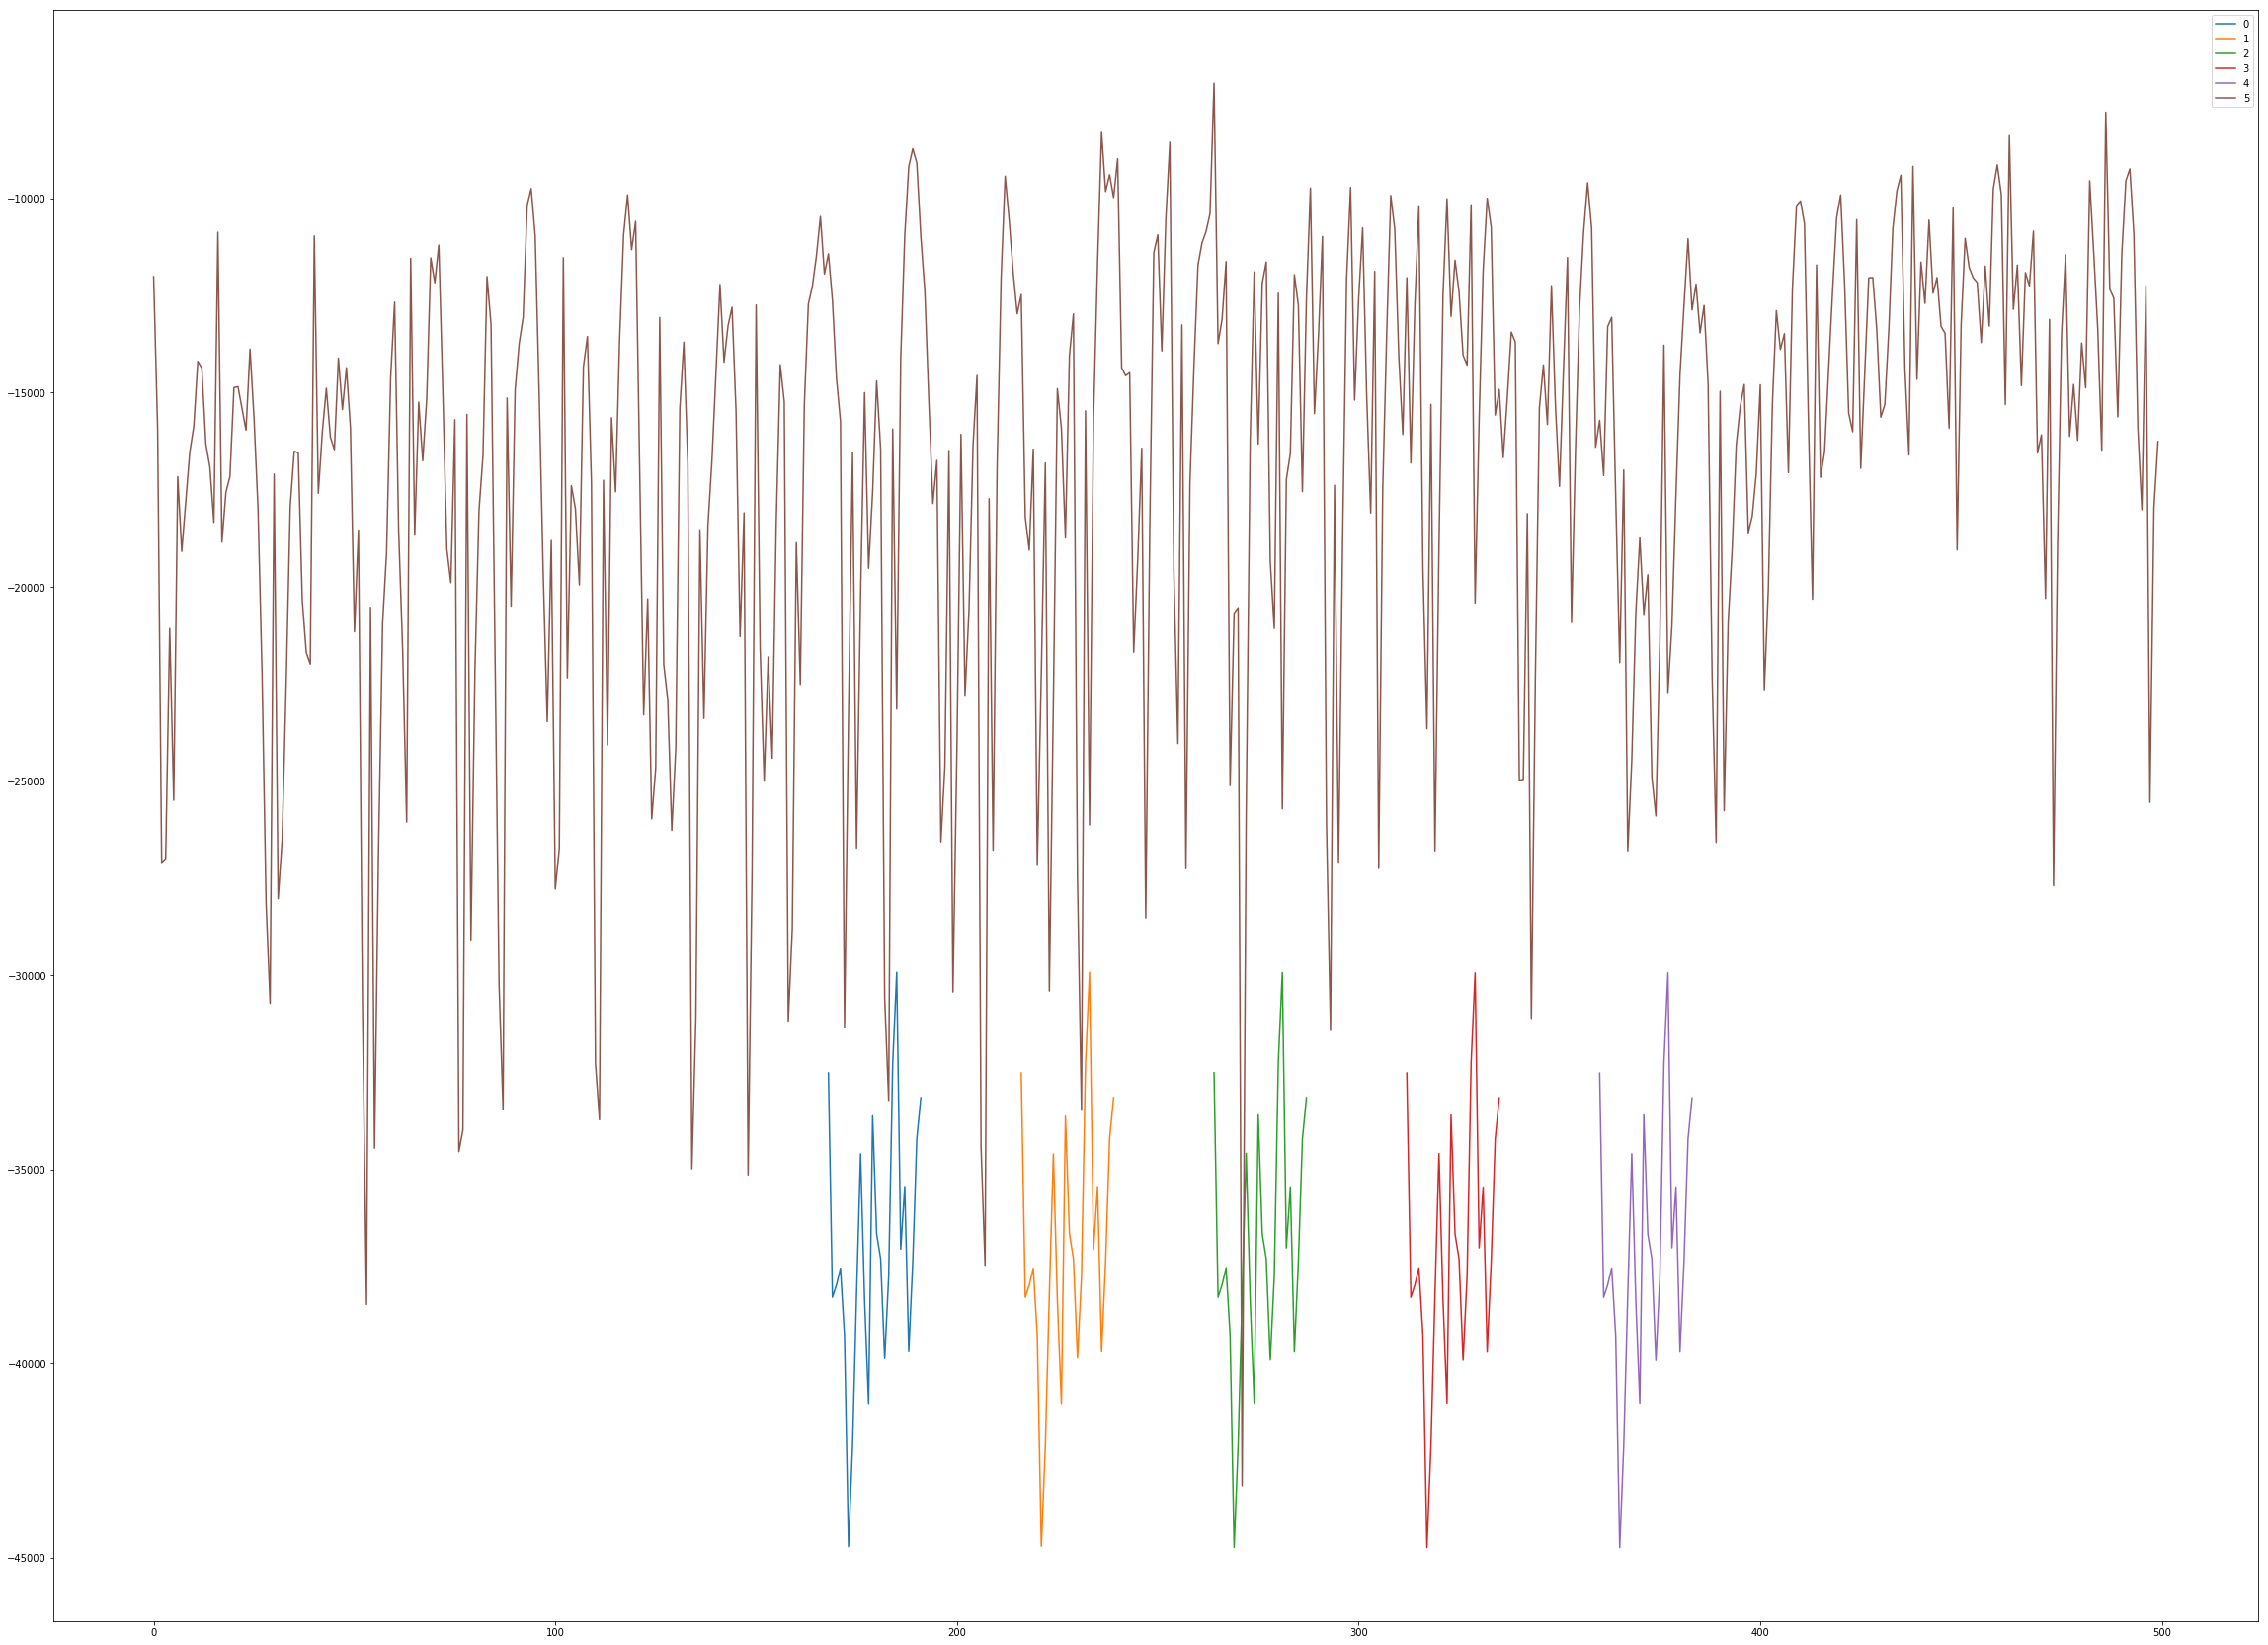

In [18]:
df_d = plot_for_model(model1)

Okay, so that is not very cool. It seems to always predict very much a similar result. Let's see what effects the preprocessing and the network stuctures have.

Epoch 1/4
147/147 [==============================] - 3s 18ms/step - loss: 0.0096
Epoch 2/4
147/147 [==============================] - 2s 16ms/step - loss: 0.0075
Epoch 3/4
147/147 [==============================] - 2s 16ms/step - loss: 0.0077
Epoch 4/4
147/147 [==============================] - 2s 16ms/step - loss: 0.0075
(500, 6)


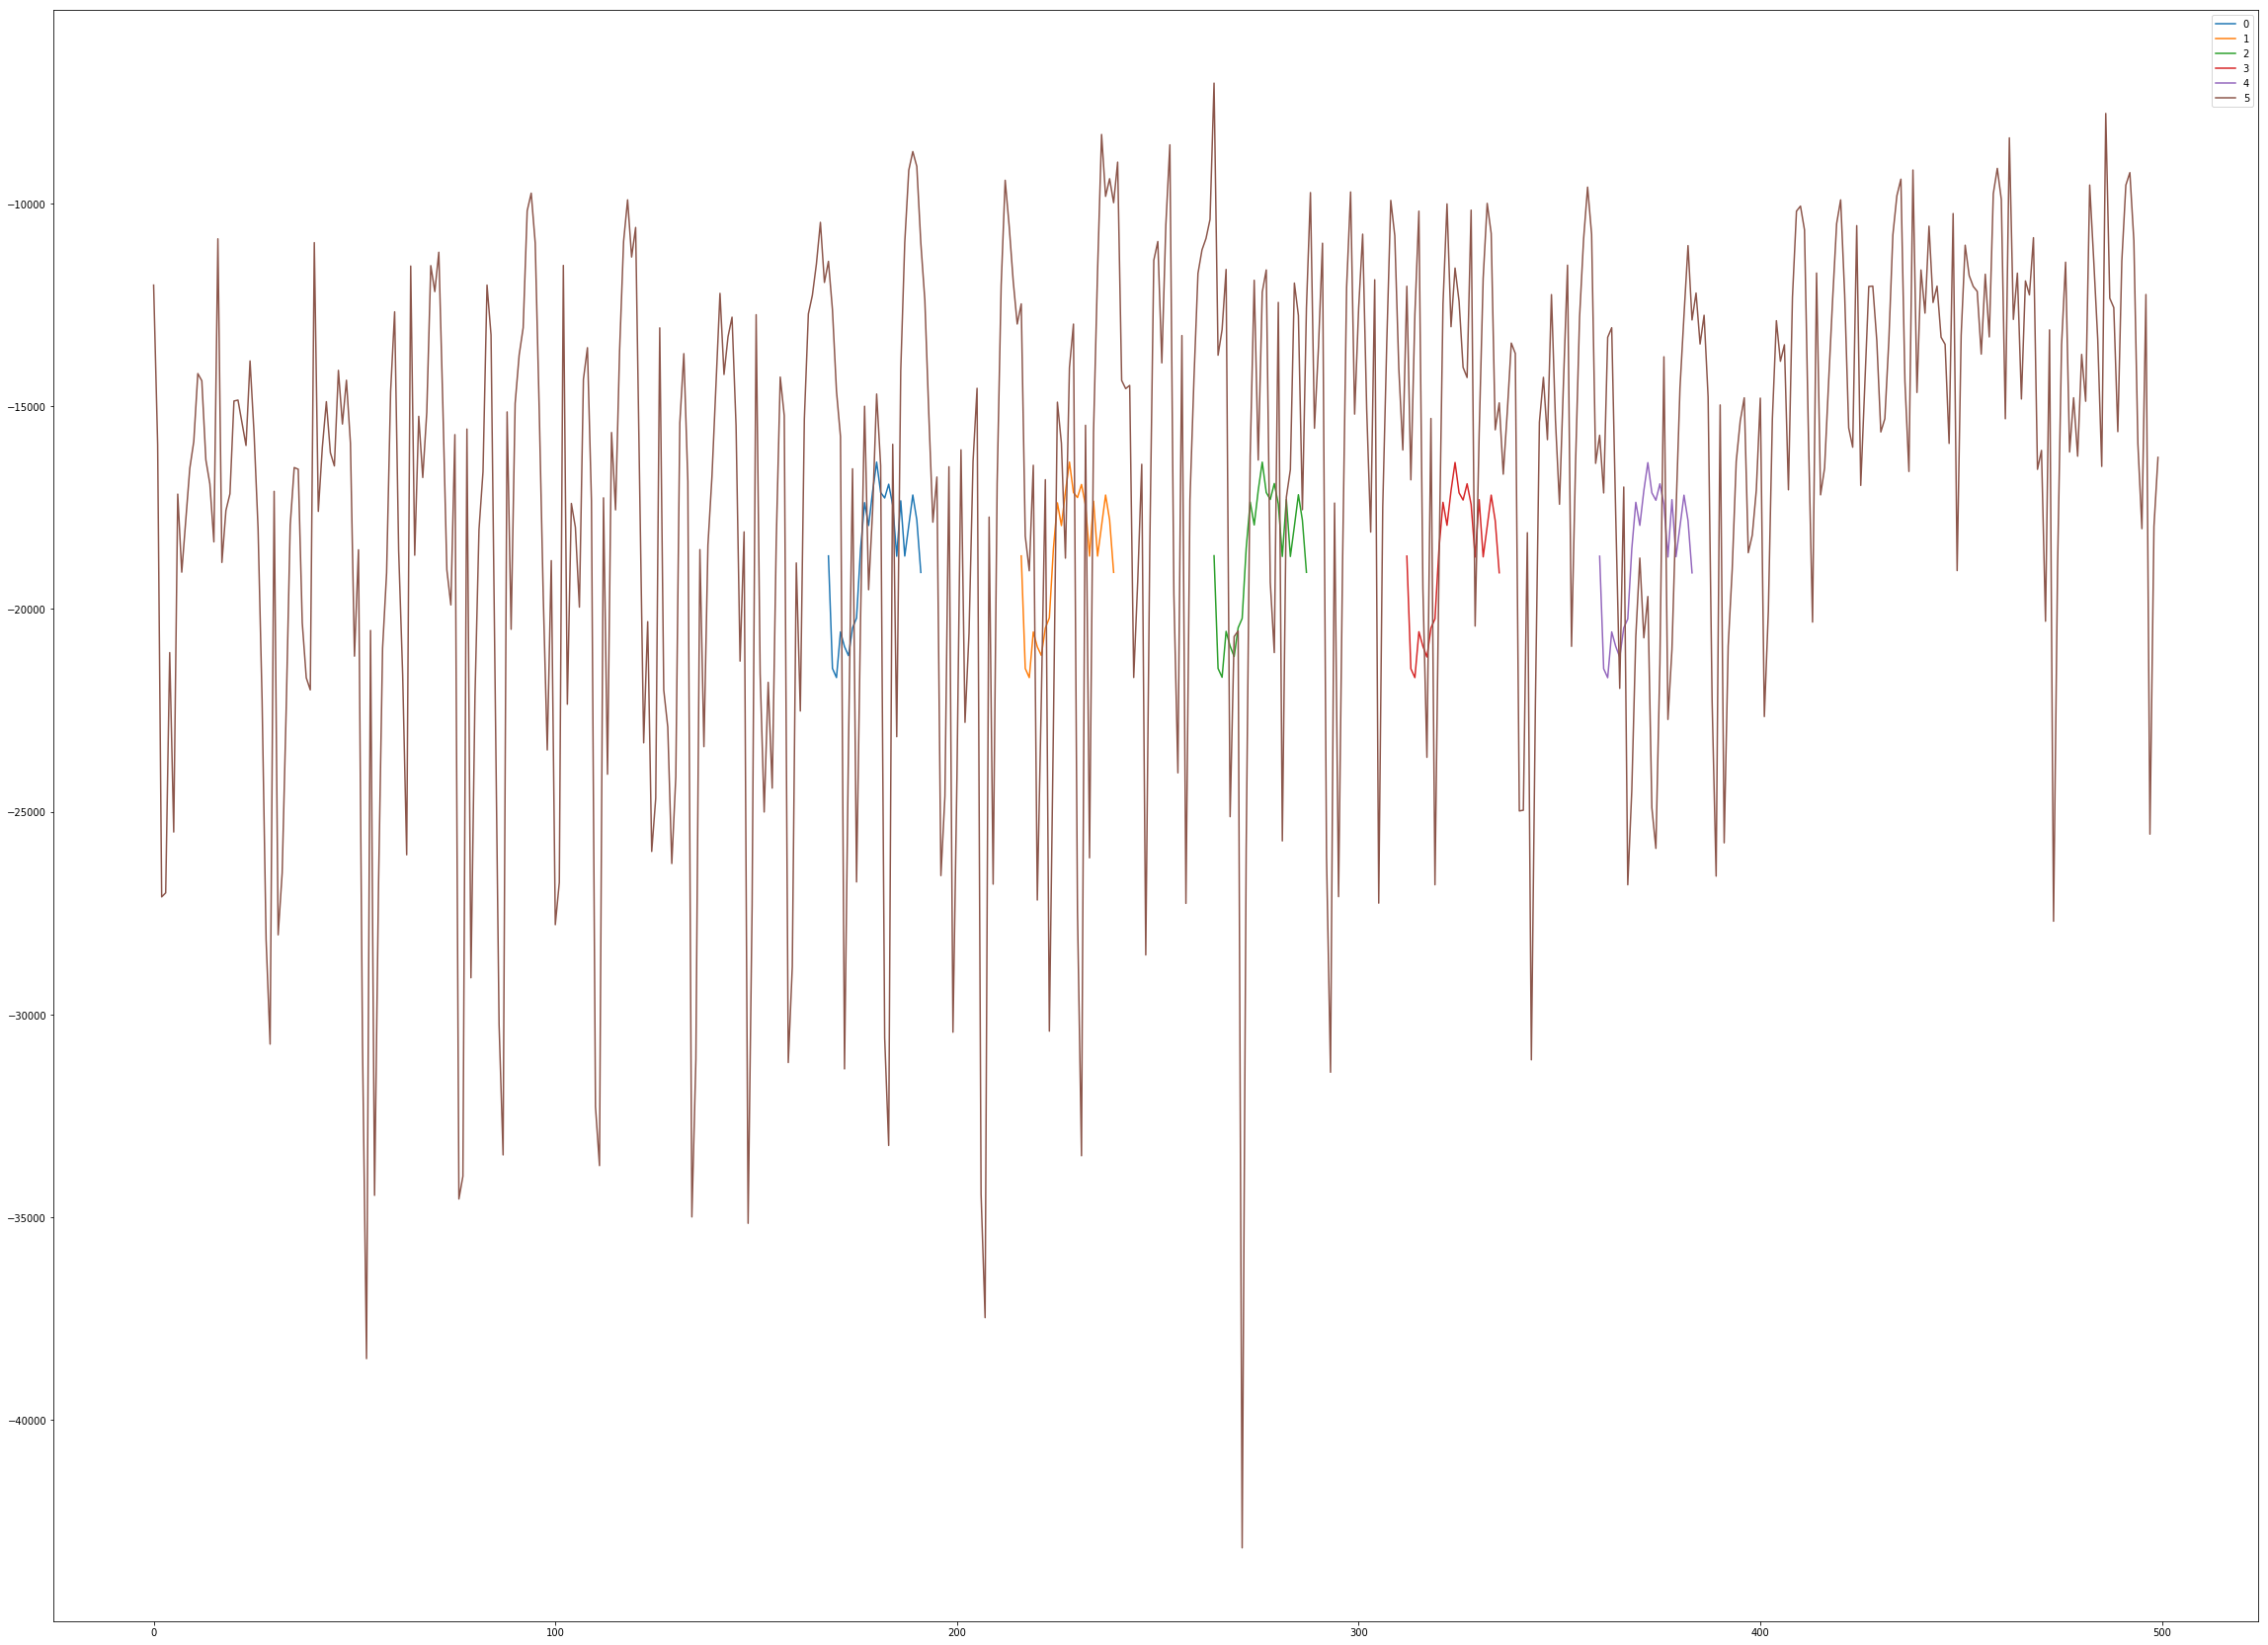

In [10]:
gen, base_data, scaler = get_gen_and_data(preprocessing='minmax')
model1.compile(loss='mse', optimizer='adam')
model1.fit_generator(gen, epochs=4)
df_d = plot_for_model(model1)

Trying with different model structures

In [11]:
model = Sequential()
# input layer
input_shape = (cfg.DEMAND_ONE_WEEK, 1)
model.add(CuDNNLSTM(168, input_shape=input_shape, return_sequences=False))
model.add(Dense(24))
model.add(Activation('linear'))

model.compile(loss='mse', optimizer='sgd')

model.fit_generator(gen, epochs=6)

Epoch 1/6
147/147 [==============================] - 1s 7ms/step - loss: 0.1010
Epoch 2/6
147/147 [==============================] - 1s 7ms/step - loss: 0.0266
Epoch 3/6
147/147 [==============================] - 1s 7ms/step - loss: 0.0090
Epoch 4/6
147/147 [==============================] - 1s 6ms/step - loss: 0.0069
Epoch 5/6
147/147 [==============================] - 1s 6ms/step - loss: 0.0067
Epoch 6/6
147/147 [==============================] - 1s 6ms/step - loss: 0.0067


(500, 6)


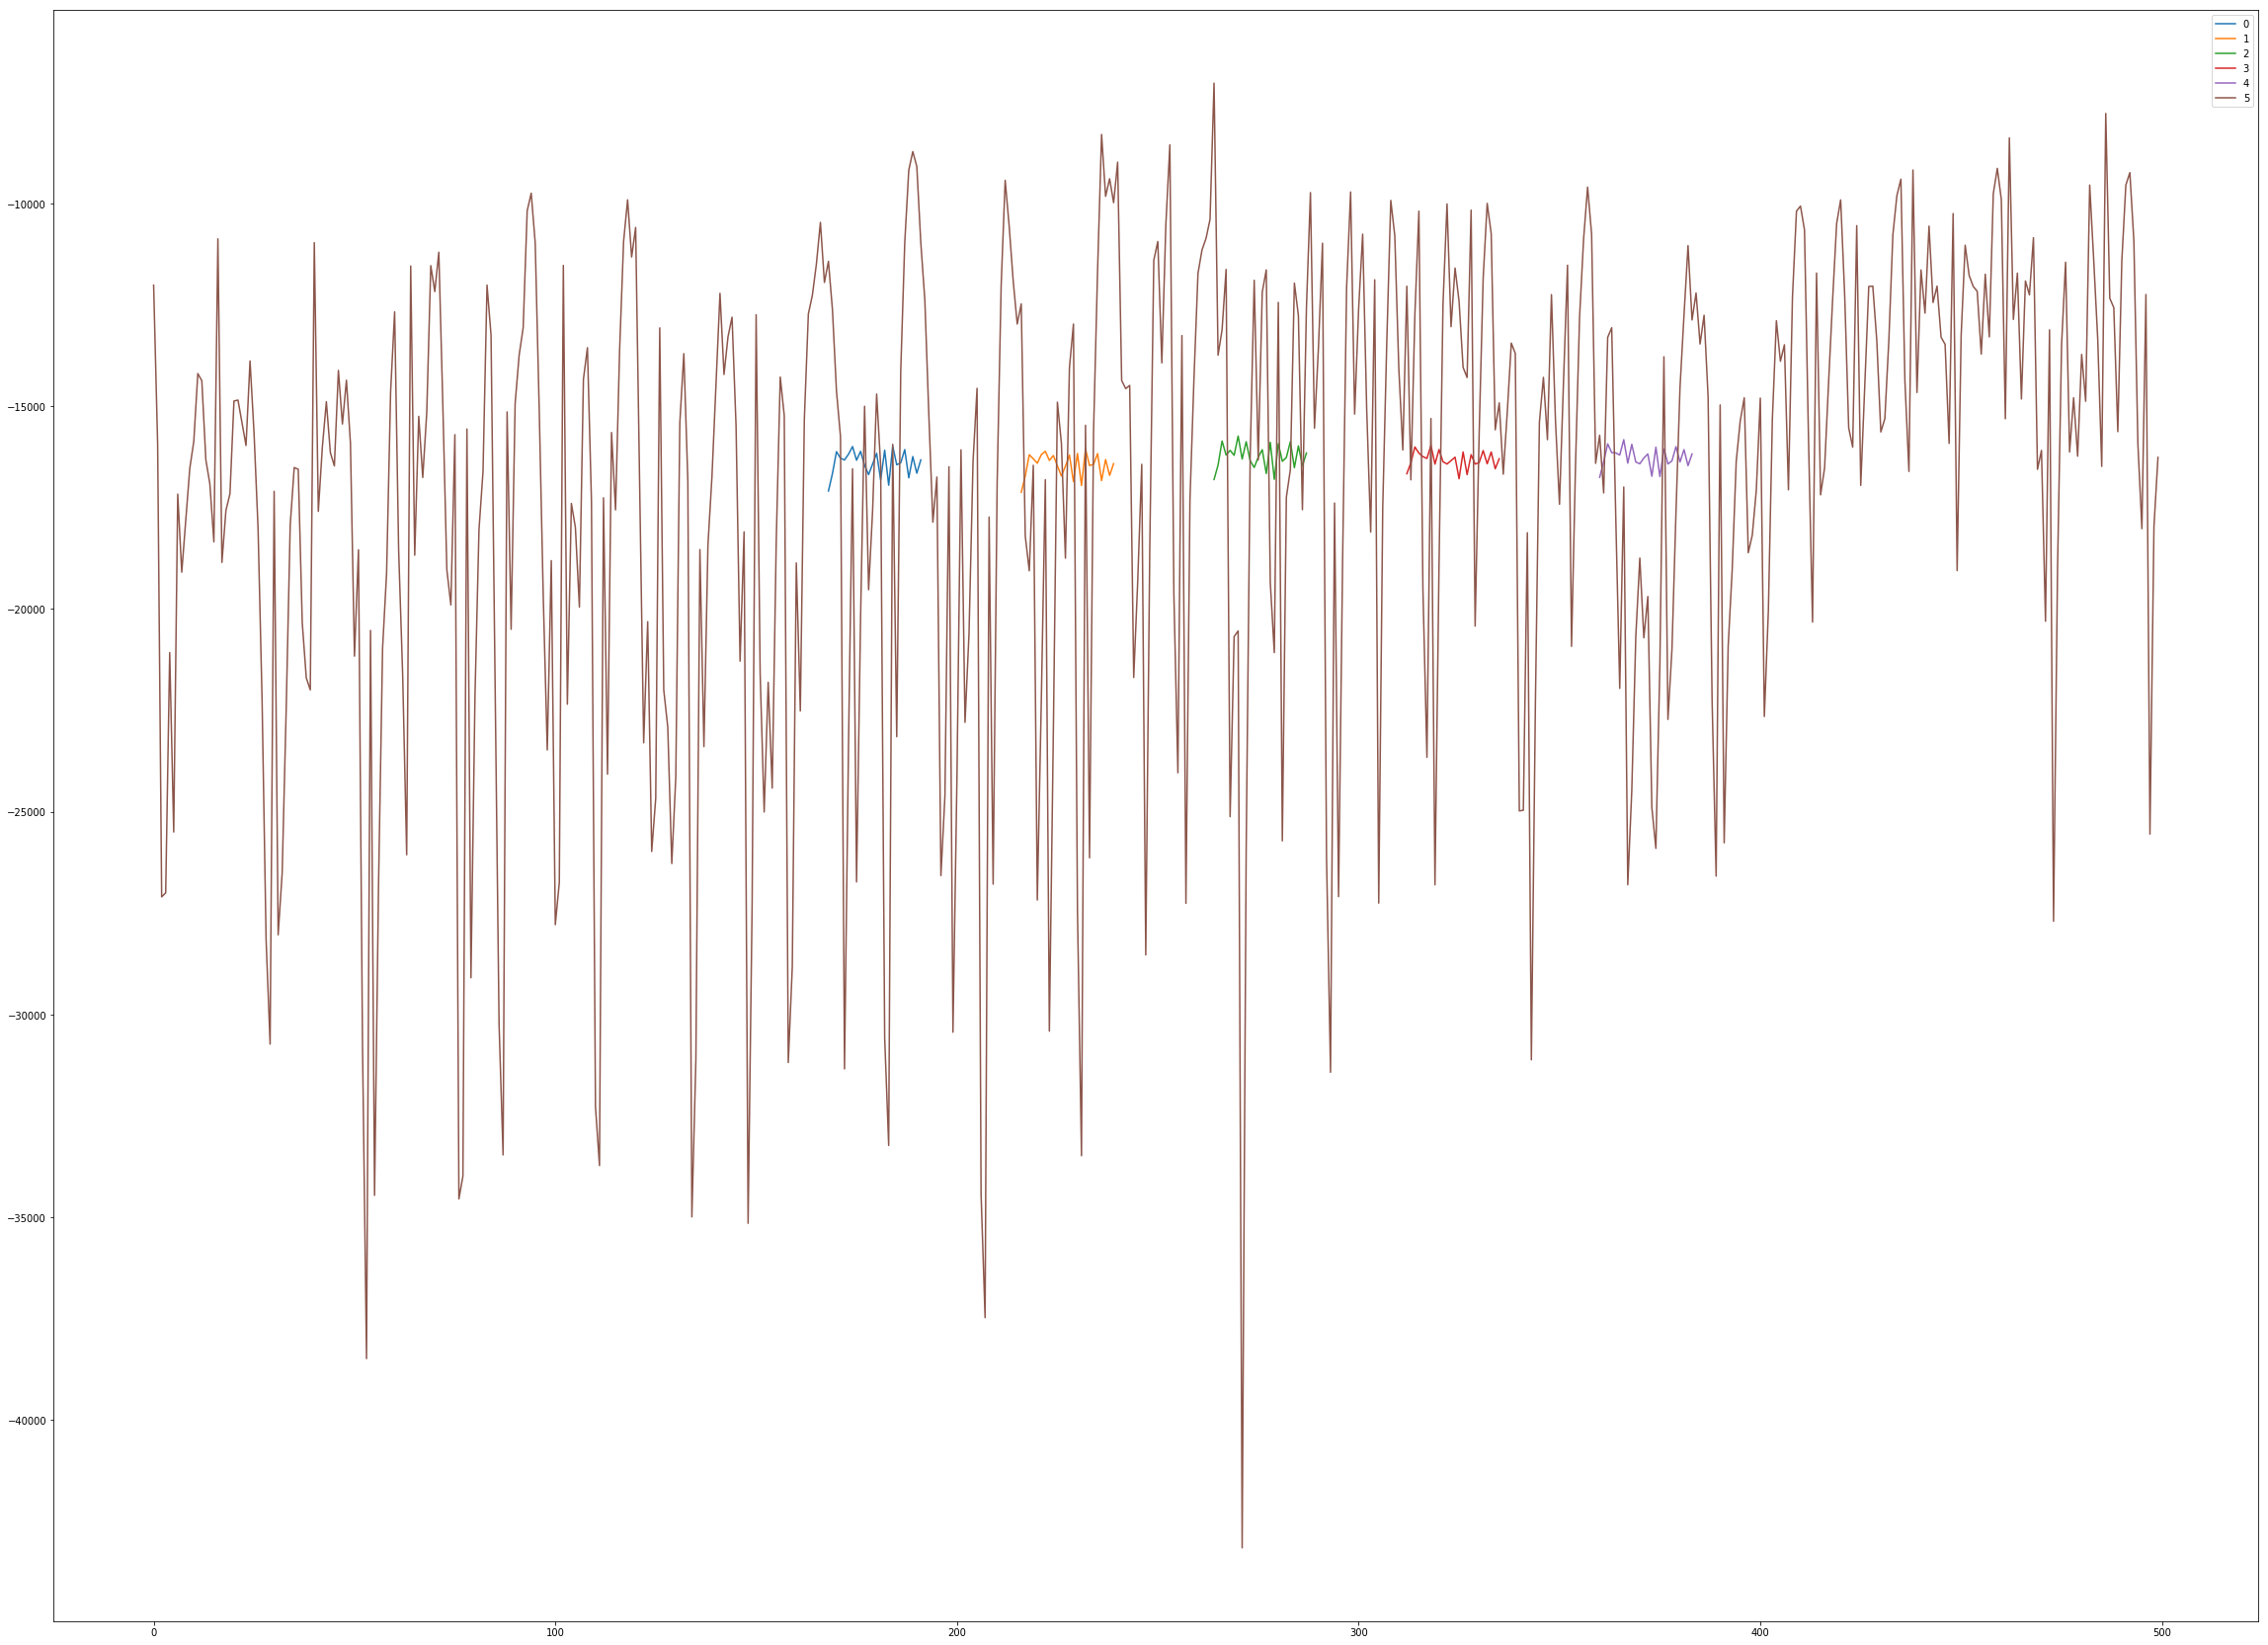

In [12]:
df_d = plot_for_model(model)

okay that's just flat. 

Okay, let's try a different type. Dense only, without LSTM / Memory. Flatten the input

In [24]:
gen, base_data, scaler = get_gen_and_data(preprocessing='minmax', flatten=True)

model2 = Sequential()
# input layer
input_shape = (cfg.DEMAND_ONE_WEEK,)
model2.add(Dense(168, input_shape=input_shape, activation='relu'))
model2.add(Dense(100, activation='relu'))
model2.add(Dense(50, activation='relu'))
model2.add(Dense(24))
model2.add(Activation('linear'))

model2.compile(loss='mse', optimizer='adam')

model2.fit_generator(gen, epochs=20)

Epoch 1/20
147/147 [==============================] - 1s 5ms/step - loss: 0.0173
Epoch 2/20
147/147 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 3/20
147/147 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 4/20
147/147 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 5/20
147/147 [==============================] - 0s 3ms/step - loss: 0.0073
Epoch 6/20
147/147 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 7/20
147/147 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 8/20
147/147 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 9/20
147/147 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 10/20
147/147 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 11/20
147/147 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 12/20
147/147 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 13/20
147/147 [====

(500, 6)


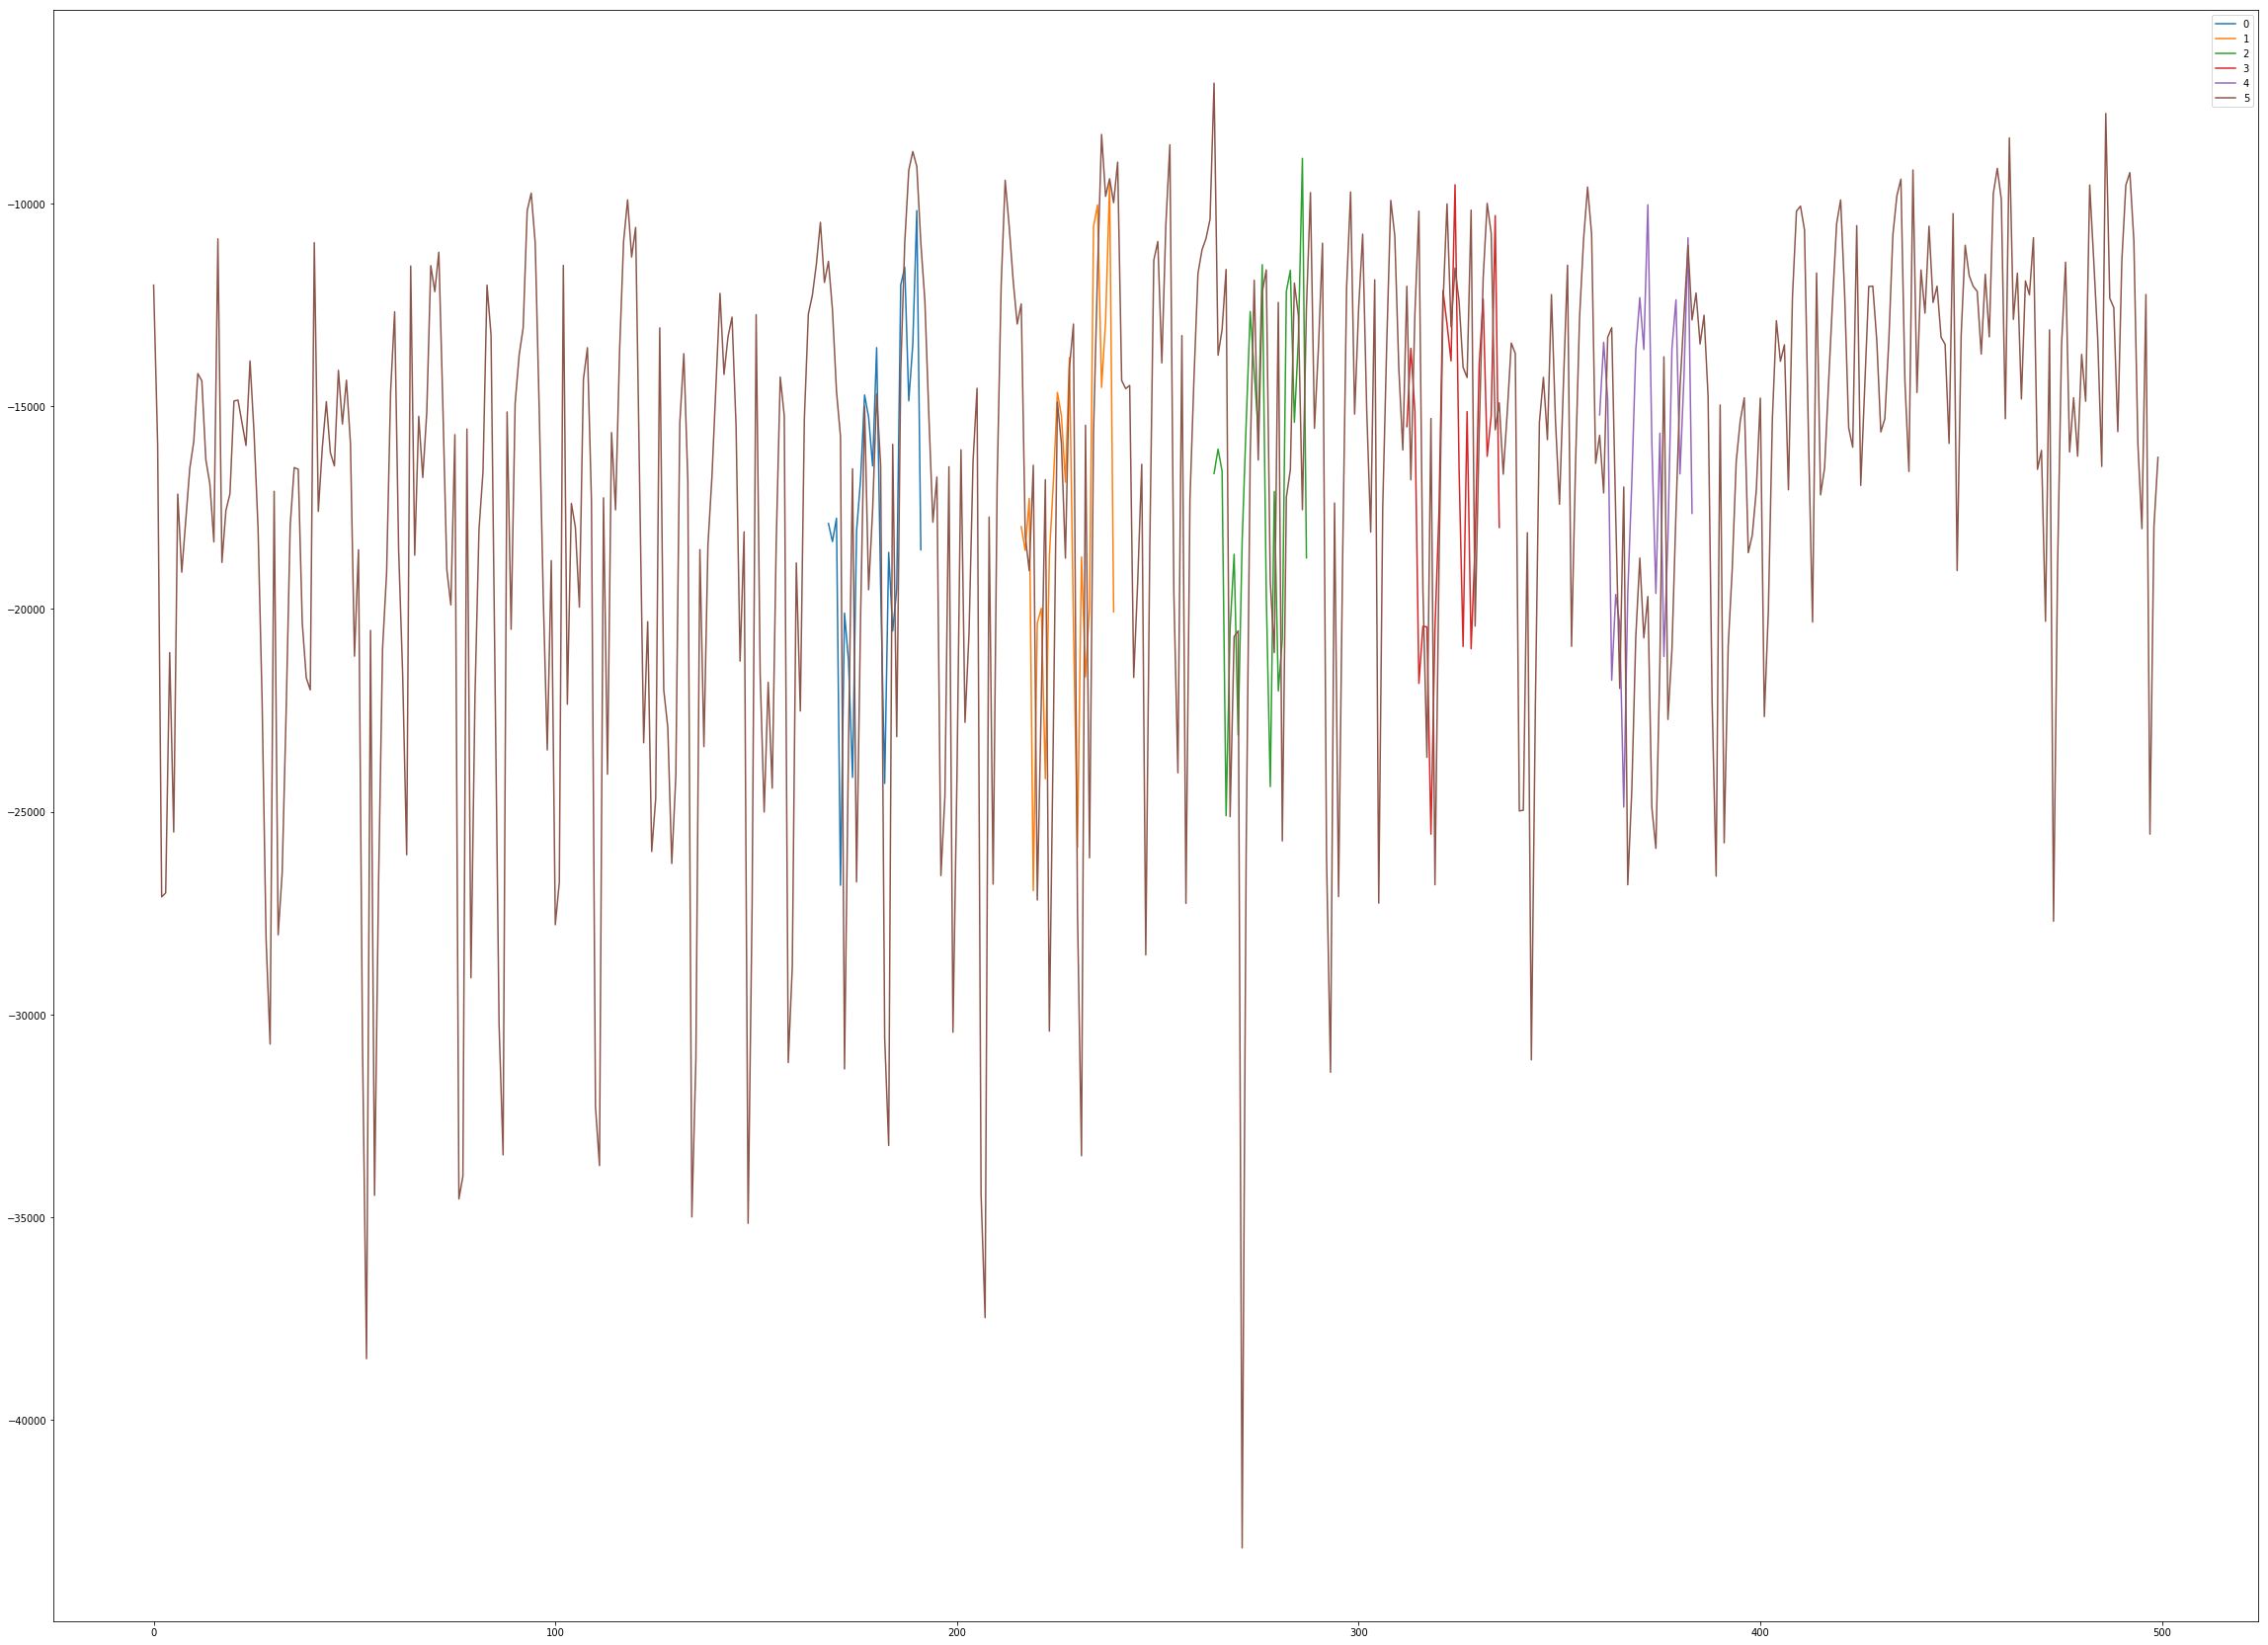

In [25]:
df_d = plot_for_model(model2, flatten=True)

### Trying for a different customer

In [28]:
print('Dense Vanilla based')
gen, base_data, scaler = get_gen_and_data(customer='EastsideOffices', flatten=True)
model2.compile(loss='mse', optimizer='adam')
model2.fit_generator(gen, epochs=10)
print('LSTM based')
gen, base_data, scaler = get_gen_and_data(customer='EastsideOffices', flatten=False)
model1.compile(loss='mse', optimizer='adam')
model1.fit_generator(gen, epochs=4)

Dense Vanilla based
Epoch 1/10
147/147 [==============================] - 1s 5ms/step - loss: 0.1583
Epoch 2/10
147/147 [==============================] - 0s 3ms/step - loss: 0.1488
Epoch 3/10
147/147 [==============================] - 0s 3ms/step - loss: 0.1537
Epoch 4/10
147/147 [==============================] - 0s 3ms/step - loss: 0.1507
Epoch 5/10
147/147 [==============================] - 0s 3ms/step - loss: 0.1502
Epoch 6/10
147/147 [==============================] - 0s 3ms/step - loss: 0.1410
Epoch 7/10
147/147 [==============================] - 0s 3ms/step - loss: 0.1372
Epoch 8/10
147/147 [==============================] - 0s 3ms/step - loss: 0.1366
Epoch 9/10
147/147 [==============================] - 0s 3ms/step - loss: 0.1397
Epoch 10/10
147/147 [==============================] - 0s 3ms/step - loss: 0.1198
LSTM based
Epoch 1/4
147/147 [==============================] - 3s 21ms/step - loss: 1.1157
Epoch 2/4
147/147 [==============================] - 2s 16ms/step - loss: 1.1

(500, 6)
(500, 6)


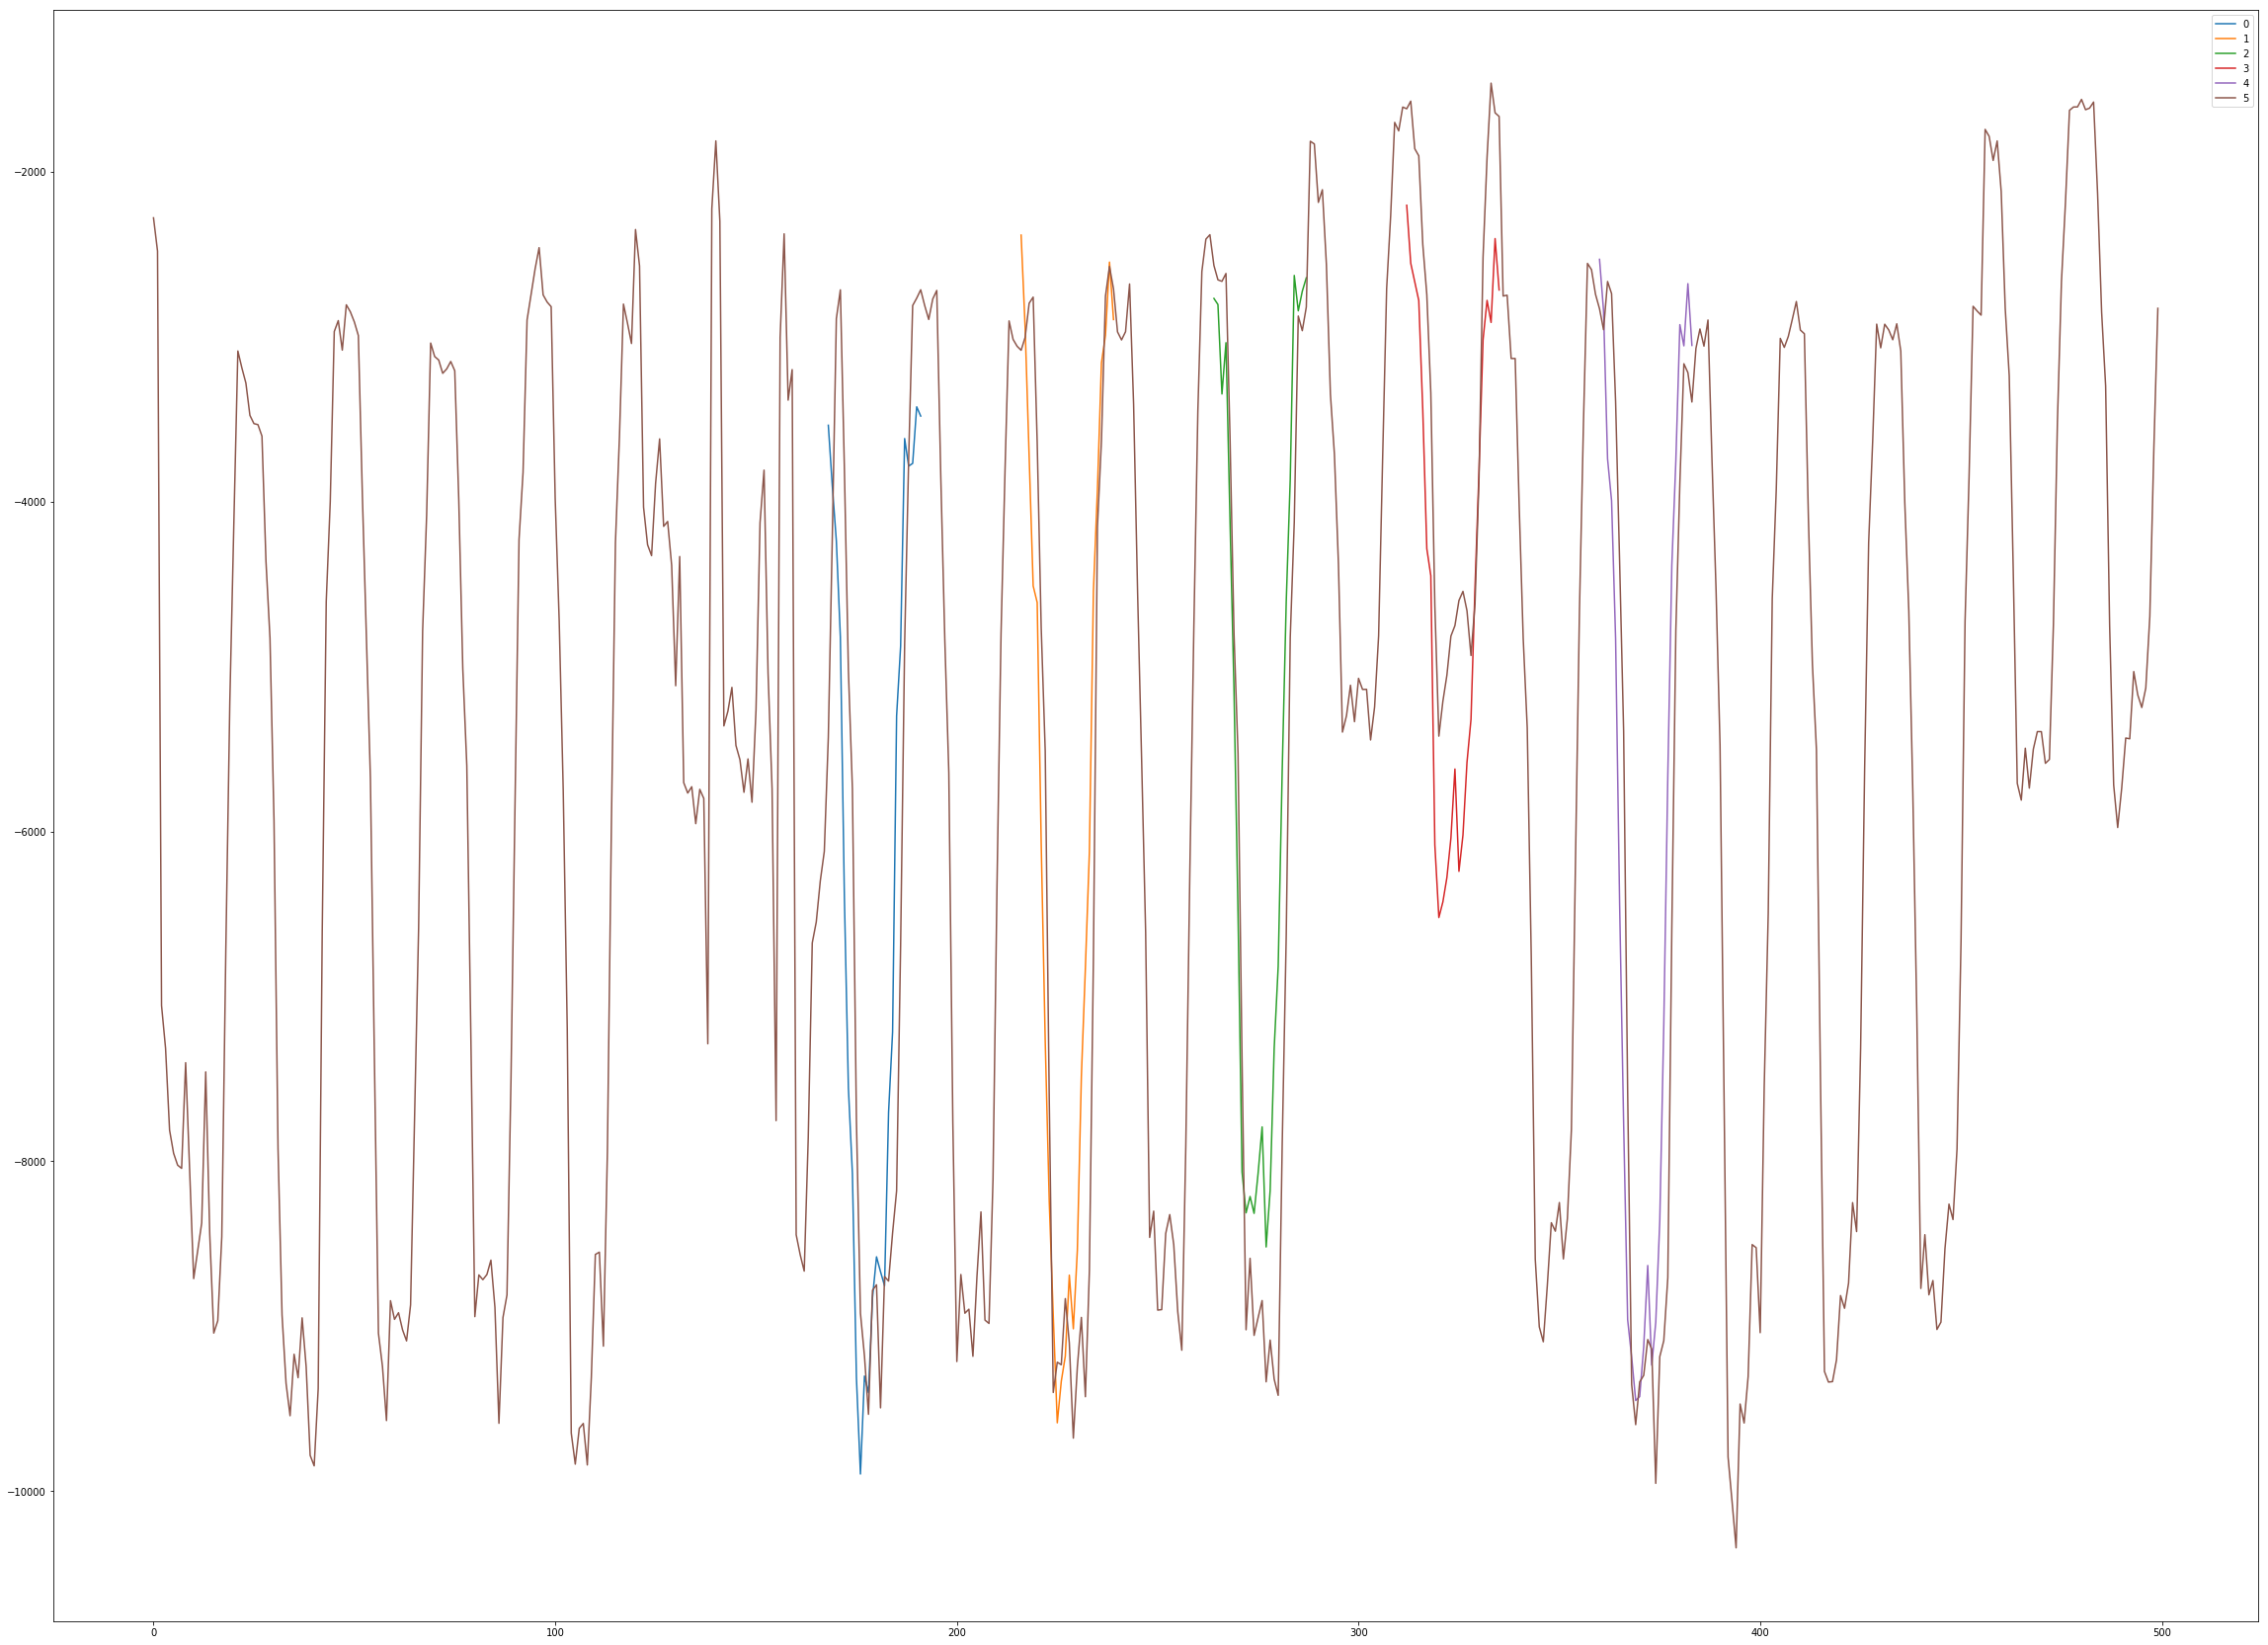

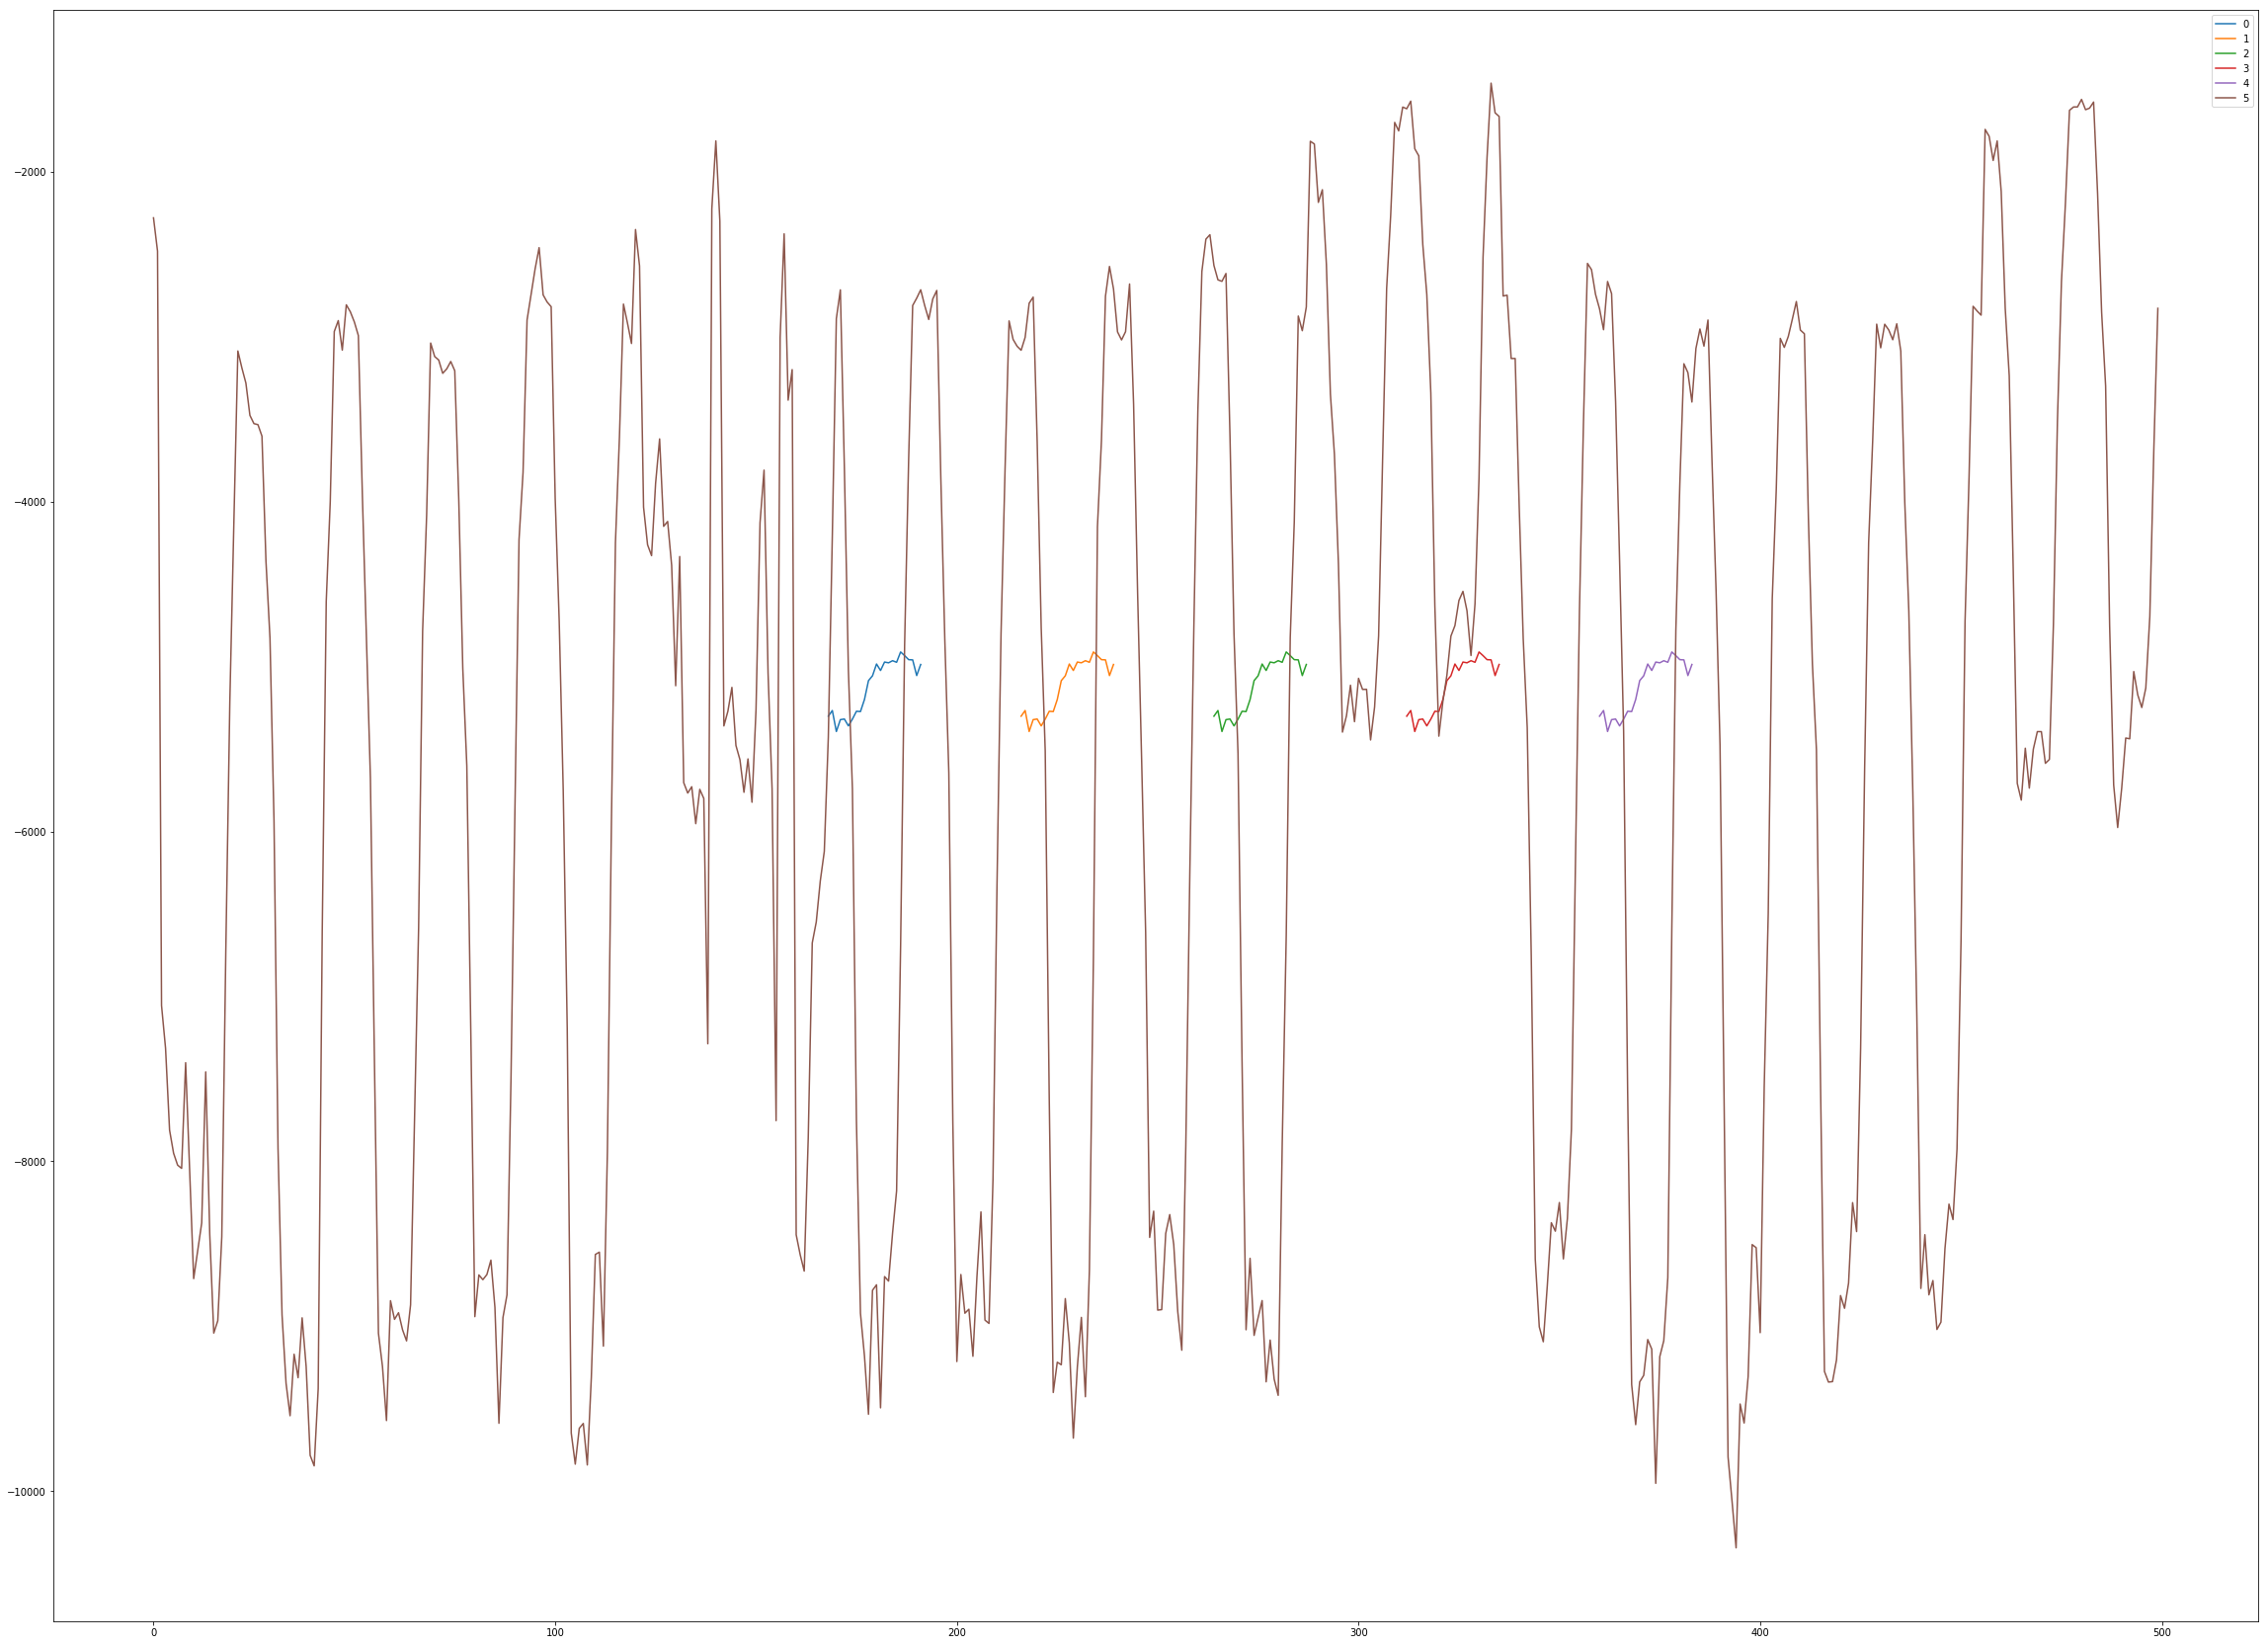

In [27]:
df_d = plot_for_model(model2, flatten=True)
df_d = plot_for_model(model1, flatten=False)

Okay, looking good with:
- standard scaler
- dense
- sgd
- mse
- relu
- linear in output layer

Trying again with hard customer group

Epoch 1/20
147/147 [==============================] - 1s 3ms/step - loss: 8.2080
Epoch 2/20
147/147 [==============================] - 0s 3ms/step - loss: 5.6846
Epoch 3/20
147/147 [==============================] - 0s 3ms/step - loss: 5.0318
Epoch 4/20
147/147 [==============================] - 0s 3ms/step - loss: 4.7393
Epoch 5/20
147/147 [==============================] - 0s 3ms/step - loss: 4.5103
Epoch 6/20
147/147 [==============================] - 0s 3ms/step - loss: 4.1276
Epoch 7/20
147/147 [==============================] - 0s 3ms/step - loss: 4.0775
Epoch 8/20
147/147 [==============================] - 0s 3ms/step - loss: 3.8119
Epoch 9/20
147/147 [==============================] - 0s 3ms/step - loss: 3.6551
Epoch 10/20
147/147 [==============================] - 0s 3ms/step - loss: 3.5440
Epoch 11/20
147/147 [==============================] - 0s 3ms/step - loss: 3.4278
Epoch 12/20
147/147 [==============================] - 0s 3ms/step - loss: 3.3301
Epoch 13/20
147/147 [====

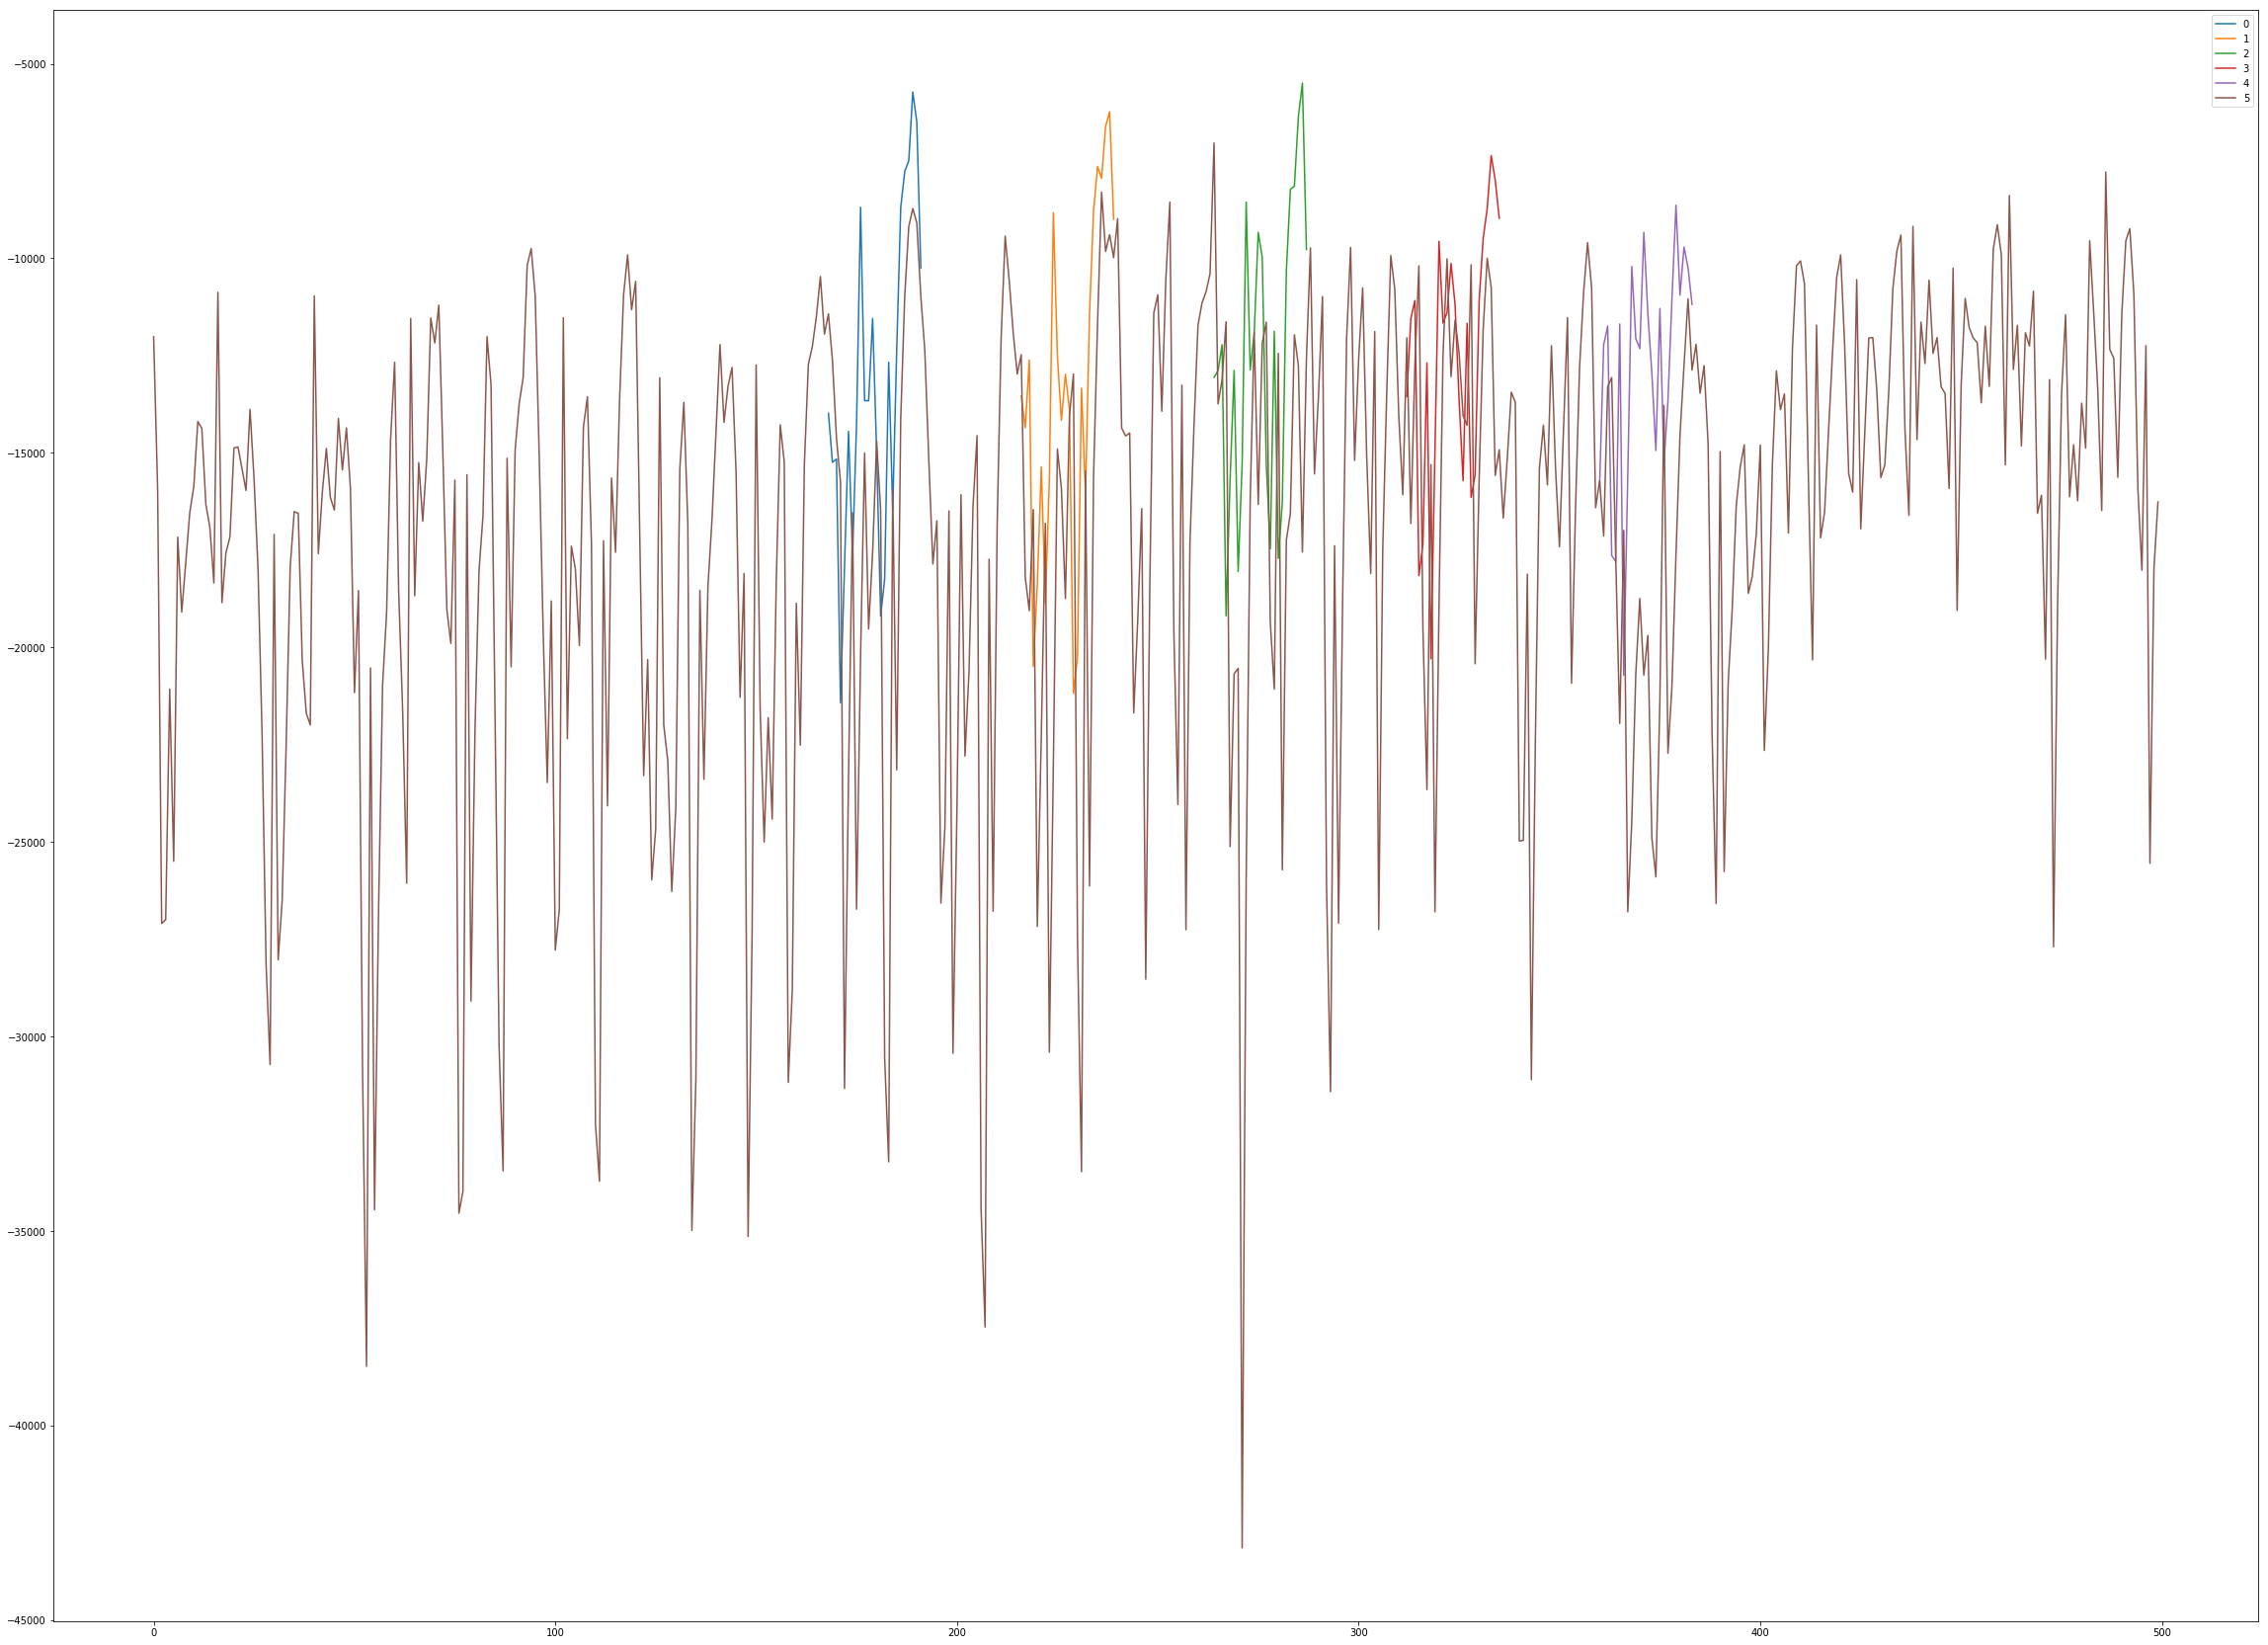

In [19]:
gen, base_data, scaler = get_gen_and_data(flatten=True)

model3 = Sequential()
# input layer
input_shape = (cfg.DEMAND_ONE_WEEK,)
model3.add(Dense(168, input_shape=input_shape, activation='relu'))
model3.add(Dense(100, activation='relu'))
model3.add(Dense(100, activation='relu'))
model3.add(Dense(50, activation='relu'))
model3.add(Dense(50, activation='relu'))
model3.add(Dense(24))
model3.add(Activation('linear'))

model3.compile(loss='mse', optimizer='rmsprop')

model3.fit_generator(gen, epochs=20)

df_d = plot_for_model(model3, flatten=True)


And applying this to the very systematic offices:

In [20]:
gen, base_data, scaler = get_gen_and_data(customer='EastsideOffices', flatten=True)
model3.fit_generator(gen, epochs=20)

Epoch 1/20
147/147 [==============================] - 0s 2ms/step - loss: 0.4015
Epoch 2/20
147/147 [==============================] - 0s 3ms/step - loss: 0.2608
Epoch 3/20
147/147 [==============================] - 0s 3ms/step - loss: 0.2209
Epoch 4/20
147/147 [==============================] - 0s 3ms/step - loss: 0.1866
Epoch 5/20
147/147 [==============================] - 0s 3ms/step - loss: 0.1845
Epoch 6/20
147/147 [==============================] - 0s 3ms/step - loss: 0.1750
Epoch 7/20
147/147 [==============================] - 0s 3ms/step - loss: 0.1722
Epoch 8/20
147/147 [==============================] - 0s 3ms/step - loss: 0.1691
Epoch 9/20
147/147 [==============================] - 0s 3ms/step - loss: 0.1597
Epoch 10/20
147/147 [==============================] - 0s 3ms/step - loss: 0.1693
Epoch 11/20
147/147 [==============================] - 0s 3ms/step - loss: 0.1621
Epoch 12/20
147/147 [==============================] - 0s 3ms/step - loss: 0.1469
Epoch 13/20
147/147 [====

(500, 6)


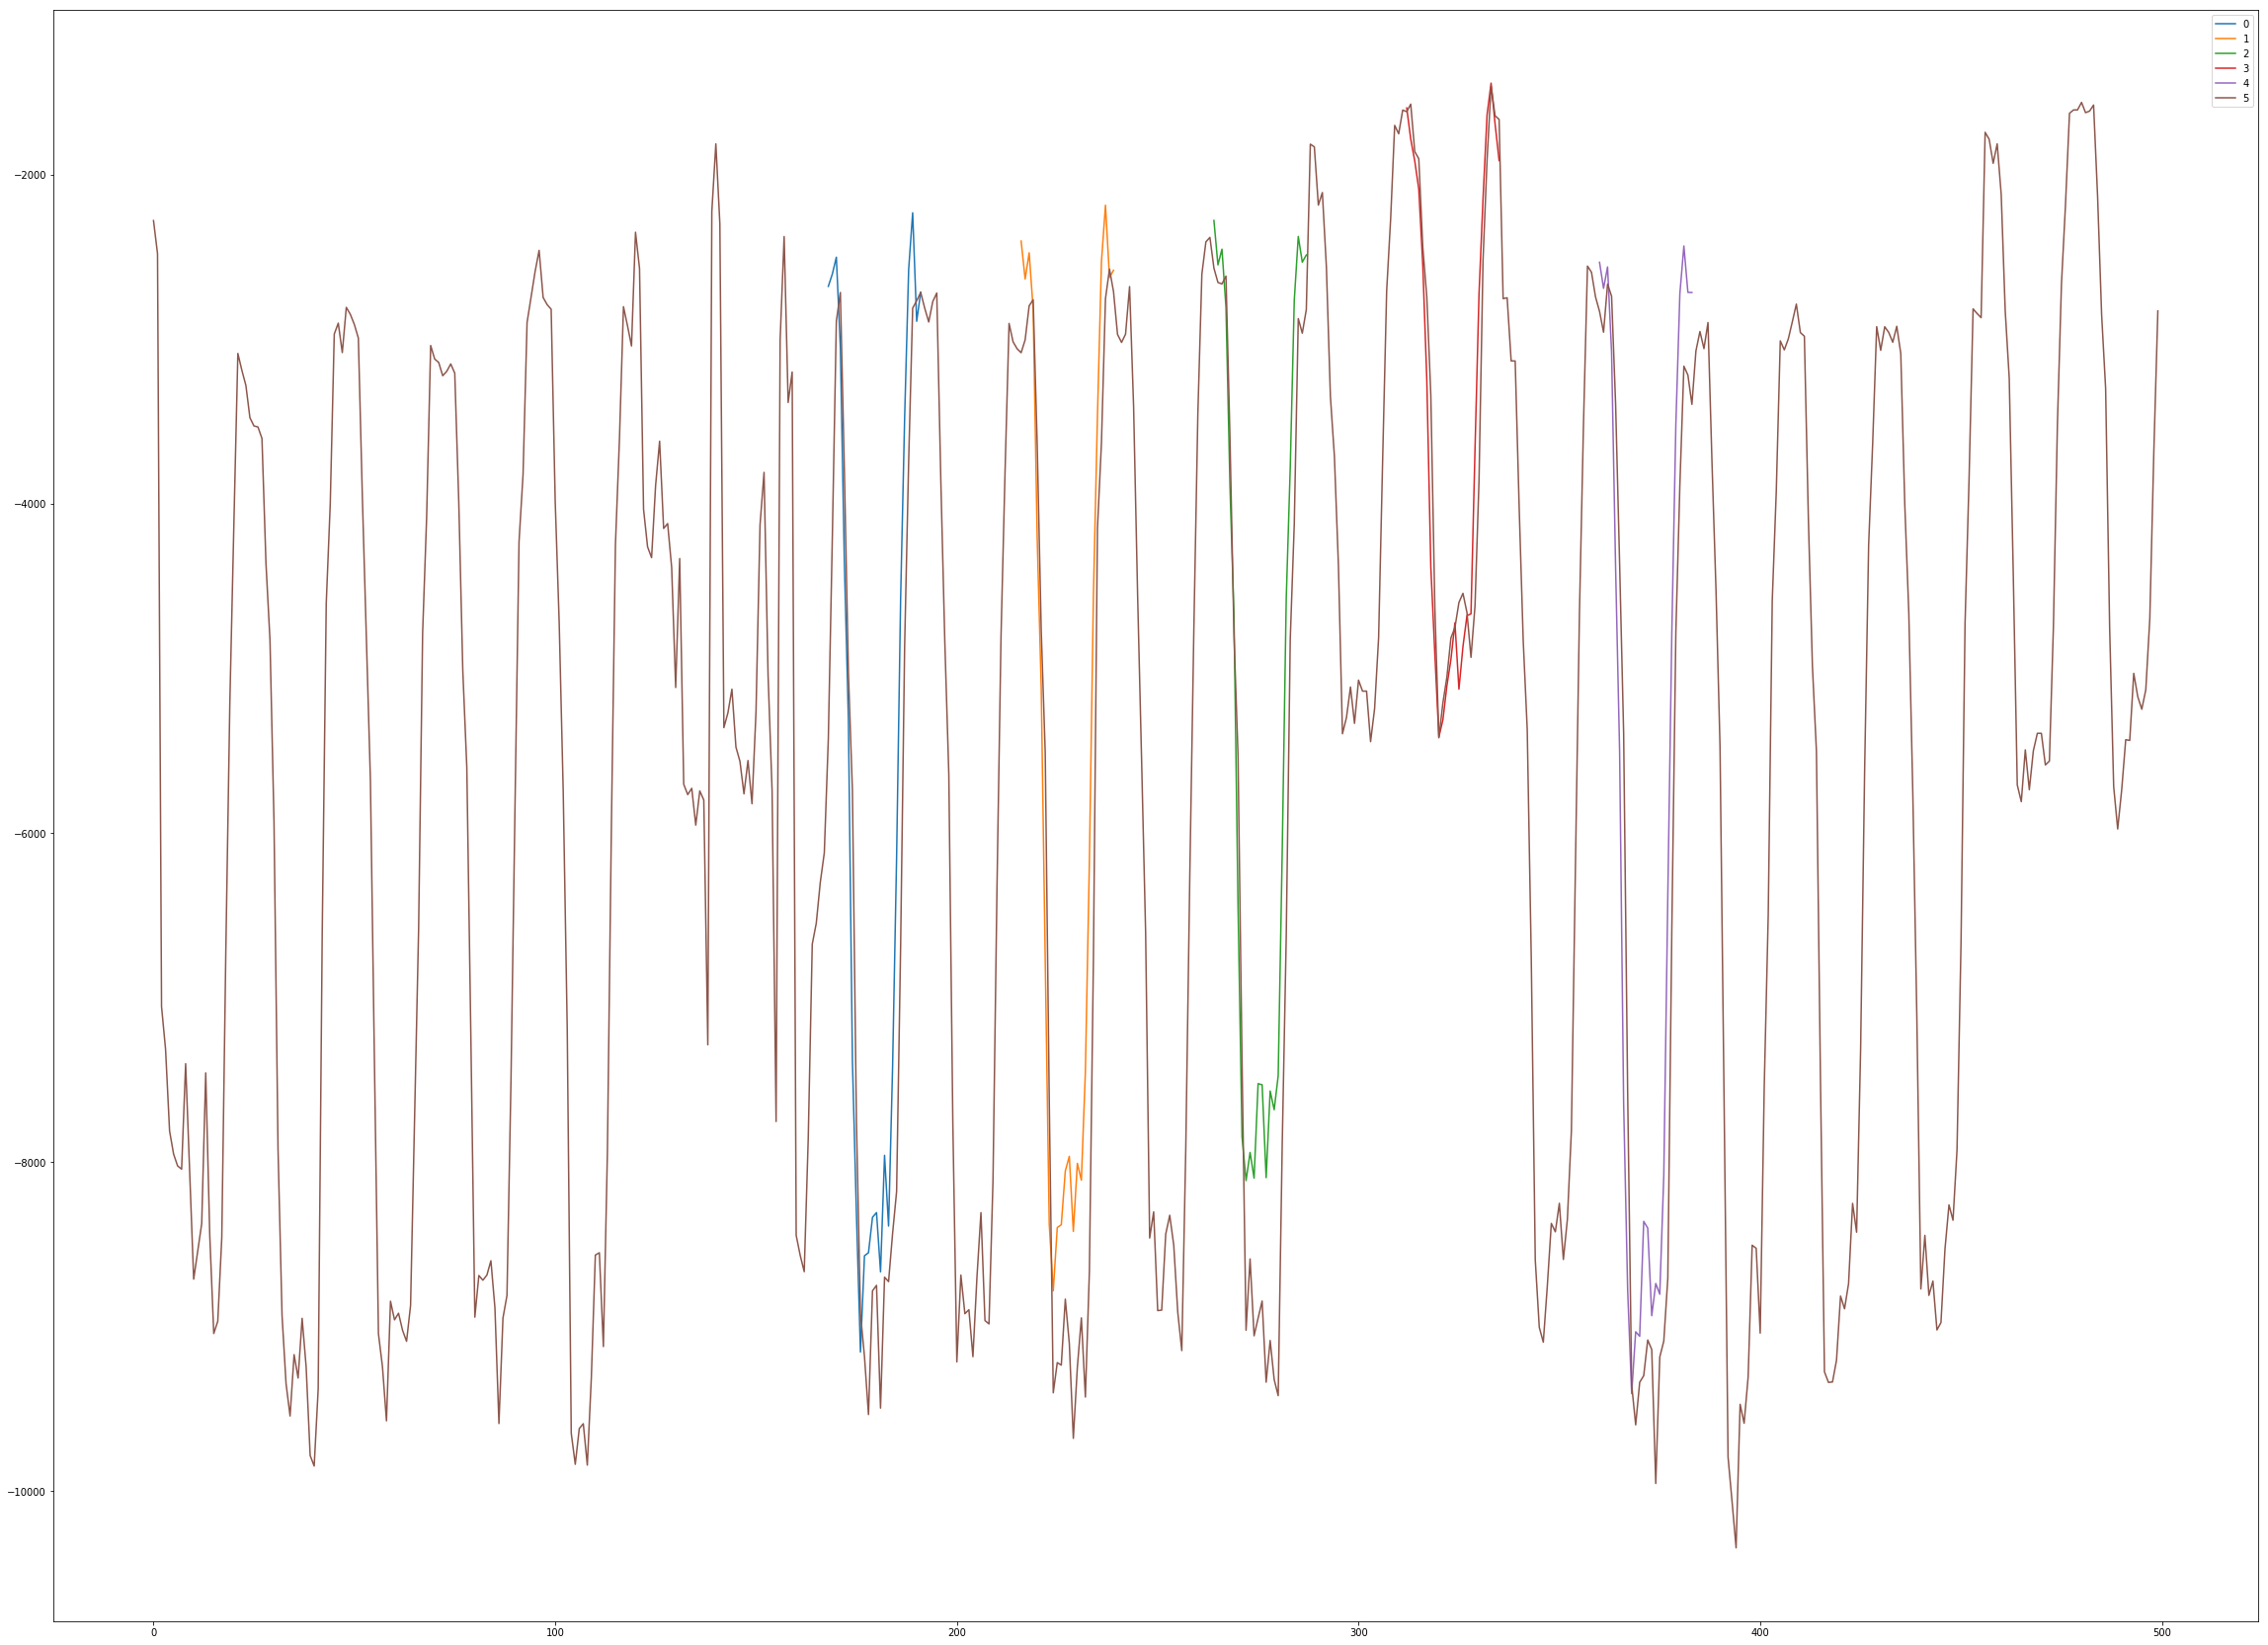

In [21]:
df_d = plot_for_model(model3, flatten=True)


### Single hard customer prediction with best model (model3)

Epoch 1/20
147/147 [==============================] - 0s 2ms/step - loss: 0.0428
Epoch 2/20
147/147 [==============================] - 0s 3ms/step - loss: 7.0300e-04
Epoch 3/20
147/147 [==============================] - 0s 3ms/step - loss: 5.7538e-04
Epoch 4/20
147/147 [==============================] - 0s 3ms/step - loss: 5.0173e-04
Epoch 5/20
147/147 [==============================] - 0s 3ms/step - loss: 4.7742e-04
Epoch 6/20
147/147 [==============================] - 0s 3ms/step - loss: 3.8697e-04
Epoch 7/20
147/147 [==============================] - 0s 3ms/step - loss: 3.9085e-04
Epoch 8/20
147/147 [==============================] - 0s 3ms/step - loss: 3.6123e-04
Epoch 9/20
147/147 [==============================] - 0s 3ms/step - loss: 3.2737e-04
Epoch 10/20
147/147 [==============================] - 0s 3ms/step - loss: 3.0583e-04
Epoch 11/20
147/147 [==============================] - 0s 3ms/step - loss: 2.8918e-04
Epoch 12/20
147/147 [==============================] - 0s 3ms/step 

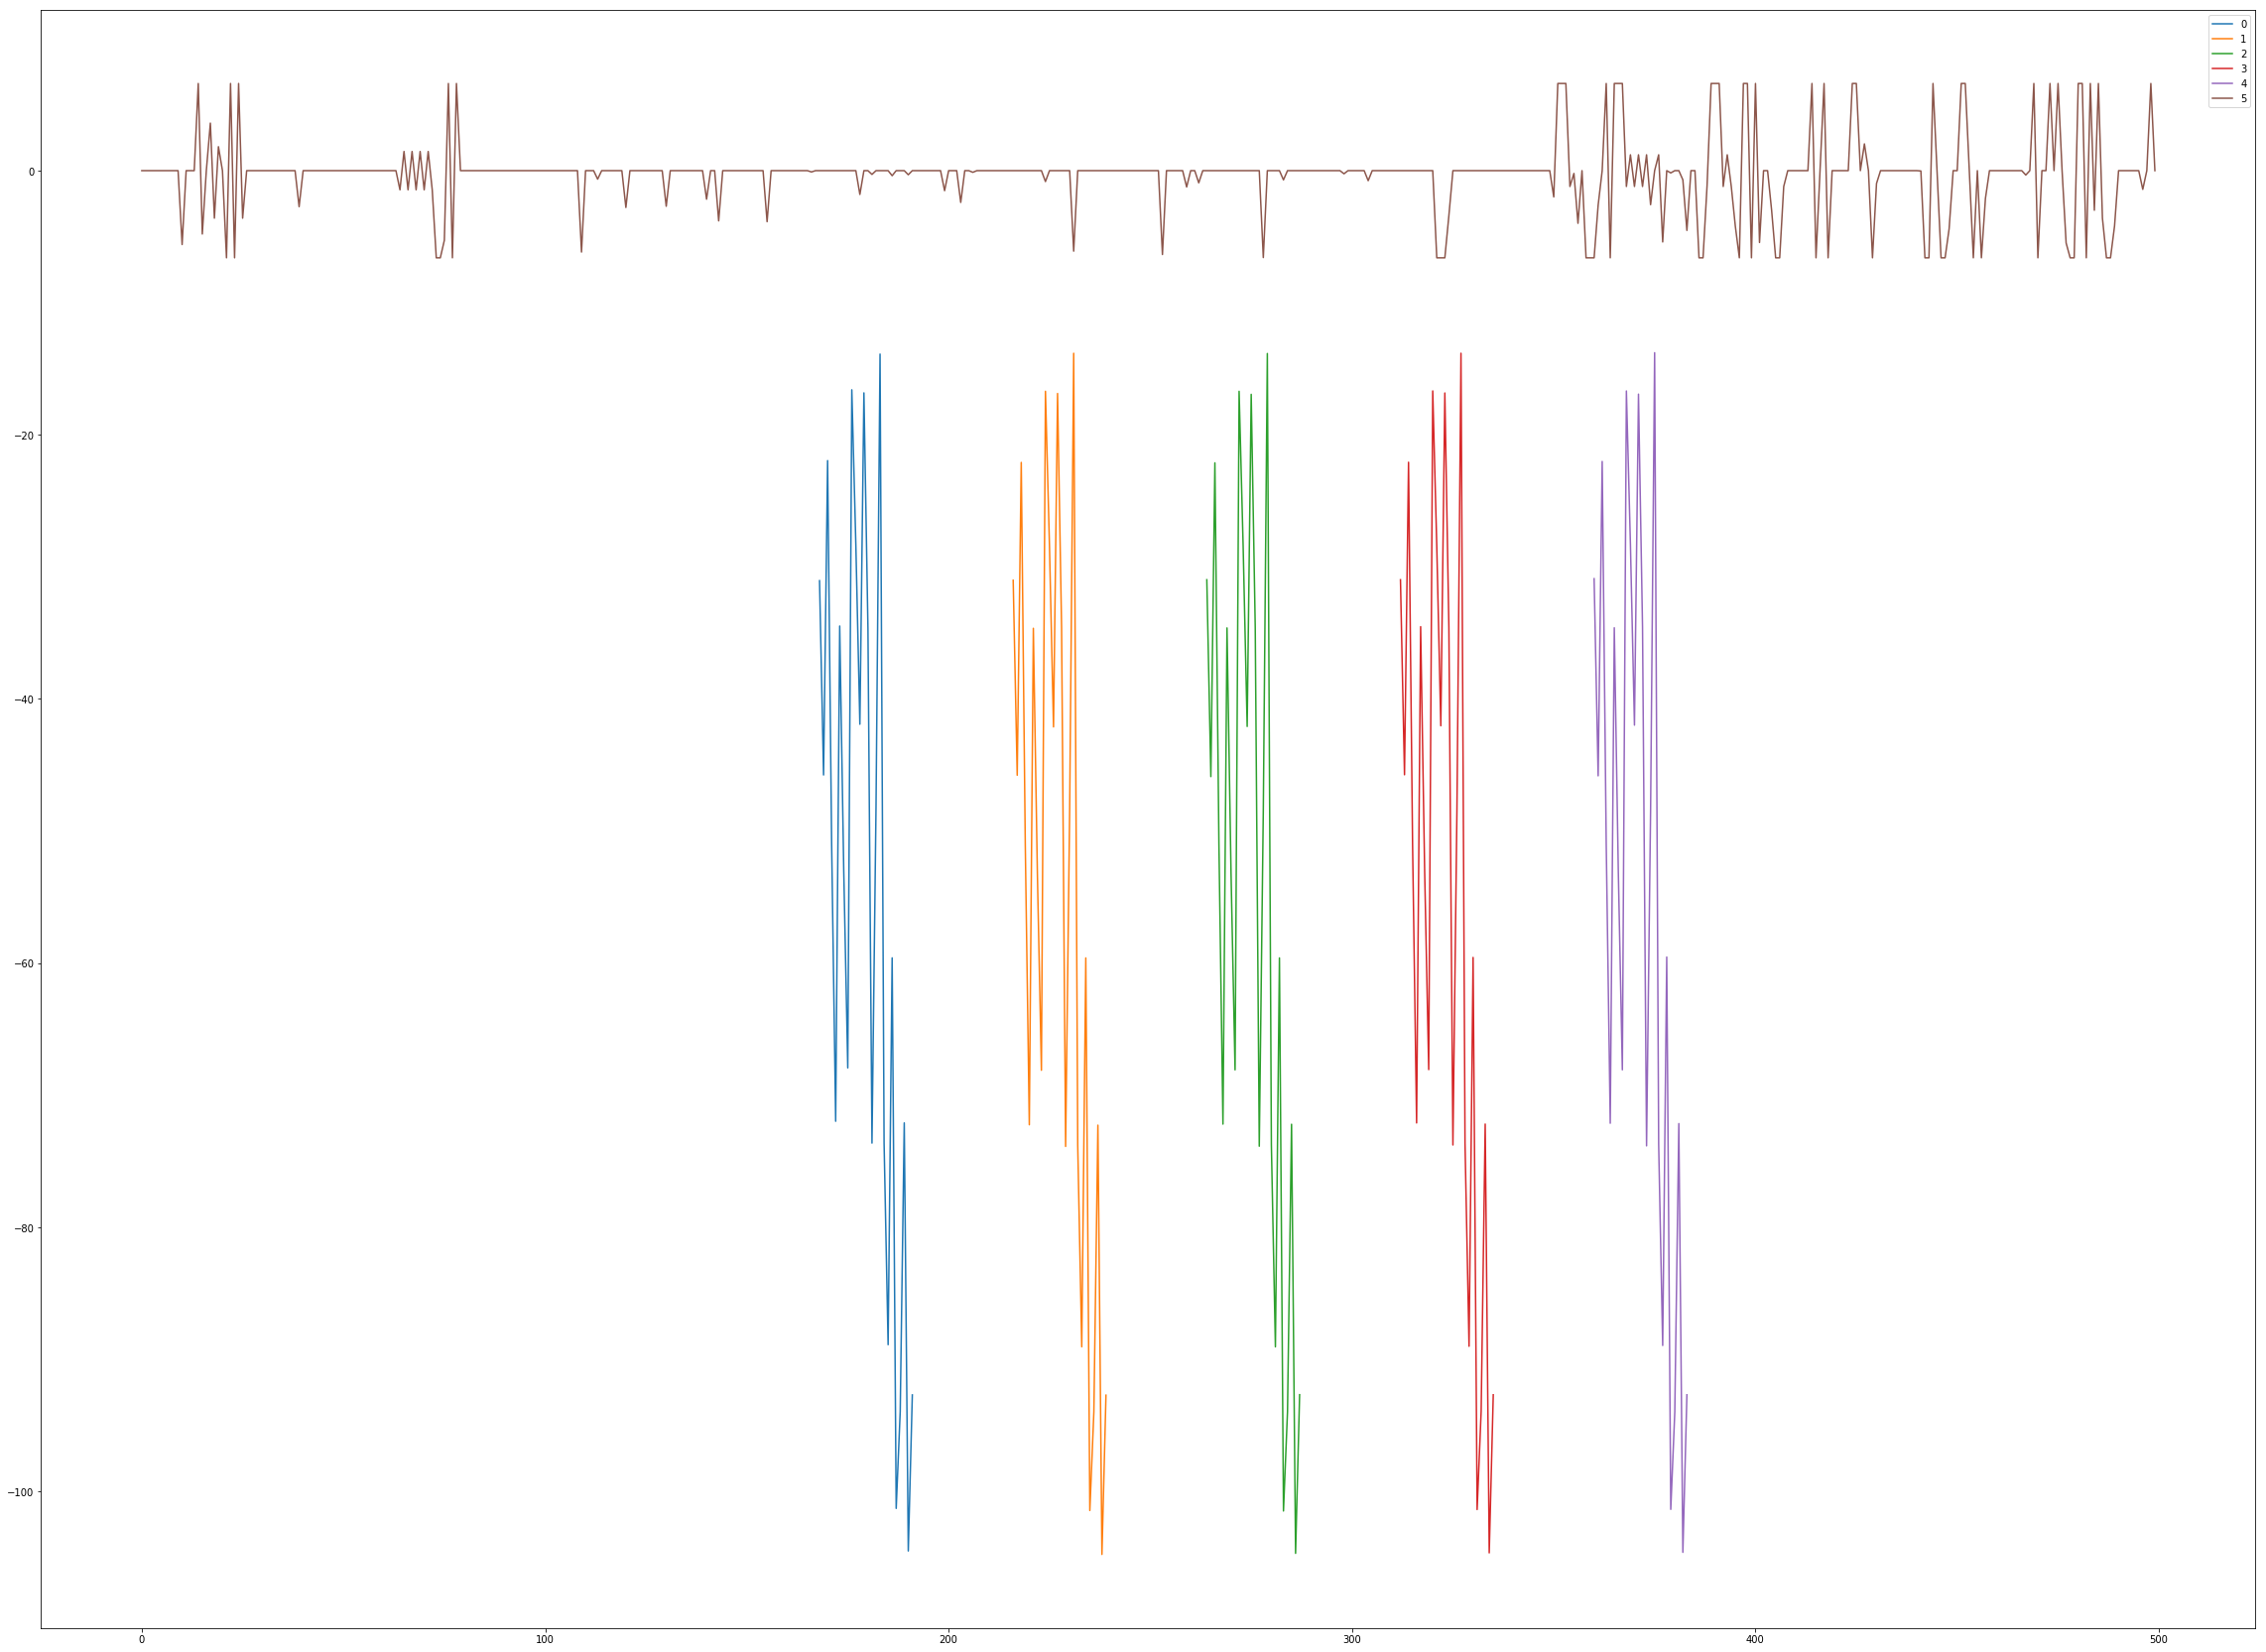

In [22]:
gen, base_data, scaler = get_gen_and_data(customer='MiddleIncome-3_15', flatten=True)
model3.fit_generator(gen, epochs=20)
df_d = plot_for_model(model3, flatten=True)

Doing really bad. What if the model is fresh?

Epoch 1/30
147/147 [==============================] - 1s 4ms/step - loss: 8.5614
Epoch 2/30
147/147 [==============================] - 0s 3ms/step - loss: 8.3522
Epoch 3/30
147/147 [==============================] - 0s 3ms/step - loss: 8.0842
Epoch 4/30
147/147 [==============================] - 0s 3ms/step - loss: 7.7097
Epoch 5/30
147/147 [==============================] - 0s 3ms/step - loss: 7.3288
Epoch 6/30
147/147 [==============================] - 0s 3ms/step - loss: 6.9194
Epoch 7/30
147/147 [==============================] - 0s 3ms/step - loss: 6.5698
Epoch 8/30
147/147 [==============================] - 0s 3ms/step - loss: 6.2462
Epoch 9/30
147/147 [==============================] - 0s 3ms/step - loss: 5.9614
Epoch 10/30
147/147 [==============================] - 0s 3ms/step - loss: 5.6481
Epoch 11/30
147/147 [==============================] - 0s 3ms/step - loss: 5.3941
Epoch 12/30
147/147 [==============================] - 0s 3ms/step - loss: 5.1799
Epoch 13/30
147/147 [====

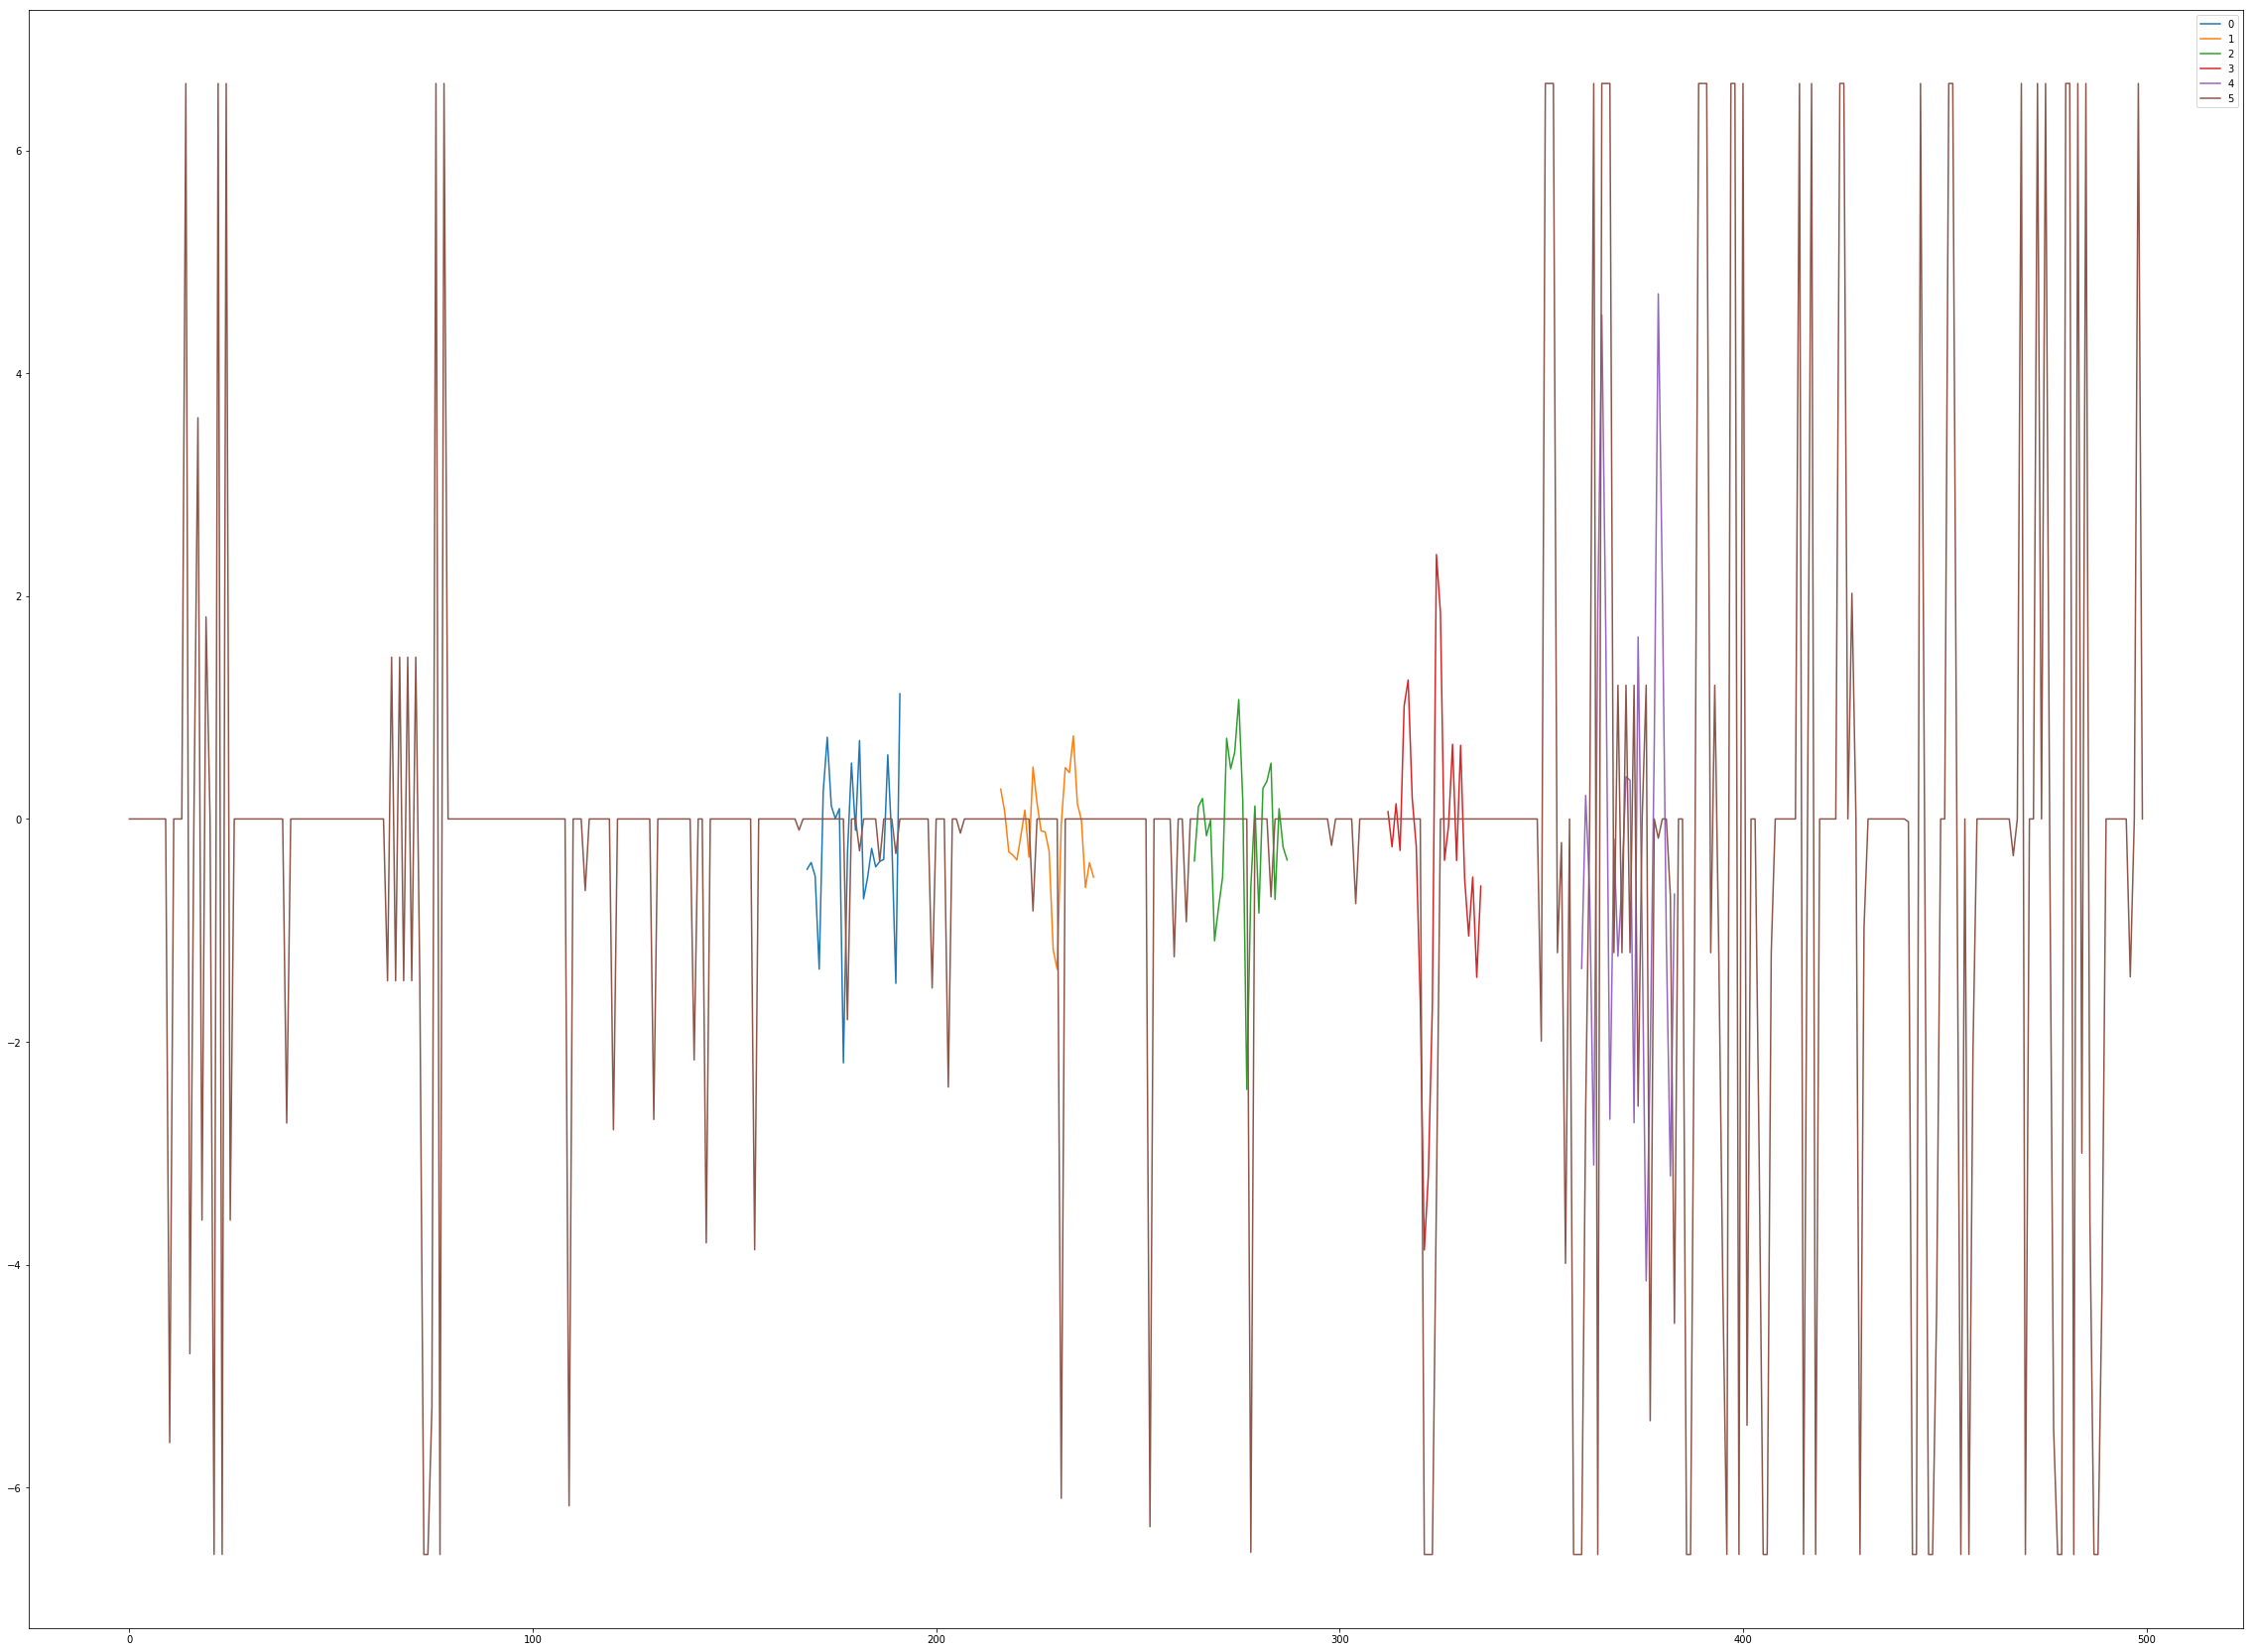

In [23]:
model4 = Sequential()
# input layer
input_shape = (cfg.DEMAND_ONE_WEEK,)
model4.add(Dense(168, input_shape=input_shape, activation='relu'))
model4.add(Dense(100, activation='relu'))
model4.add(Dense(100, activation='relu'))
model4.add(Dense(50, activation='relu'))
model4.add(Dense(50, activation='relu'))
model4.add(Dense(24))
model4.add(Activation('linear'))
model4.compile(loss='mse', optimizer='rmsprop')

gen, base_data, scaler = get_gen_and_data(preprocessing='none', customer='MiddleIncome-3_15', flatten=True)
model4.fit_generator(gen, epochs=30)
df_d = plot_for_model(model4, flatten=True)



Okay. This is obviously a problem! The network is having big troubles getting both huge customers and very small customers to be predicted well. The StandardScaler/MinMax Scaler both cannot really handle both large and small customers together.

2 Alternatives:
1. unique model for different customer classes (extrma would be a unique model for each customer)
2. somehow normalize the data more adequately (maybe inside the model)

Epoch 1/30
147/147 [==============================] - 1s 5ms/step - loss: 7.1672e-04
Epoch 2/30
147/147 [==============================] - 0s 3ms/step - loss: 2.0915e-04
Epoch 3/30
147/147 [==============================] - 1s 3ms/step - loss: 1.8118e-04
Epoch 4/30
147/147 [==============================] - 0s 3ms/step - loss: 1.5922e-04
Epoch 5/30
147/147 [==============================] - 0s 3ms/step - loss: 1.4977e-04
Epoch 6/30
147/147 [==============================] - 0s 3ms/step - loss: 1.4239e-04
Epoch 7/30
147/147 [==============================] - 0s 3ms/step - loss: 1.4073e-04
Epoch 8/30
147/147 [==============================] - 1s 4ms/step - loss: 1.2955e-04
Epoch 9/30
147/147 [==============================] - 1s 4ms/step - loss: 1.2434e-04
Epoch 10/30
147/147 [==============================] - 1s 3ms/step - loss: 1.1328e-04
Epoch 11/30
147/147 [==============================] - 0s 3ms/step - loss: 1.0419e-04
Epoch 12/30
147/147 [==============================] - 0s 3ms/s

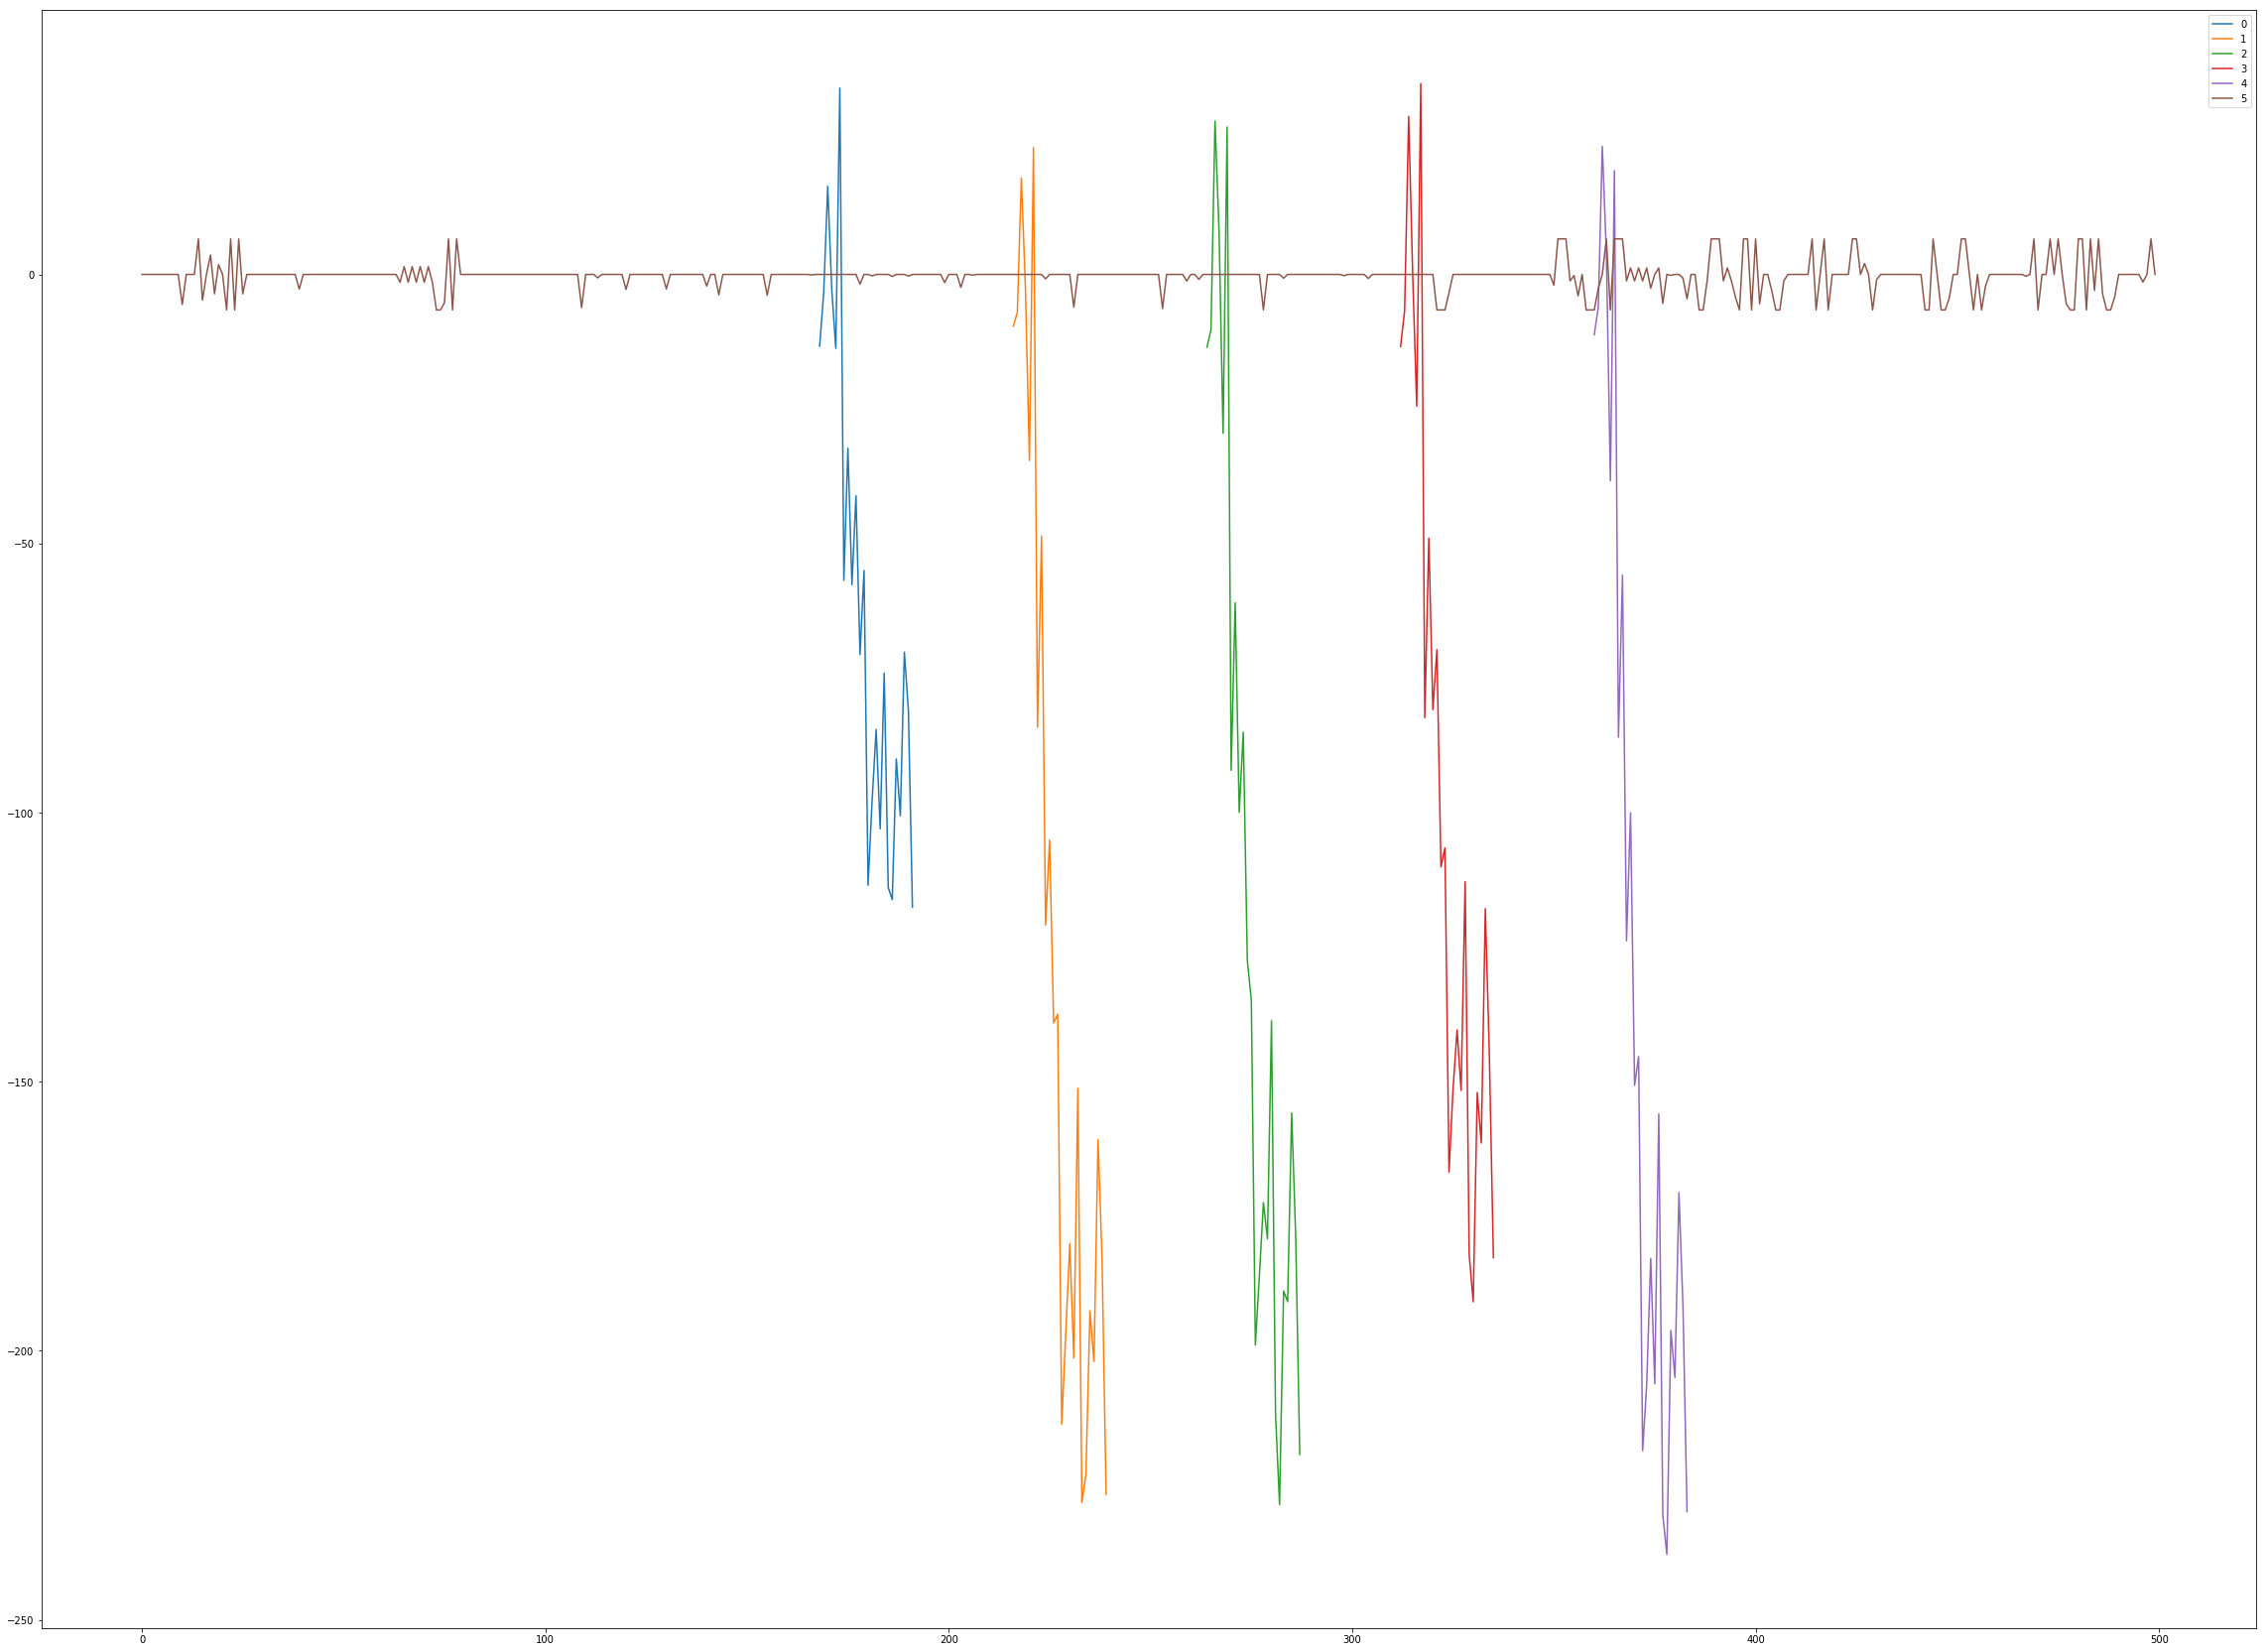

In [17]:
from keras.layers import BatchNormalization

model5 = Sequential()
# input layer
input_shape = (cfg.DEMAND_ONE_WEEK,)
model5.add(Dense(168, input_shape=input_shape, activation='relu'))
model5.add(BatchNormalization()) #applying batch normalization now
model5.add(Dense(100, activation='relu'))
model5.add(Dense(100, activation='relu'))
model5.add(Dense(50, activation='relu'))
model5.add(Dense(50, activation='relu'))
model5.add(Dense(24))
model5.add(Activation('linear'))
model5.compile(loss='mse', optimizer='rmsprop')

gen, base_data, scaler = get_gen_and_data(preprocessing='standard', customer='MiddleIncome-3_15', flatten=True)
model5.fit_generator(gen, epochs=30)
df_d = plot_for_model(model5, flatten=True)

Epoch 1/30
147/147 [==============================] - 0s 3ms/step - loss: 8.9477
Epoch 2/30
147/147 [==============================] - 1s 4ms/step - loss: 4.6675
Epoch 3/30
147/147 [==============================] - 1s 4ms/step - loss: 3.8679
Epoch 4/30
147/147 [==============================] - 0s 3ms/step - loss: 3.3656
Epoch 5/30
147/147 [==============================] - 1s 4ms/step - loss: 2.9579
Epoch 6/30
147/147 [==============================] - 1s 5ms/step - loss: 2.7343
Epoch 7/30
147/147 [==============================] - 0s 3ms/step - loss: 2.5054
Epoch 8/30
147/147 [==============================] - 0s 3ms/step - loss: 2.3043
Epoch 9/30
147/147 [==============================] - 0s 3ms/step - loss: 2.2150
Epoch 10/30
147/147 [==============================] - 0s 3ms/step - loss: 2.0729
Epoch 11/30
147/147 [==============================] - 1s 4ms/step - loss: 1.9395
Epoch 12/30
147/147 [==============================] - 1s 6ms/step - loss: 1.8859
Epoch 13/30
147/147 [====

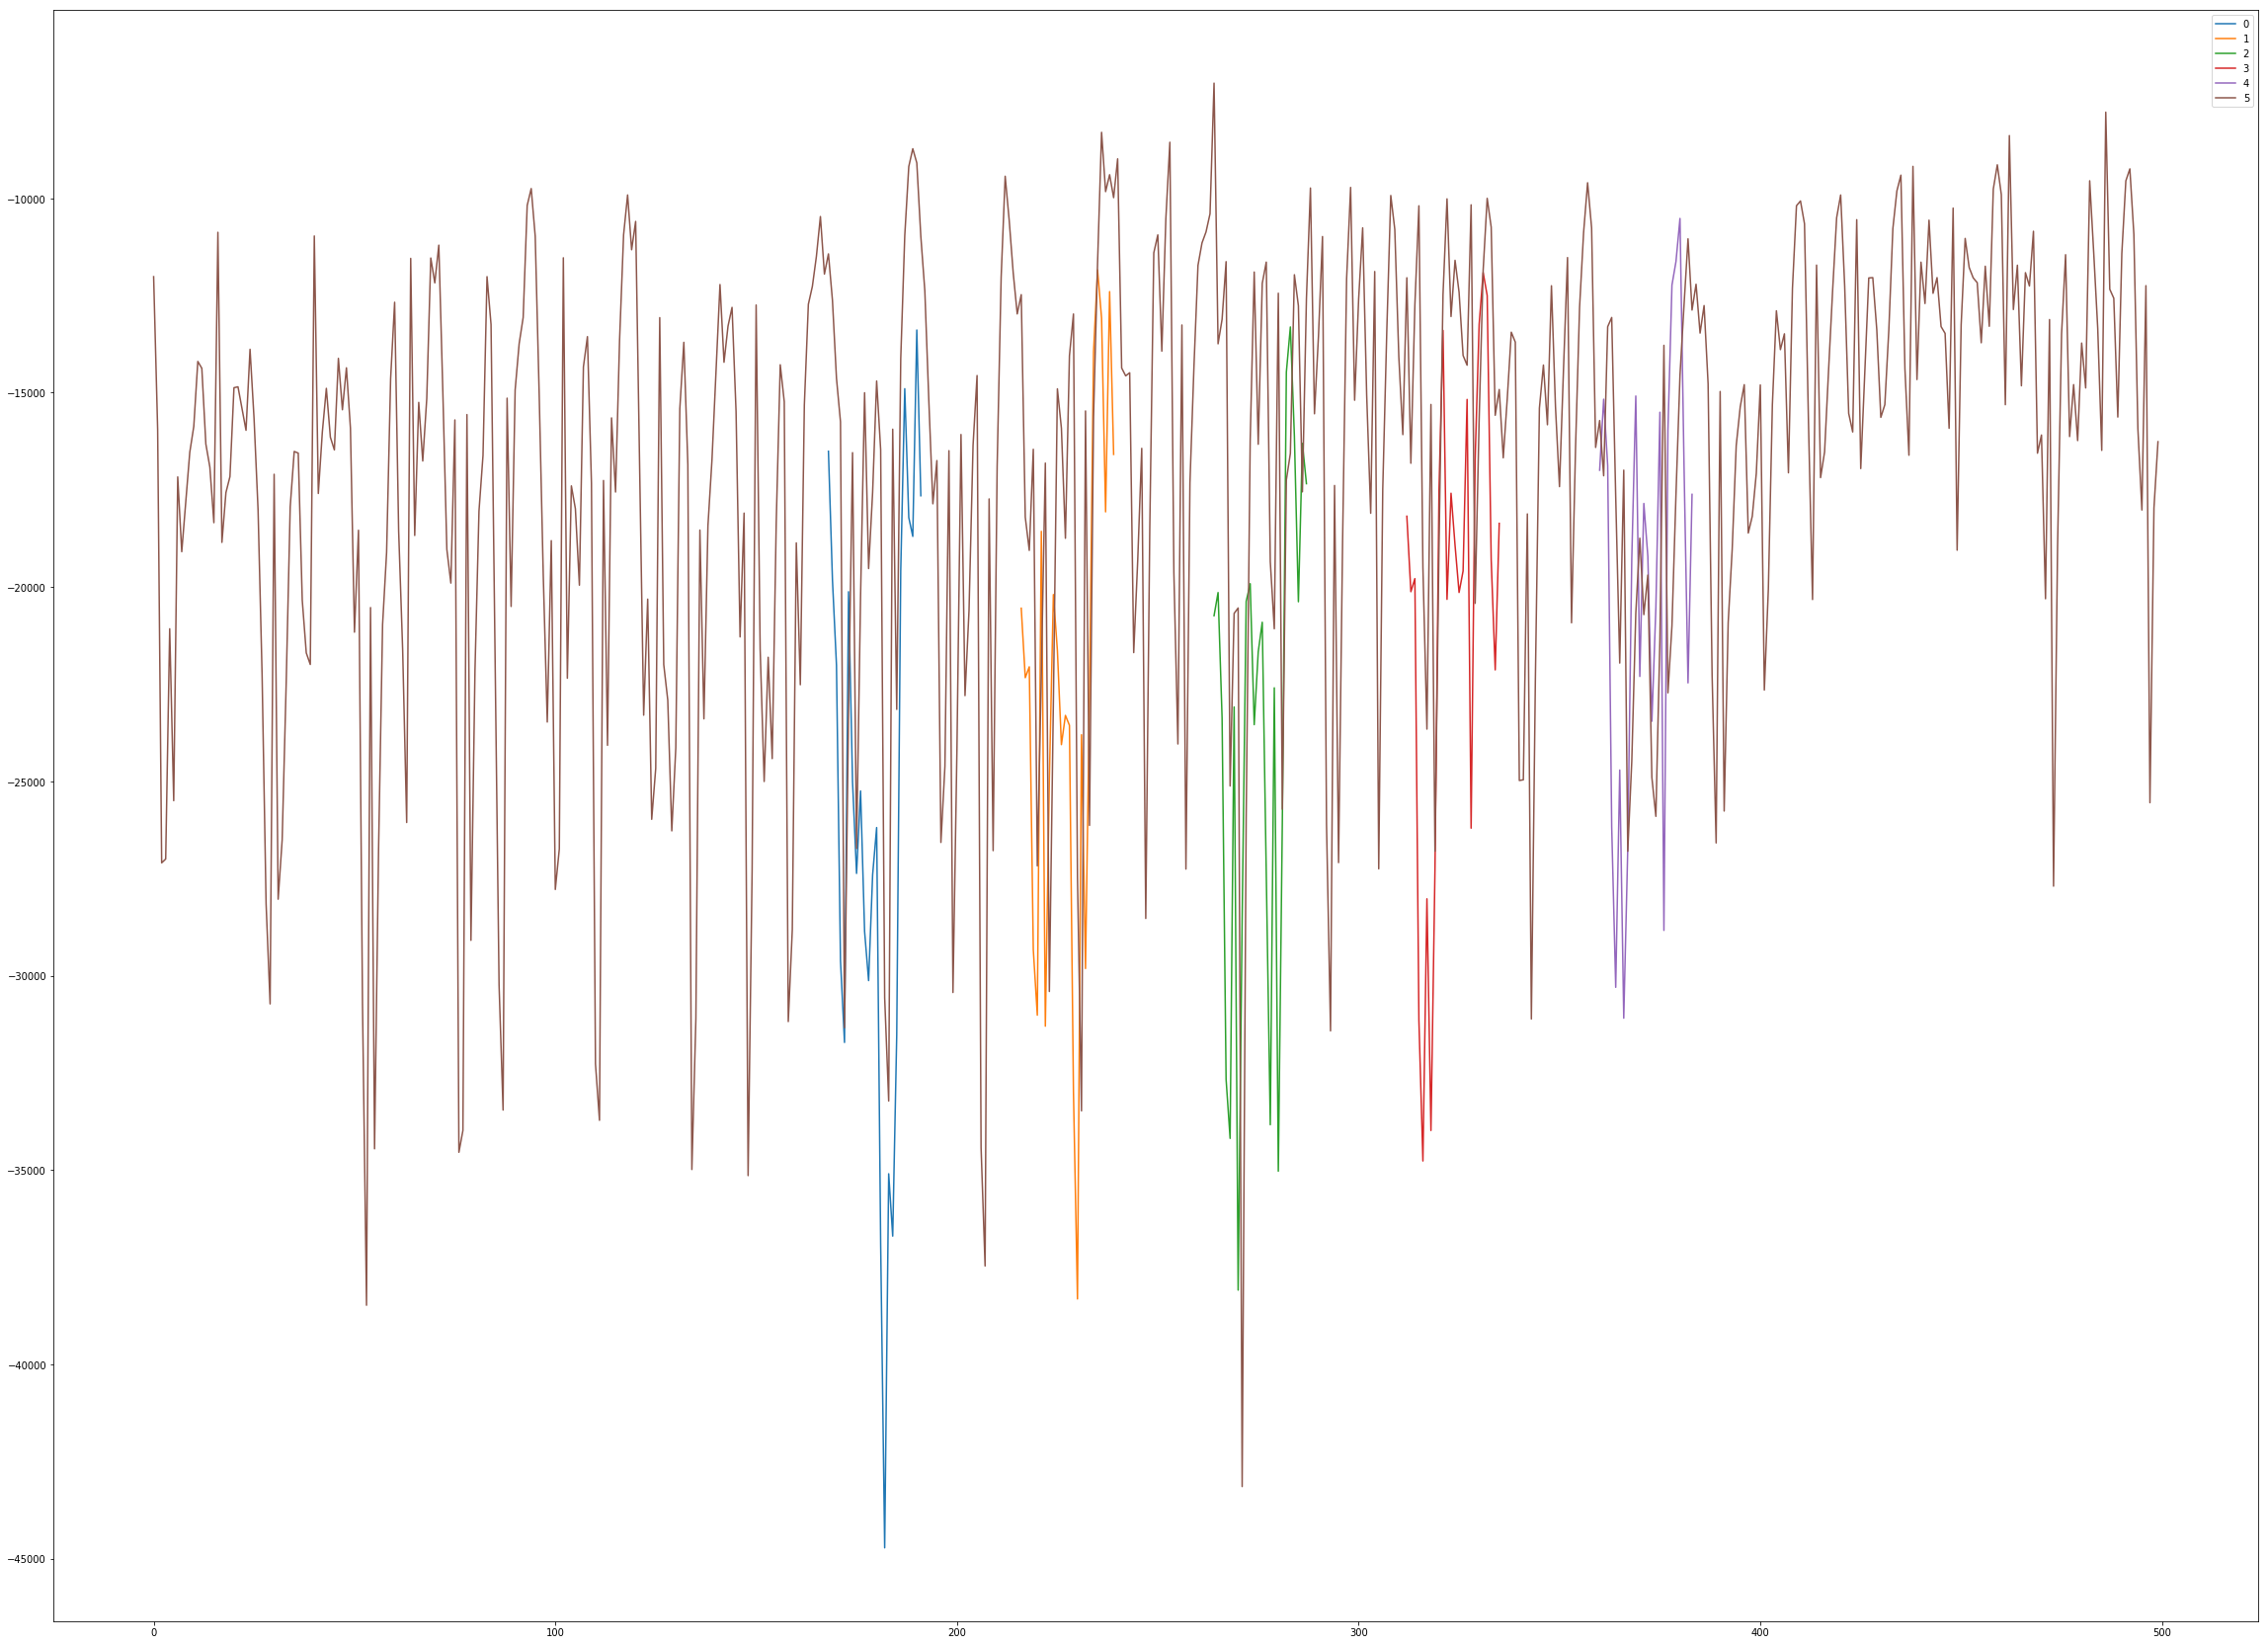

In [18]:
gen, base_data, scaler = get_gen_and_data(preprocessing='standard', flatten=True)
model5.fit_generator(gen, epochs=30)
df_d = plot_for_model(model5, flatten=True)

Normalization alone doesn't seem to be doing anything helpful. Let's try a different scaler, the RobustScaler which is robust against outliers while still being linear

In [25]:
from keras.layers import BatchNormalization

model6 = Sequential()
# input layer
input_shape = (cfg.DEMAND_ONE_WEEK,)
model6.add(Dense(168, input_shape=input_shape, activation='relu'))
model6.add(BatchNormalization())
model6.add(Dense(100, activation='relu'))
model6.add(Dense(100, activation='relu'))
model6.add(Dense(50, activation='relu'))
model6.add(Dense(50, activation='relu'))
model6.add(Dense(24))
model6.add(Activation('linear'))
model6.compile(loss='mse', optimizer='rmsprop')



In [27]:
gen, base_data, scaler = get_gen_and_data(preprocessing="robust", customer='MiddleIncome-3_15', flatten=True)
model6.fit_generator(gen, epochs=30)

Epoch 1/30
147/147 [==============================] - 0s 3ms/step - loss: 0.6277
Epoch 2/30
147/147 [==============================] - 0s 3ms/step - loss: 0.5889
Epoch 3/30
147/147 [==============================] - 1s 3ms/step - loss: 0.5544
Epoch 4/30
147/147 [==============================] - 1s 4ms/step - loss: 0.5213
Epoch 5/30
147/147 [==============================] - 1s 3ms/step - loss: 0.4946
Epoch 6/30
147/147 [==============================] - 0s 3ms/step - loss: 0.4691
Epoch 7/30
147/147 [==============================] - 0s 3ms/step - loss: 0.4461
Epoch 8/30
147/147 [==============================] - 1s 3ms/step - loss: 0.4286
Epoch 9/30
147/147 [==============================] - 1s 4ms/step - loss: 0.4084
Epoch 10/30
147/147 [==============================] - 1s 4ms/step - loss: 0.3923
Epoch 11/30
147/147 [==============================] - 0s 3ms/step - loss: 0.3791
Epoch 12/30
147/147 [==============================] - 0s 3ms/step - loss: 0.3647
Epoch 13/30
147/147 [====

(500, 6)


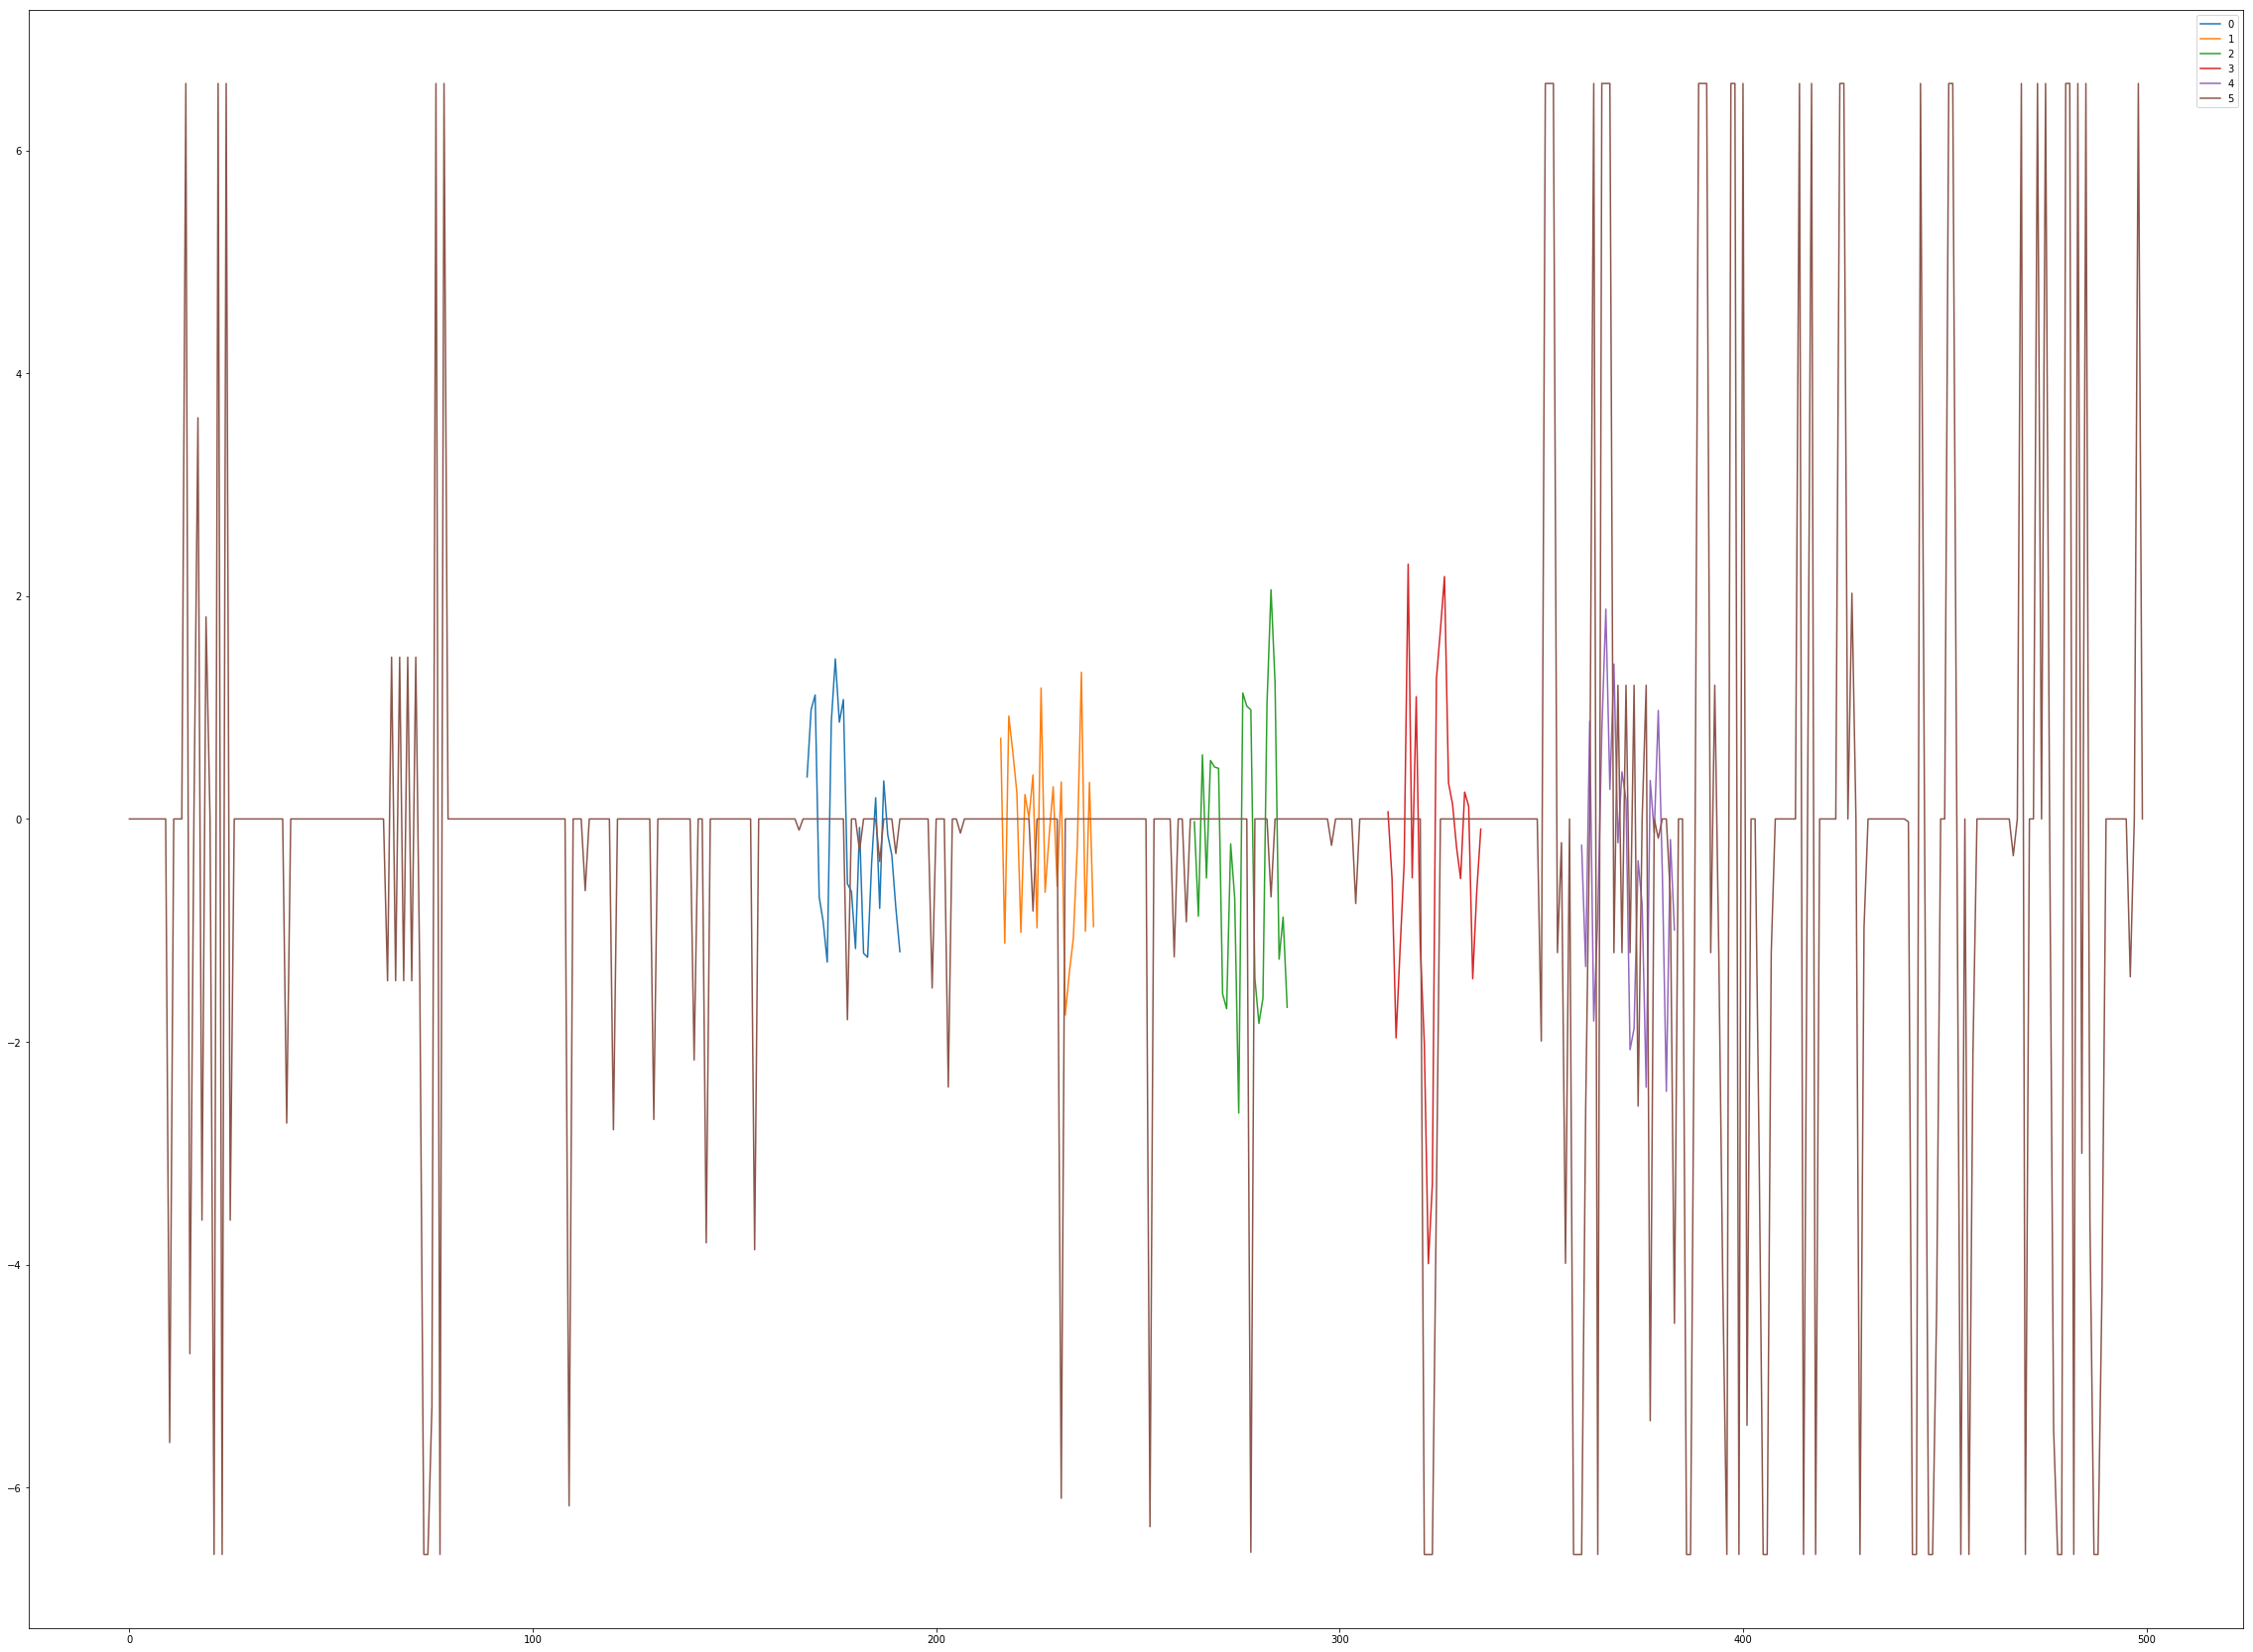

In [28]:
df_d = plot_for_model(model6, flatten=True)

In [29]:
gen, base_data, scaler = get_gen_and_data(preprocessing="robust", flatten=True)
model6.fit_generator(gen, epochs=30)


Epoch 1/30
147/147 [==============================] - 0s 3ms/step - loss: 11862609.8727
Epoch 2/30
147/147 [==============================] - 1s 3ms/step - loss: 3927868.8231
Epoch 3/30
147/147 [==============================] - 0s 3ms/step - loss: 3829851.0047
Epoch 4/30
147/147 [==============================] - 1s 4ms/step - loss: 3759782.8239
Epoch 5/30
147/147 [==============================] - 0s 3ms/step - loss: 3747490.4037
Epoch 6/30
147/147 [==============================] - 0s 3ms/step - loss: 3683569.4672
Epoch 7/30
147/147 [==============================] - 0s 3ms/step - loss: 3627751.6393
Epoch 8/30
147/147 [==============================] - 1s 4ms/step - loss: 3512642.8080
Epoch 9/30
147/147 [==============================] - 0s 3ms/step - loss: 3451198.1969
Epoch 10/30
147/147 [==============================] - 0s 3ms/step - loss: 3249628.8872
Epoch 11/30
147/147 [==============================] - 0s 3ms/step - loss: 3086995.1785
Epoch 12/30
147/147 [===================

(500, 6)


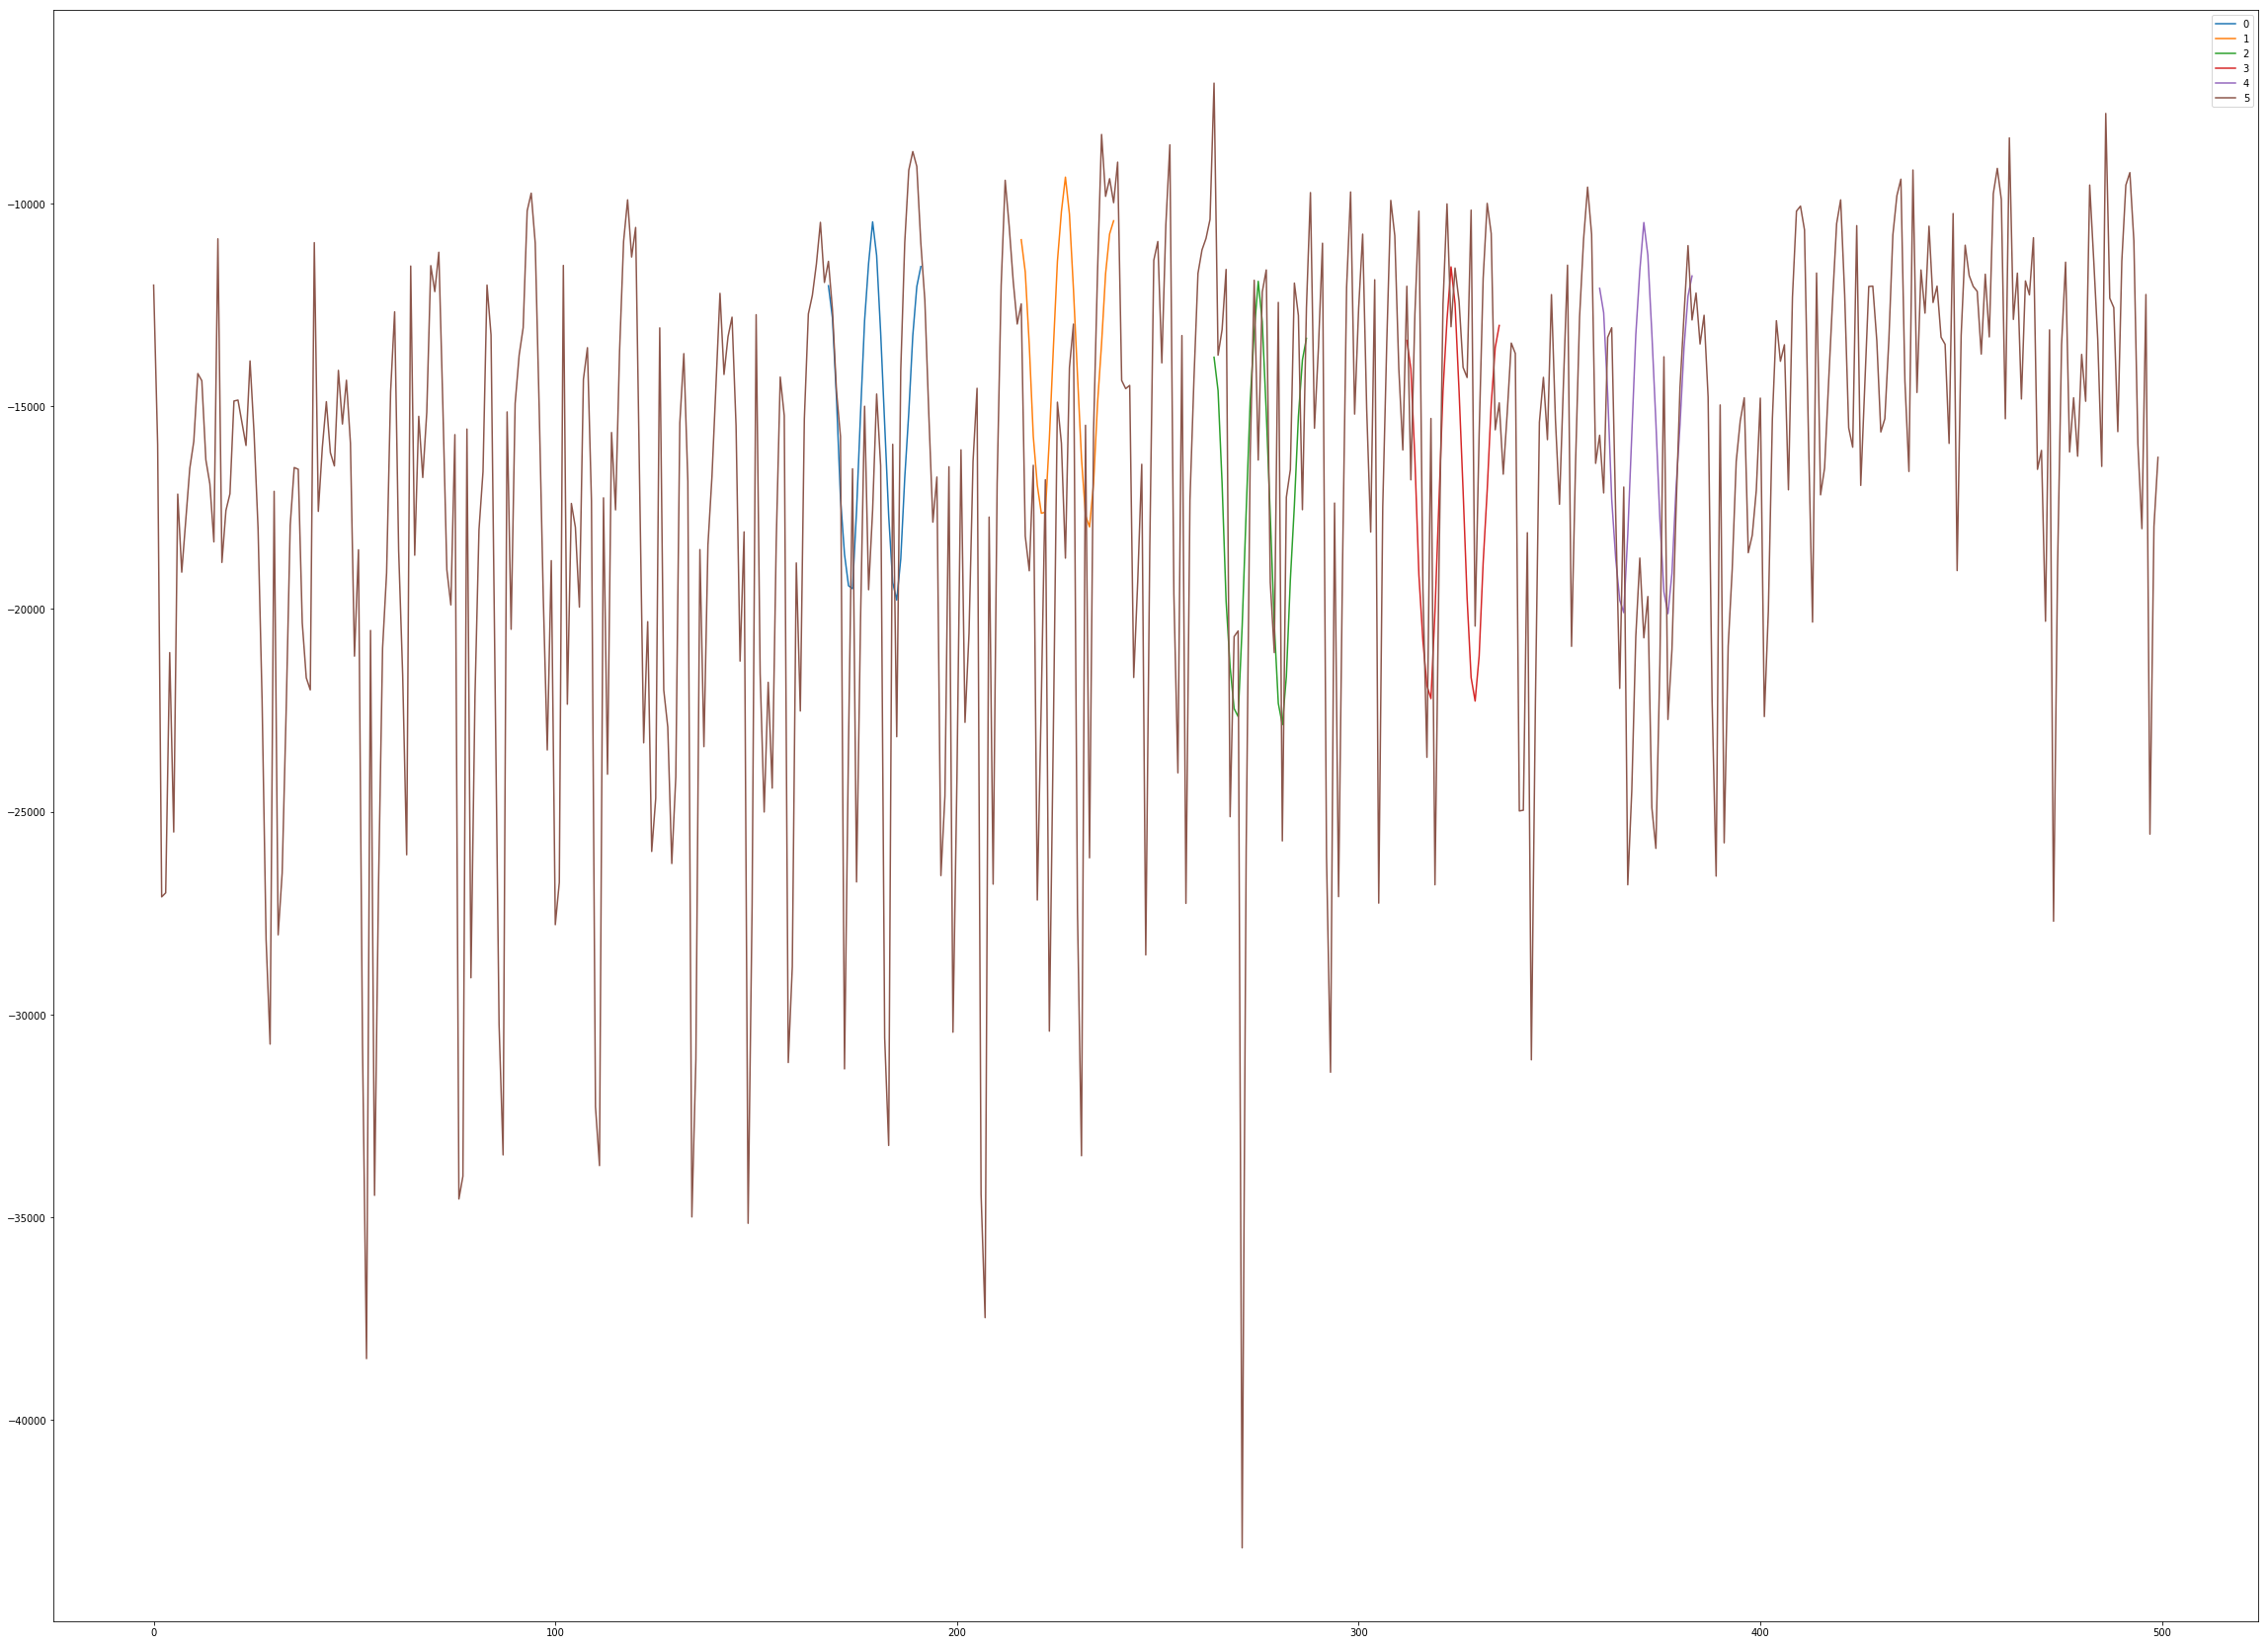

In [30]:
df_d = plot_for_model(model6, flatten=True)

Epoch 1/20
147/147 [==============================] - 0s 3ms/step - loss: 825410.0554
Epoch 2/20
147/147 [==============================] - 0s 3ms/step - loss: 648133.5902
Epoch 3/20
147/147 [==============================] - 1s 4ms/step - loss: 572197.3666
Epoch 4/20
147/147 [==============================] - 1s 4ms/step - loss: 468802.8200
Epoch 5/20
147/147 [==============================] - 0s 3ms/step - loss: 323023.5396
Epoch 6/20
147/147 [==============================] - 1s 4ms/step - loss: 210452.4536
Epoch 7/20
147/147 [==============================] - 1s 4ms/step - loss: 157110.8615
Epoch 8/20
147/147 [==============================] - 1s 3ms/step - loss: 129864.5344
Epoch 9/20
147/147 [==============================] - 1s 3ms/step - loss: 121645.2890
Epoch 10/20
147/147 [==============================] - 1s 3ms/step - loss: 113887.6097
Epoch 11/20
147/147 [==============================] - 1s 4ms/step - loss: 105606.1631
Epoch 12/20
147/147 [==============================]

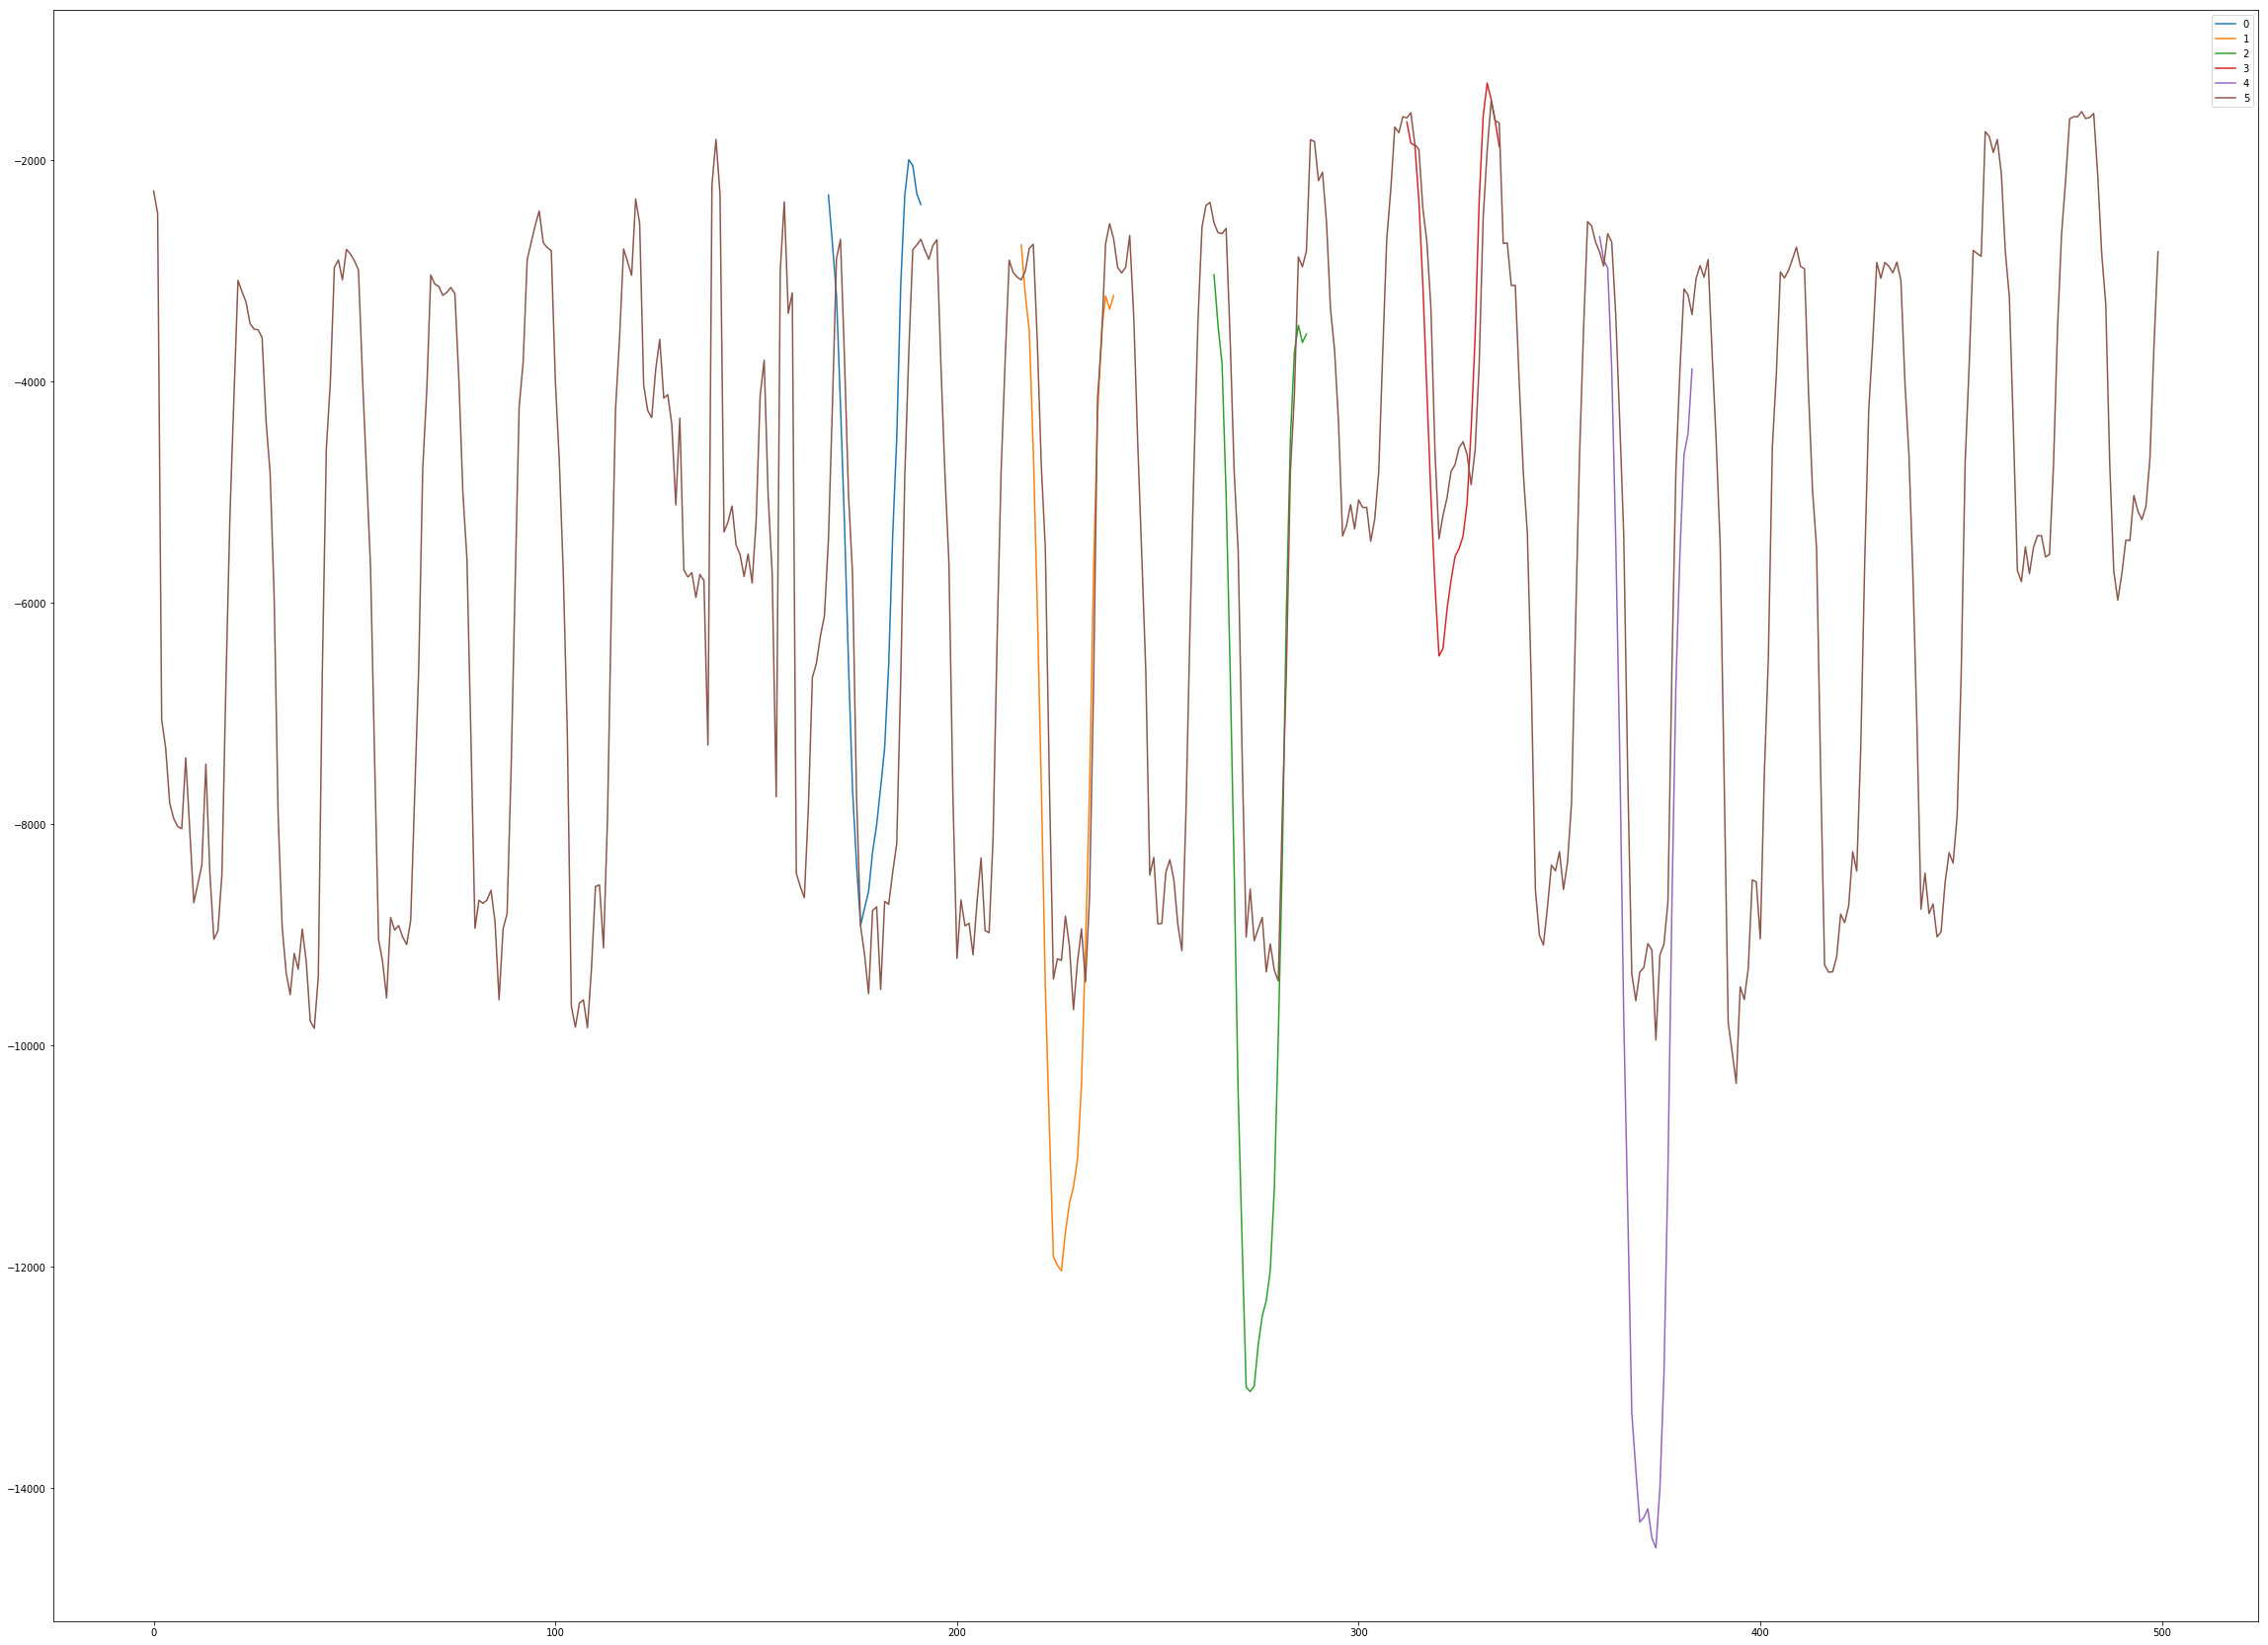

In [31]:
gen, base_data, scaler = get_gen_and_data(preprocessing="robust", customer='EastsideOffices', flatten=True)
model6.fit_generator(gen, epochs=20)
df_d = plot_for_model(model6, flatten=True)

Okay this seems to be doing alright for all kinds, but it is not perfect. Largely overestimating the peaks of the offices. However, it was still in the process of learning so another few rounds might solve that. 

Epoch 1/20
147/147 [==============================] - 0s 3ms/step - loss: 75859.4662
Epoch 2/20
147/147 [==============================] - 0s 3ms/step - loss: 73977.6690
Epoch 3/20
147/147 [==============================] - 0s 3ms/step - loss: 73127.3127
Epoch 4/20
147/147 [==============================] - 0s 3ms/step - loss: 70656.7474
Epoch 5/20
147/147 [==============================] - 1s 3ms/step - loss: 68025.2806
Epoch 6/20
147/147 [==============================] - 0s 3ms/step - loss: 71036.4580
Epoch 7/20
147/147 [==============================] - 1s 4ms/step - loss: 70158.2586
Epoch 8/20
147/147 [==============================] - 1s 4ms/step - loss: 65453.8312
Epoch 9/20
147/147 [==============================] - 0s 3ms/step - loss: 64979.9985
Epoch 10/20
147/147 [==============================] - 1s 4ms/step - loss: 64126.3901
Epoch 11/20
147/147 [==============================] - 1s 4ms/step - loss: 64562.9334
Epoch 12/20
147/147 [==============================] - 0s 3ms/s

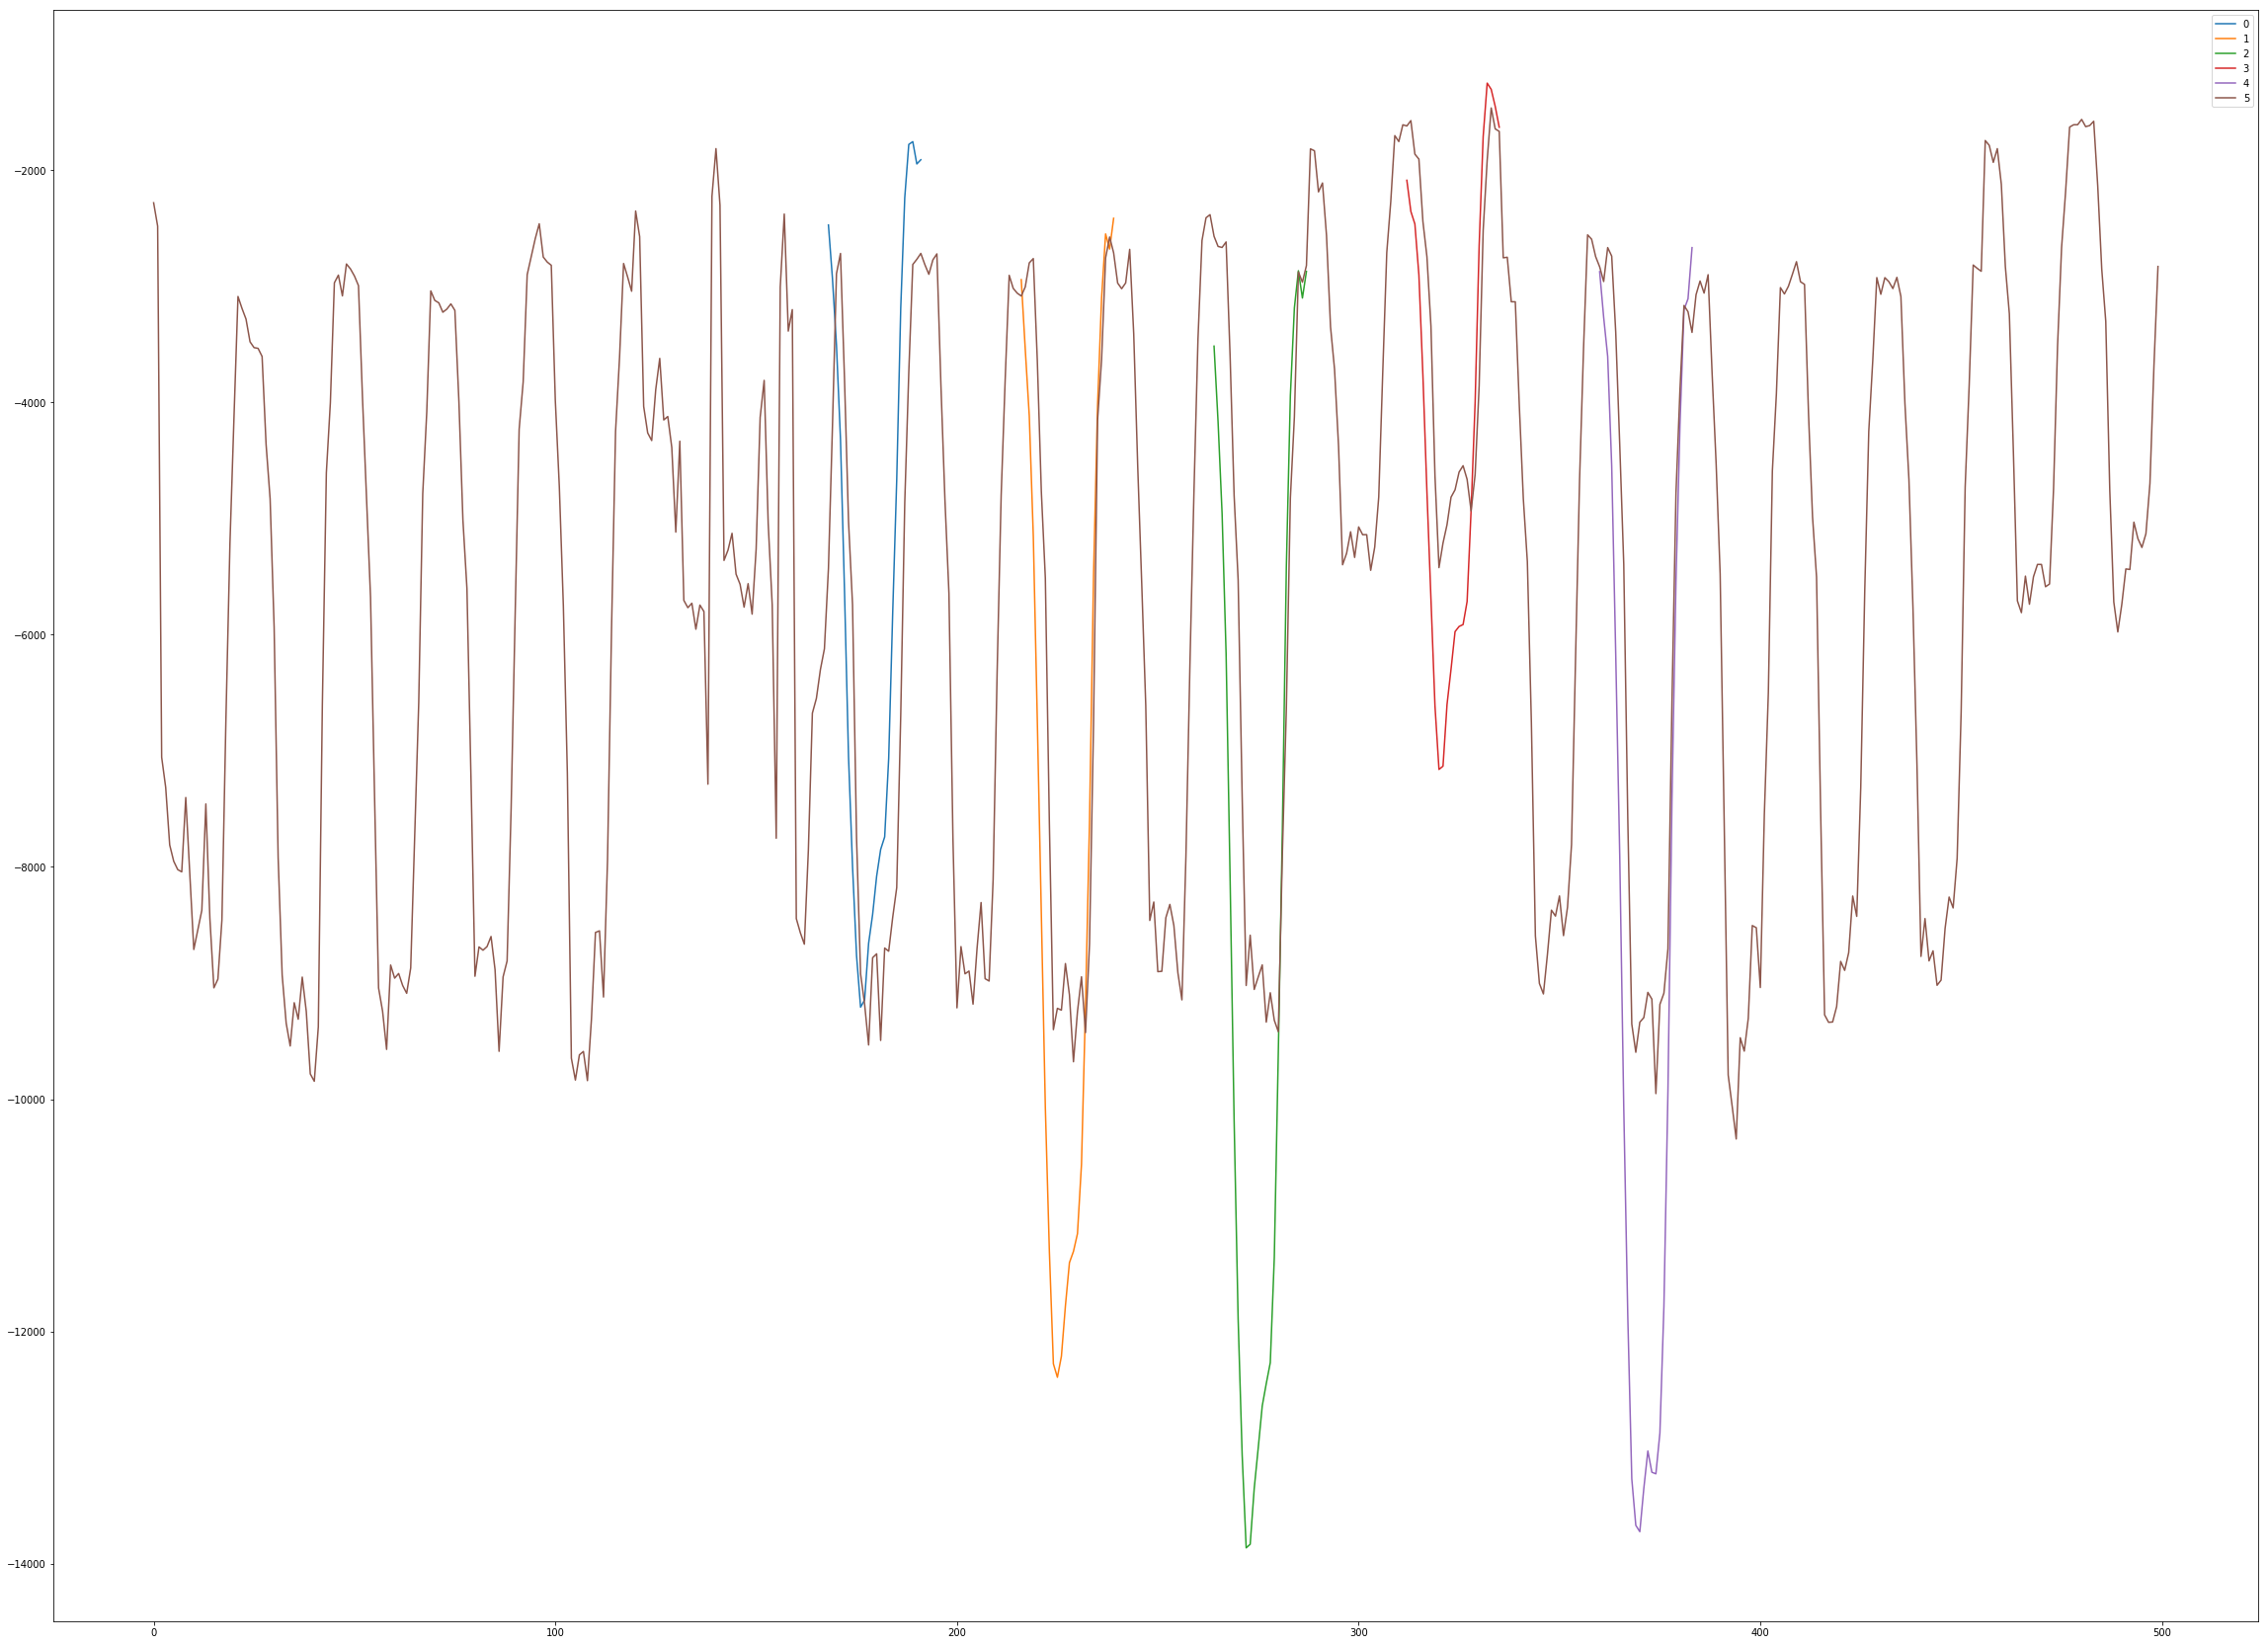

In [32]:
gen, base_data, scaler = get_gen_and_data(preprocessing="robust", customer='EastsideOffices', flatten=True)
model6.fit_generator(gen, epochs=20)
df_d = plot_for_model(model6, flatten=True)

Slowly, but it is getting there. Let's train the model on a whole collection of customers for 10 epochs and then predict a few. 

### Applying the model to a whole game

In [41]:
from util.learning_utils import get_tb_cb
tb_cb = get_tb_cb('jupyter_dense_v7')

In [37]:
model7 = Sequential()
# input layer
input_shape = (cfg.DEMAND_ONE_WEEK,)
model7.add(Dense(168, input_shape=input_shape, activation='relu'))
model7.add(BatchNormalization())
model7.add(Dense(100, activation='relu'))
model7.add(Dense(100, activation='relu'))
model7.add(Dense(50, activation='relu'))
model7.add(Dense(50, activation='relu'))
model7.add(Dense(24))
model7.add(Activation('linear'))
model7.compile(loss='mse', optimizer='rmsprop')


In [34]:
clear() #clears data
d, scaler = parse_usage_game_log(f, pp_type='robust')

In [42]:
sequences = make_sequences_from_historical(True, scaler)
for s in sequences:
    # before
    model7.fit_generator(s, epochs=10, callbacks=[tb_cb])

Epoch 1/10
147/147 [==============================] - 0s 3ms/step - loss: 5.1066
Epoch 2/10
147/147 [==============================] - 1s 5ms/step - loss: 4.4814
Epoch 3/10
147/147 [==============================] - 0s 3ms/step - loss: 3.8887
Epoch 4/10
147/147 [==============================] - 1s 4ms/step - loss: 3.3389
Epoch 5/10
147/147 [==============================] - 1s 3ms/step - loss: 2.8327
Epoch 6/10
147/147 [==============================] - 0s 3ms/step - loss: 2.3692
Epoch 7/10
147/147 [==============================] - 1s 3ms/step - loss: 1.9493
Epoch 8/10
147/147 [==============================] - 1s 4ms/step - loss: 1.5718
Epoch 9/10
147/147 [==============================] - 0s 3ms/step - loss: 1.2381
Epoch 10/10
147/147 [==============================] - 1s 4ms/step - loss: 0.9454
Epoch 1/10
147/147 [==============================] - 0s 3ms/step - loss: 0.6573
Epoch 2/10
147/147 [==============================] - 1s 4ms/step - loss: 0.4446
Epoch 3/10
147/147 [=======

147/147 [==============================] - 0s 3ms/step - loss: 2.0954
Epoch 2/10
147/147 [==============================] - 1s 4ms/step - loss: 1.1064
Epoch 3/10
147/147 [==============================] - 1s 5ms/step - loss: 0.8501
Epoch 4/10
147/147 [==============================] - 1s 4ms/step - loss: 0.7236
Epoch 5/10
147/147 [==============================] - 1s 7ms/step - loss: 0.6428
Epoch 6/10
147/147 [==============================] - 1s 4ms/step - loss: 0.5846
Epoch 7/10
147/147 [==============================] - 0s 3ms/step - loss: 0.5416
Epoch 8/10
147/147 [==============================] - 1s 4ms/step - loss: 0.5019
Epoch 9/10
147/147 [==============================] - 1s 6ms/step - loss: 0.4735
Epoch 10/10
147/147 [==============================] - 1s 5ms/step - loss: 0.4577
Epoch 1/10
147/147 [==============================] - 1s 4ms/step - loss: 43.0345
Epoch 2/10
147/147 [==============================] - 1s 4ms/step - loss: 32.1701
Epoch 3/10
147/147 [================

147/147 [==============================] - 1s 4ms/step - loss: 0.1300
Epoch 3/10
147/147 [==============================] - 1s 3ms/step - loss: 0.1256
Epoch 4/10
147/147 [==============================] - 1s 5ms/step - loss: 0.1231
Epoch 5/10
147/147 [==============================] - 1s 4ms/step - loss: 0.1208
Epoch 6/10
147/147 [==============================] - 1s 4ms/step - loss: 0.1185
Epoch 7/10
147/147 [==============================] - 1s 4ms/step - loss: 0.1172
Epoch 8/10
147/147 [==============================] - 0s 3ms/step - loss: 0.1151
Epoch 9/10
147/147 [==============================] - 1s 4ms/step - loss: 0.1137
Epoch 10/10
147/147 [==============================] - 1s 4ms/step - loss: 0.1121
Epoch 1/10
147/147 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 2/10
147/147 [==============================] - 1s 4ms/step - loss: 0.0146
Epoch 3/10
147/147 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 4/10
147/147 [==================

147/147 [==============================] - 1s 5ms/step - loss: 0.3964
Epoch 3/10
147/147 [==============================] - 1s 3ms/step - loss: 0.3943
Epoch 4/10
147/147 [==============================] - 1s 3ms/step - loss: 0.3923
Epoch 5/10
147/147 [==============================] - 0s 3ms/step - loss: 0.3908
Epoch 6/10
147/147 [==============================] - 1s 5ms/step - loss: 0.3895
Epoch 7/10
147/147 [==============================] - 0s 3ms/step - loss: 0.3884
Epoch 8/10
147/147 [==============================] - 0s 3ms/step - loss: 0.3873
Epoch 9/10
147/147 [==============================] - 1s 4ms/step - loss: 0.3864
Epoch 10/10
147/147 [==============================] - 1s 4ms/step - loss: 0.3851
Epoch 1/10
147/147 [==============================] - 0s 2ms/step - loss: 0.2743
Epoch 2/10
147/147 [==============================] - 1s 7ms/step - loss: 0.2711
Epoch 3/10
147/147 [==============================] - 1s 5ms/step - loss: 0.2693
Epoch 4/10
147/147 [==================

147/147 [==============================] - 1s 4ms/step - loss: 2669413.6347
Epoch 3/10
147/147 [==============================] - 1s 4ms/step - loss: 2668811.2759
Epoch 4/10
147/147 [==============================] - 1s 5ms/step - loss: 2668343.3901
Epoch 5/10
147/147 [==============================] - 1s 4ms/step - loss: 2667885.8921
Epoch 6/10
147/147 [==============================] - 1s 4ms/step - loss: 2667430.4477
Epoch 7/10
147/147 [==============================] - 1s 5ms/step - loss: 2666972.8546
Epoch 8/10
147/147 [==============================] - 1s 3ms/step - loss: 2666517.2019
Epoch 9/10
147/147 [==============================] - 0s 3ms/step - loss: 2666062.5062
Epoch 10/10
147/147 [==============================] - 1s 4ms/step - loss: 2665606.1223
Epoch 1/10
147/147 [==============================] - 0s 2ms/step - loss: 13189.3030
Epoch 2/10
147/147 [==============================] - 0s 3ms/step - loss: 8099.8867
Epoch 3/10
147/147 [==============================] - 0s 3

147/147 [==============================] - 1s 7ms/step - loss: 0.7092
Epoch 3/10
147/147 [==============================] - 0s 3ms/step - loss: 0.7011
Epoch 4/10
147/147 [==============================] - 1s 4ms/step - loss: 0.6960
Epoch 5/10
147/147 [==============================] - 1s 5ms/step - loss: 0.6912
Epoch 6/10
147/147 [==============================] - 1s 5ms/step - loss: 0.6868
Epoch 7/10
147/147 [==============================] - 1s 5ms/step - loss: 0.6827
Epoch 8/10
147/147 [==============================] - 1s 6ms/step - loss: 0.6816
Epoch 9/10
147/147 [==============================] - 0s 3ms/step - loss: 0.6785
Epoch 10/10
147/147 [==============================] - 1s 6ms/step - loss: 0.6765
Epoch 1/10
147/147 [==============================] - 0s 2ms/step - loss: 0.0259
Epoch 2/10
147/147 [==============================] - 0s 3ms/step - loss: 0.0242
Epoch 3/10
147/147 [==============================] - 1s 5ms/step - loss: 0.0238
Epoch 4/10
147/147 [==================

147/147 [==============================] - 1s 3ms/step - loss: 0.4027
Epoch 4/10
147/147 [==============================] - 1s 5ms/step - loss: 0.3694
Epoch 5/10
147/147 [==============================] - 1s 5ms/step - loss: 0.3399
Epoch 6/10
147/147 [==============================] - 1s 3ms/step - loss: 0.3318
Epoch 7/10
147/147 [==============================] - 0s 3ms/step - loss: 0.3102
Epoch 8/10
147/147 [==============================] - 1s 3ms/step - loss: 0.2904
Epoch 9/10
147/147 [==============================] - 1s 4ms/step - loss: 0.2747
Epoch 10/10
147/147 [==============================] - 1s 7ms/step - loss: 0.2665
Epoch 1/10
147/147 [==============================] - 0s 3ms/step - loss: 29.8462
Epoch 2/10
147/147 [==============================] - 1s 4ms/step - loss: 26.0340
Epoch 3/10
147/147 [==============================] - 1s 6ms/step - loss: 24.0341
Epoch 4/10
147/147 [==============================] - 0s 3ms/step - loss: 22.7858
Epoch 5/10
147/147 [==============

147/147 [==============================] - 1s 4ms/step - loss: 313191.9243
Epoch 3/10
147/147 [==============================] - 1s 5ms/step - loss: 313294.5013
Epoch 4/10
147/147 [==============================] - 1s 4ms/step - loss: 295636.1417
Epoch 5/10
147/147 [==============================] - 1s 4ms/step - loss: 273959.2892
Epoch 6/10
147/147 [==============================] - 0s 3ms/step - loss: 250164.6776
Epoch 7/10
147/147 [==============================] - 1s 4ms/step - loss: 211850.2404
Epoch 8/10
147/147 [==============================] - 1s 4ms/step - loss: 175643.0264
Epoch 9/10
147/147 [==============================] - 1s 6ms/step - loss: 150840.8441
Epoch 10/10
147/147 [==============================] - 1s 5ms/step - loss: 131724.0596
Epoch 1/10
147/147 [==============================] - 0s 3ms/step - loss: 23224.9506
Epoch 2/10
147/147 [==============================] - 0s 3ms/step - loss: 1.4077
Epoch 3/10
147/147 [==============================] - 1s 5ms/step - lo

147/147 [==============================] - 1s 4ms/step - loss: 0.4227
Epoch 3/10
147/147 [==============================] - 1s 4ms/step - loss: 0.4196
Epoch 4/10
147/147 [==============================] - 1s 5ms/step - loss: 0.4186
Epoch 5/10
147/147 [==============================] - 1s 5ms/step - loss: 0.4135
Epoch 6/10
147/147 [==============================] - 1s 4ms/step - loss: 0.4120
Epoch 7/10
147/147 [==============================] - 1s 10ms/step - loss: 0.4105
Epoch 8/10
147/147 [==============================] - 1s 6ms/step - loss: 0.4086
Epoch 9/10
147/147 [==============================] - 1s 3ms/step - loss: 0.4301
Epoch 10/10
147/147 [==============================] - 1s 4ms/step - loss: 0.4055
Epoch 1/10
147/147 [==============================] - 0s 2ms/step - loss: 0.0640
Epoch 2/10
147/147 [==============================] - 1s 5ms/step - loss: 0.0618
Epoch 3/10
147/147 [==============================] - 0s 3ms/step - loss: 0.0616
Epoch 4/10
147/147 [=================

147/147 [==============================] - 0s 3ms/step - loss: 4.5895
Epoch 2/10
147/147 [==============================] - 1s 5ms/step - loss: 0.2862
Epoch 3/10
147/147 [==============================] - 1s 4ms/step - loss: 0.4215
Epoch 4/10
147/147 [==============================] - 0s 3ms/step - loss: 1.3965
Epoch 5/10
147/147 [==============================] - 1s 5ms/step - loss: 4.6931
Epoch 6/10
147/147 [==============================] - 0s 3ms/step - loss: 8.7010
Epoch 7/10
147/147 [==============================] - 0s 3ms/step - loss: 0.2794
Epoch 8/10
147/147 [==============================] - 1s 4ms/step - loss: 4.7690
Epoch 9/10
147/147 [==============================] - 1s 3ms/step - loss: 0.2773
Epoch 10/10
147/147 [==============================] - 1s 3ms/step - loss: 0.4803
Epoch 1/10
147/147 [==============================] - 0s 3ms/step - loss: 0.4758
Epoch 2/10
147/147 [==============================] - 1s 4ms/step - loss: 0.2219
Epoch 3/10
147/147 [==================

(500, 6)


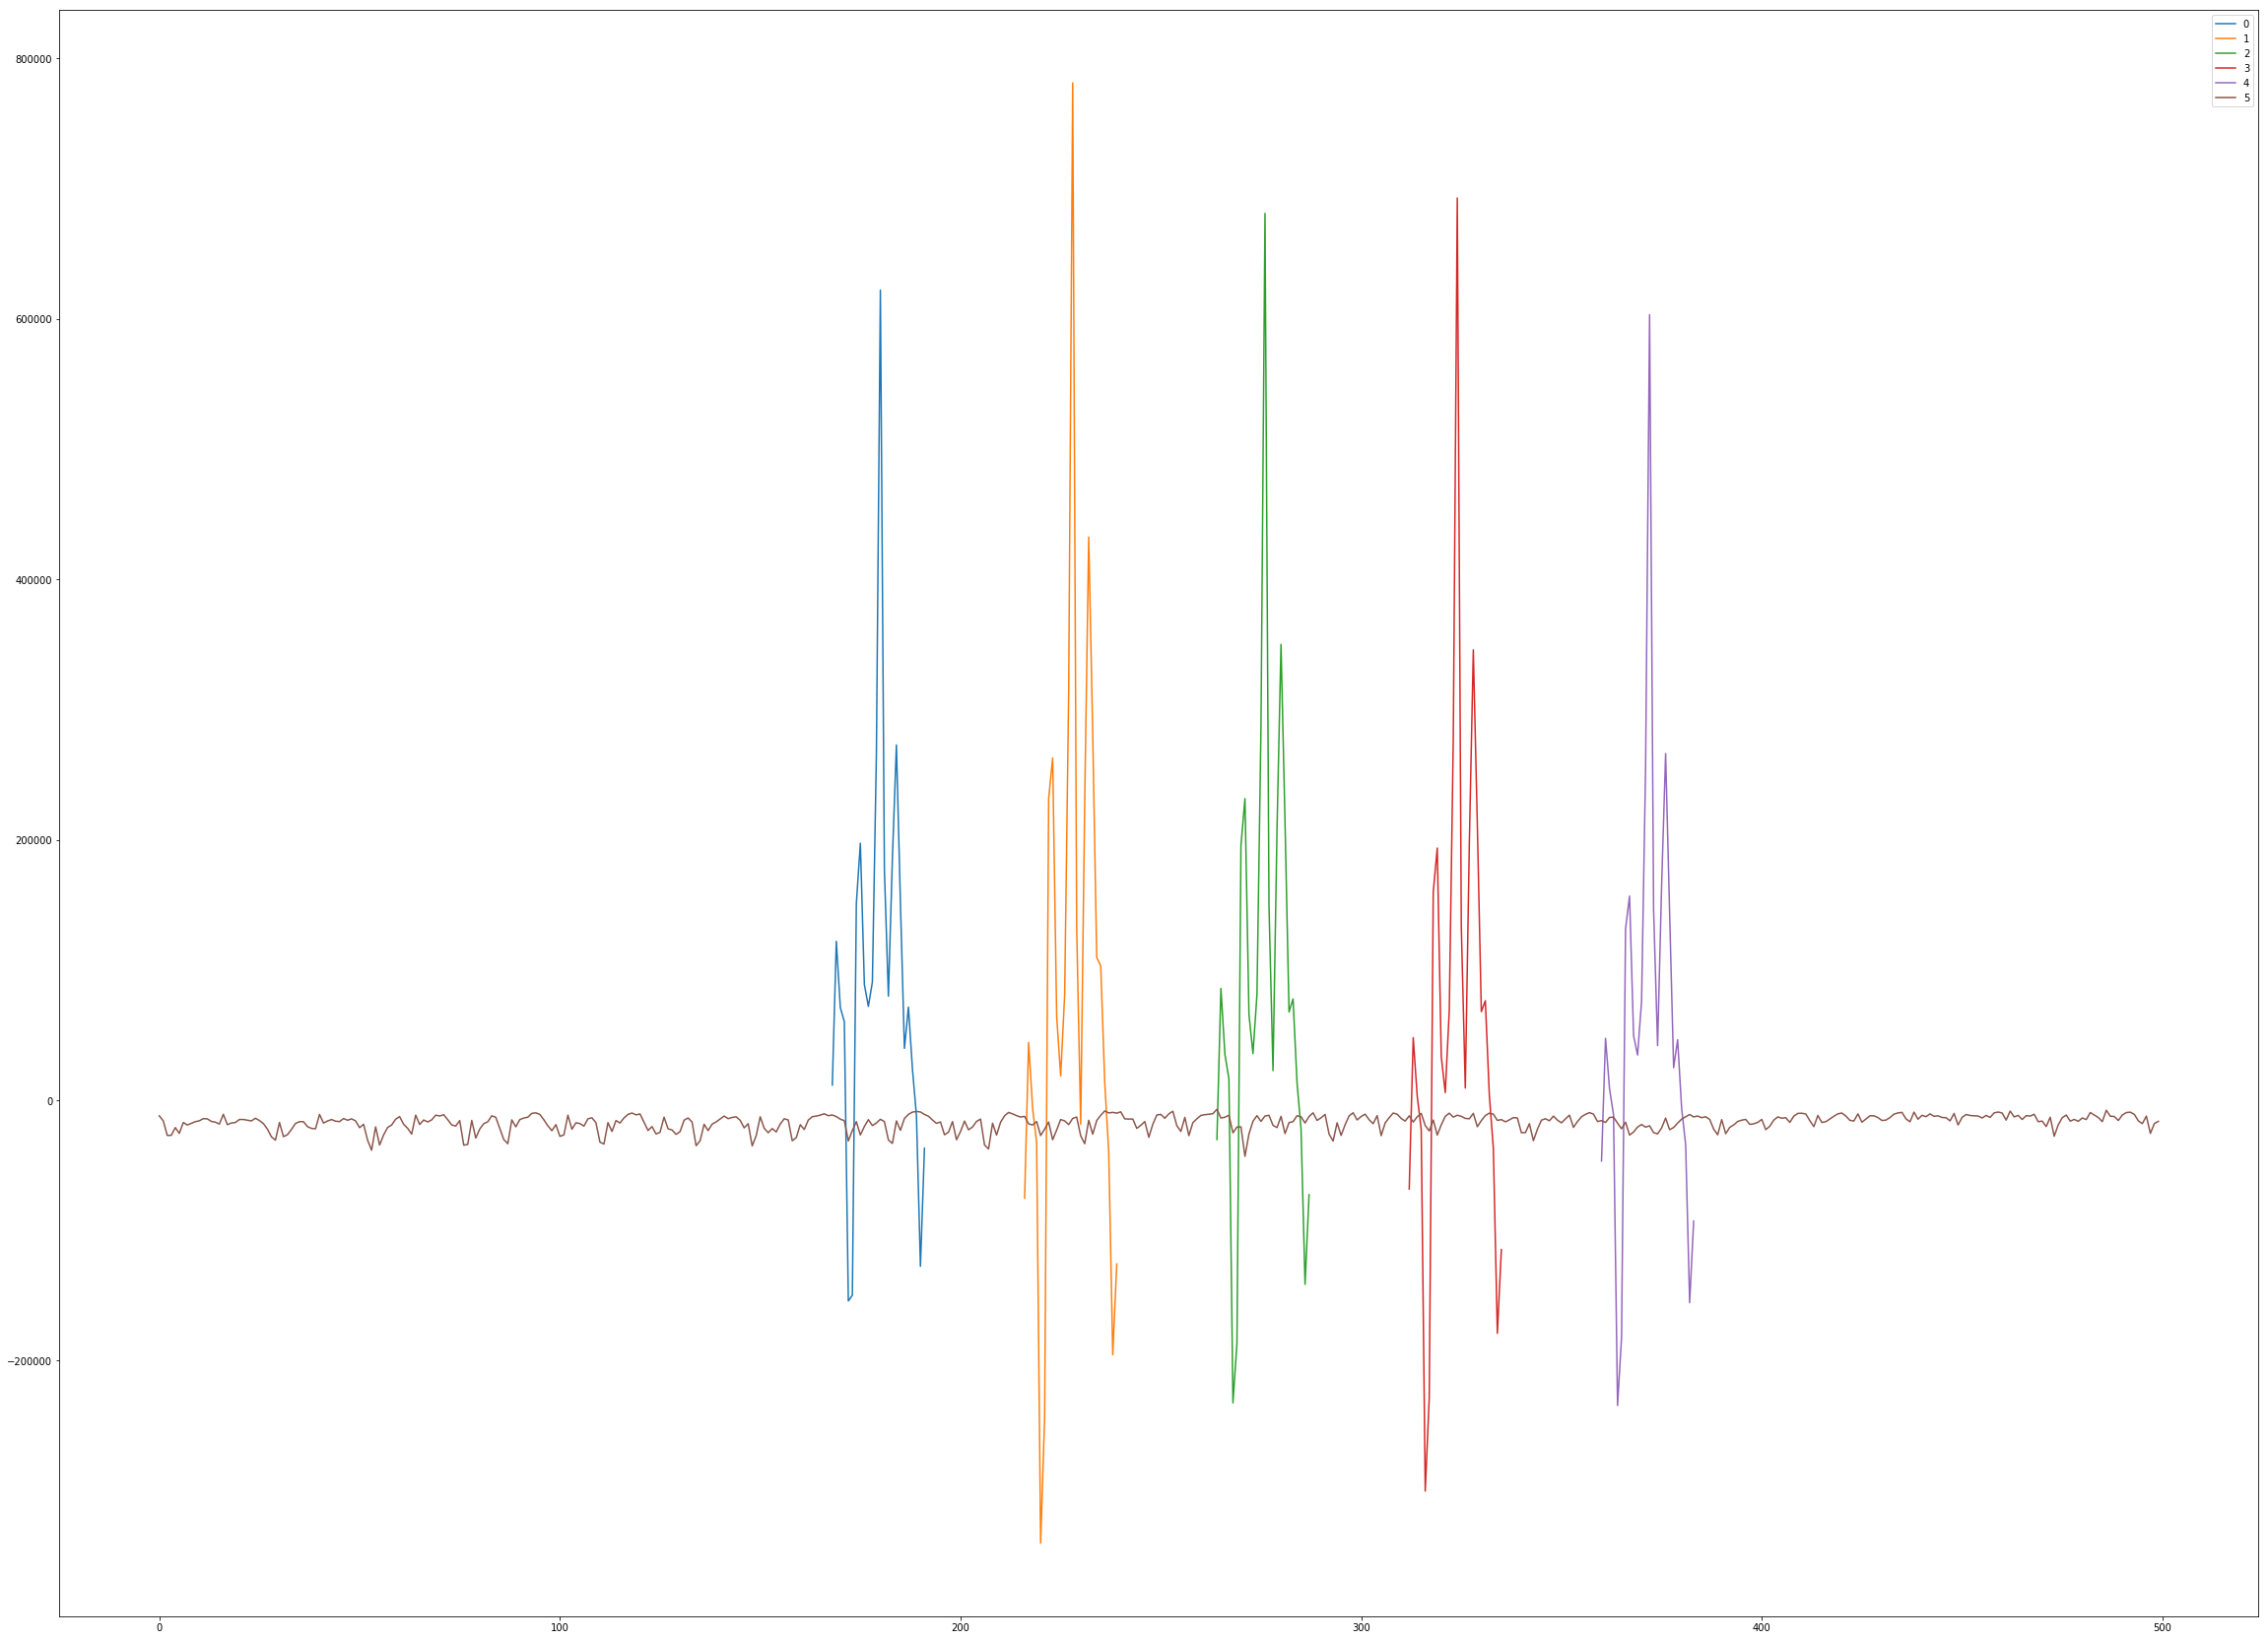

In [46]:
gen, base_data, scaler = get_gen_and_data(preprocessing="robust", flatten=True)
df_d = plot_for_model(model7, flatten=True)

Okay that is seriously crap! So I guess variant number two: One model and one scaler per customer. Let's see what fits in my ram!

In [47]:
models = {}
for i in range(250):
    model7 = Sequential()
    # input layer
    input_shape = (cfg.DEMAND_ONE_WEEK,)
    model7.add(Dense(168, input_shape=input_shape, activation='relu'))
    model7.add(BatchNormalization())
    model7.add(Dense(100, activation='relu'))
    model7.add(Dense(100, activation='relu'))
    model7.add(Dense(50, activation='relu'))
    model7.add(Dense(50, activation='relu'))
    model7.add(Dense(24))
    model7.add(Activation('linear'))
    model7.compile(loss='mse', optimizer='rmsprop')
    models[i] = model7

    

In [48]:
models

{0: <keras.models.Sequential at 0x7fb2eb002e10>,
 1: <keras.models.Sequential at 0x7fb2eb45ffd0>,
 2: <keras.models.Sequential at 0x7fb2eafe3f28>,
 3: <keras.models.Sequential at 0x7fb2eaea1f60>,
 4: <keras.models.Sequential at 0x7fb2eac36e48>,
 5: <keras.models.Sequential at 0x7fb32312b0f0>,
 6: <keras.models.Sequential at 0x7fb322f735c0>,
 7: <keras.models.Sequential at 0x7fb322db64a8>,
 8: <keras.models.Sequential at 0x7fb322bf6390>,
 9: <keras.models.Sequential at 0x7fb3229bff28>,
 10: <keras.models.Sequential at 0x7fb322803160>,
 11: <keras.models.Sequential at 0x7fb2eace1588>,
 12: <keras.models.Sequential at 0x7fb2eab5c400>,
 13: <keras.models.Sequential at 0x7fb32254dfd0>,
 14: <keras.models.Sequential at 0x7fb322386f60>,
 15: <keras.models.Sequential at 0x7fb318f61400>,
 16: <keras.models.Sequential at 0x7fb318d9d550>,
 17: <keras.models.Sequential at 0x7fb318bd30b8>,
 18: <keras.models.Sequential at 0x7fb318a19e48>,
 19: <keras.models.Sequential at 0x7fb311ff1f98>,
 20: <kera

Okay that took about 1GB of memory. survivable. So I could theoretically have a model per customer, store all of them and then select the correct model for each customer that requires a prediction. That's some organizational overhead but doesn't hurt very much. It would also require a scaling for each customer, ideally based on the bootstrap data for that customer or, based on a historical games min/max.

In [74]:
model7 = Sequential()
    # input layer
input_shape = (cfg.DEMAND_ONE_WEEK,)
model7.add(Dense(168, input_shape=input_shape, activation='linear'))
model5.add(BatchNormalization()) #applying batch normalization now
model7.add(Dense(100, activation='linear'))
model7.add(Dense(50, activation='linear'))
model7.add(Dense(24))
model7.add(Activation('linear'))
model7.compile(loss='mse', optimizer='rmsprop')


m =model7

(500, 6)
Epoch 1/15
145/145 [==============================] - 1s 5ms/step - loss: 1.8969
Epoch 2/15
145/145 [==============================] - 1s 4ms/step - loss: 0.6035
Epoch 3/15
145/145 [==============================] - 1s 5ms/step - loss: 0.4564
Epoch 4/15
145/145 [==============================] - 1s 5ms/step - loss: 0.3813
Epoch 5/15
145/145 [==============================] - 1s 5ms/step - loss: 0.3548
Epoch 6/15
145/145 [==============================] - 1s 5ms/step - loss: 0.3338
Epoch 7/15
145/145 [==============================] - 1s 5ms/step - loss: 0.3306
Epoch 8/15
145/145 [==============================] - 1s 5ms/step - loss: 0.3186
Epoch 9/15
145/145 [==============================] - 1s 5ms/step - loss: 0.2996
Epoch 10/15
145/145 [==============================] - 1s 5ms/step - loss: 0.2937
Epoch 11/15
145/145 [==============================] - 1s 5ms/step - loss: 0.2913
Epoch 12/15
145/145 [==============================] - 1s 5ms/step - loss: 0.2827
Epoch 13/15
145/

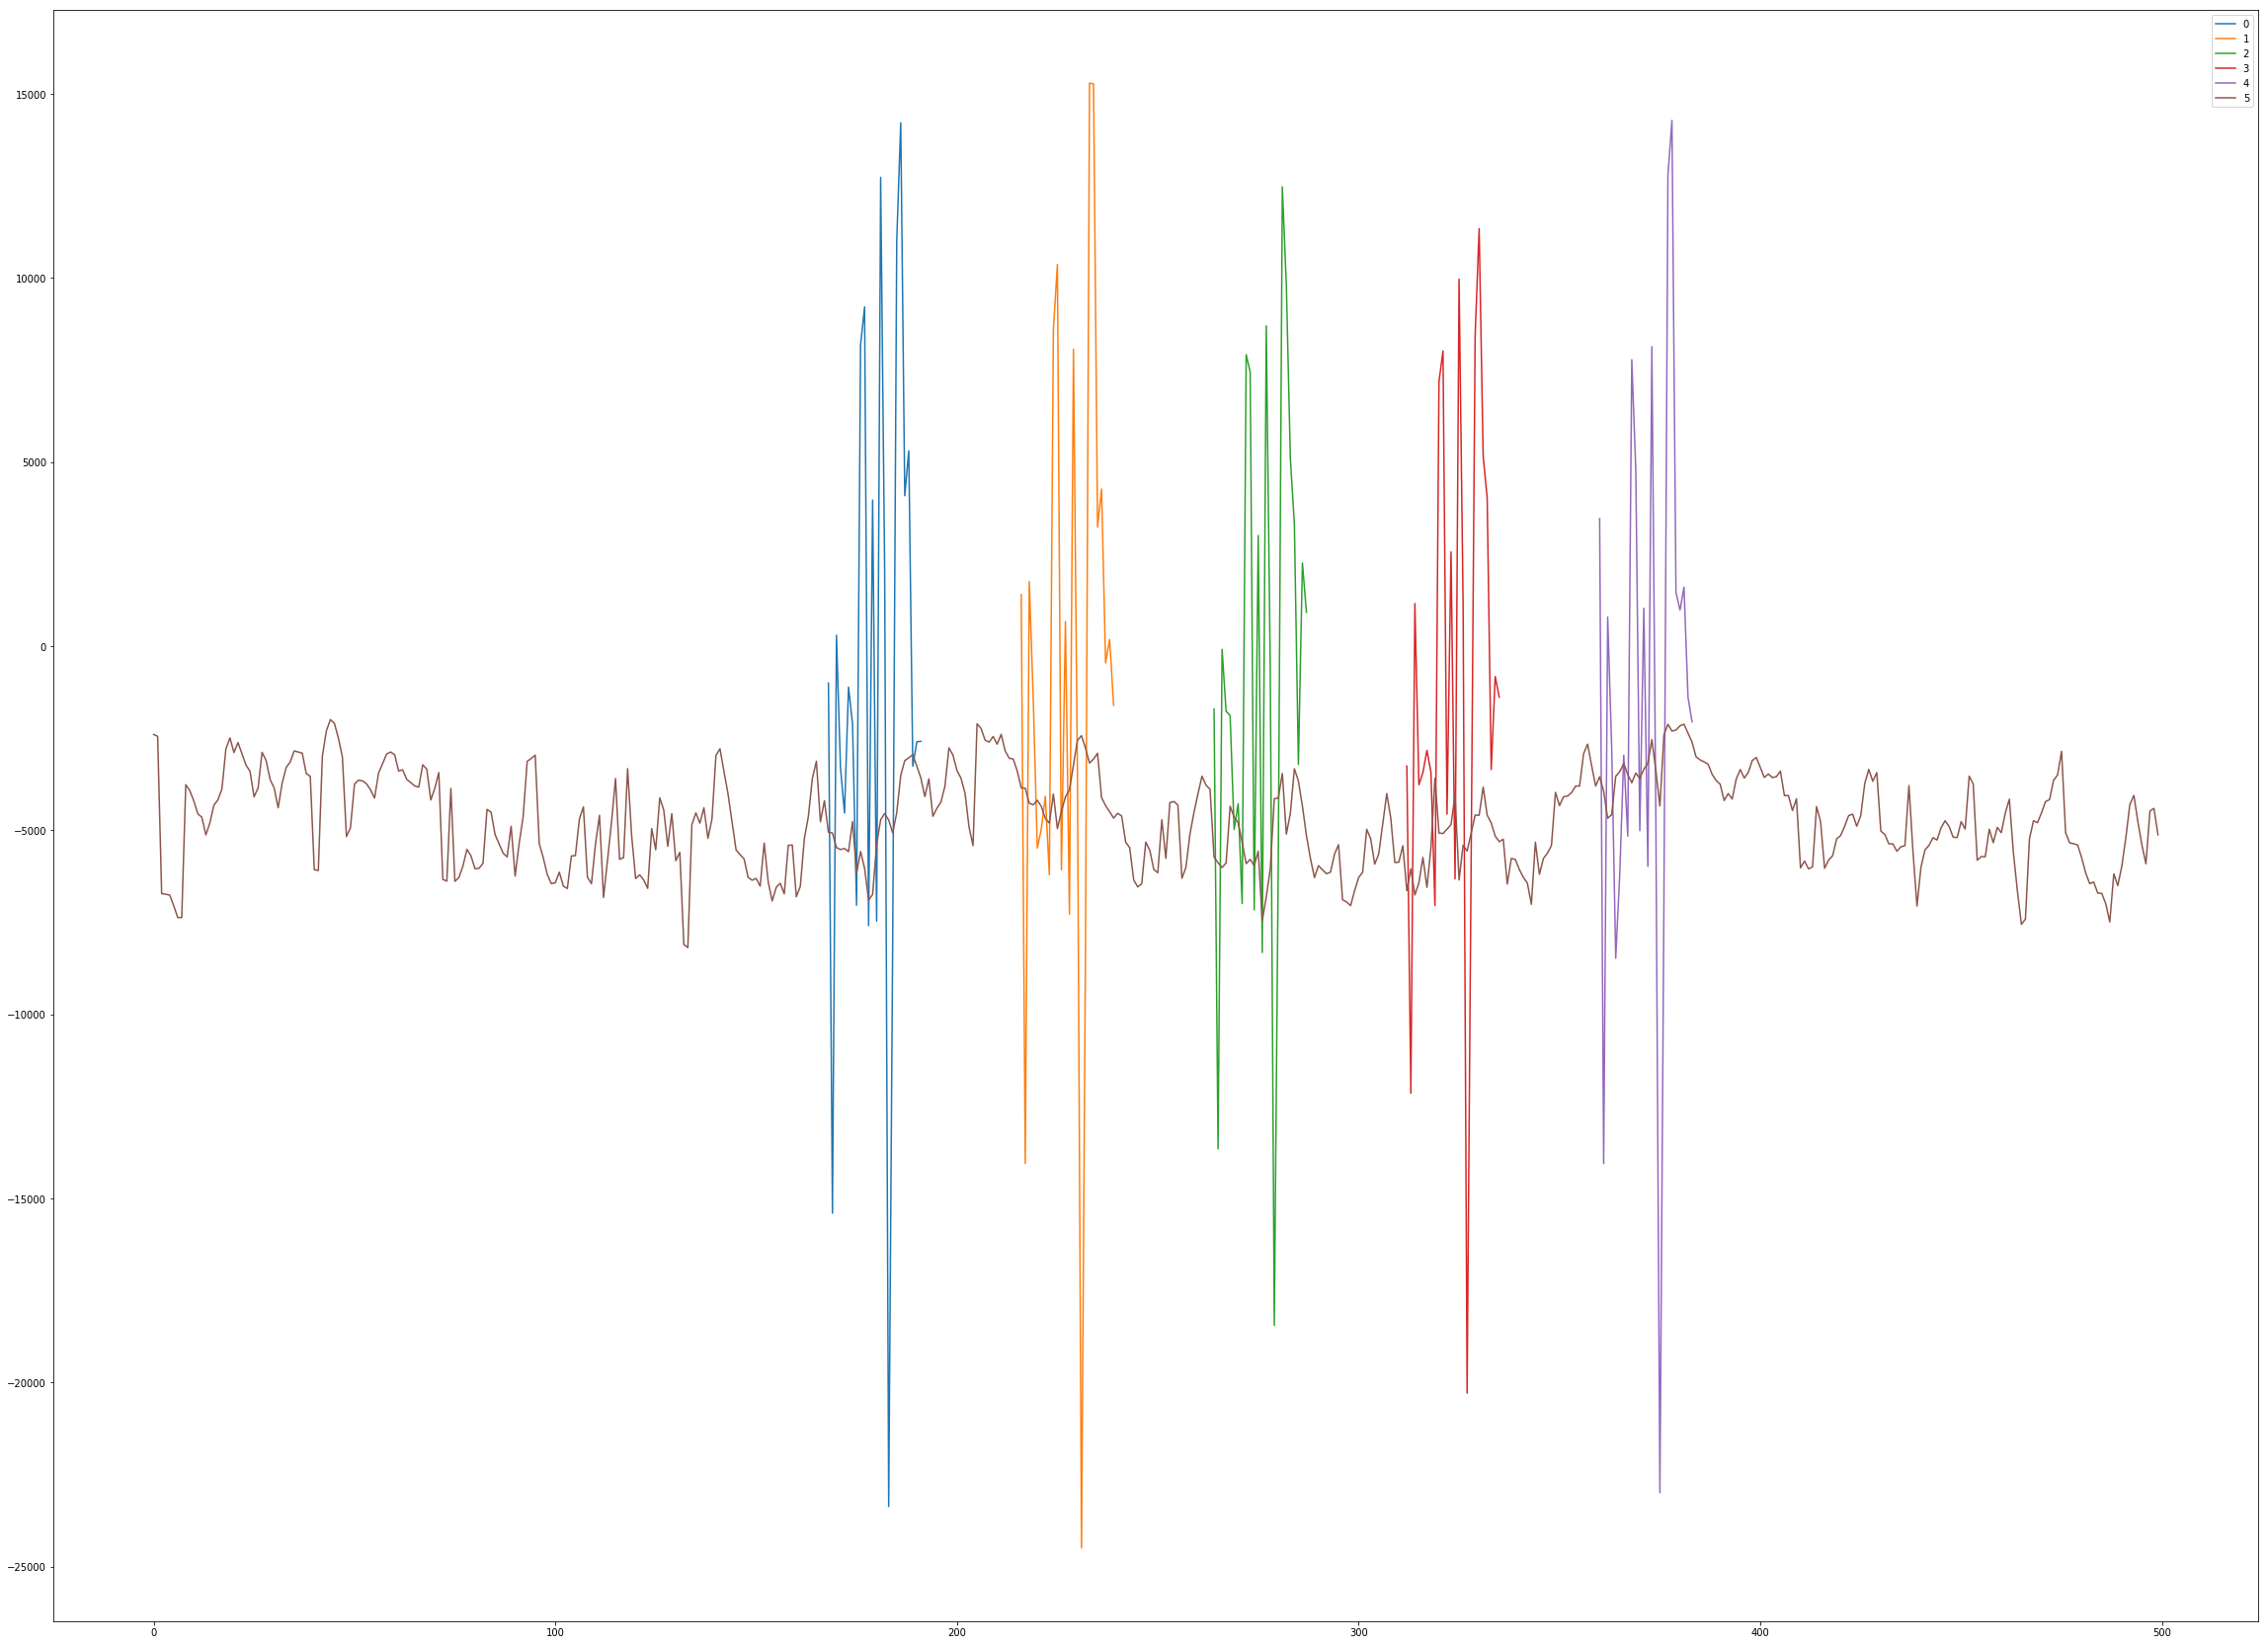

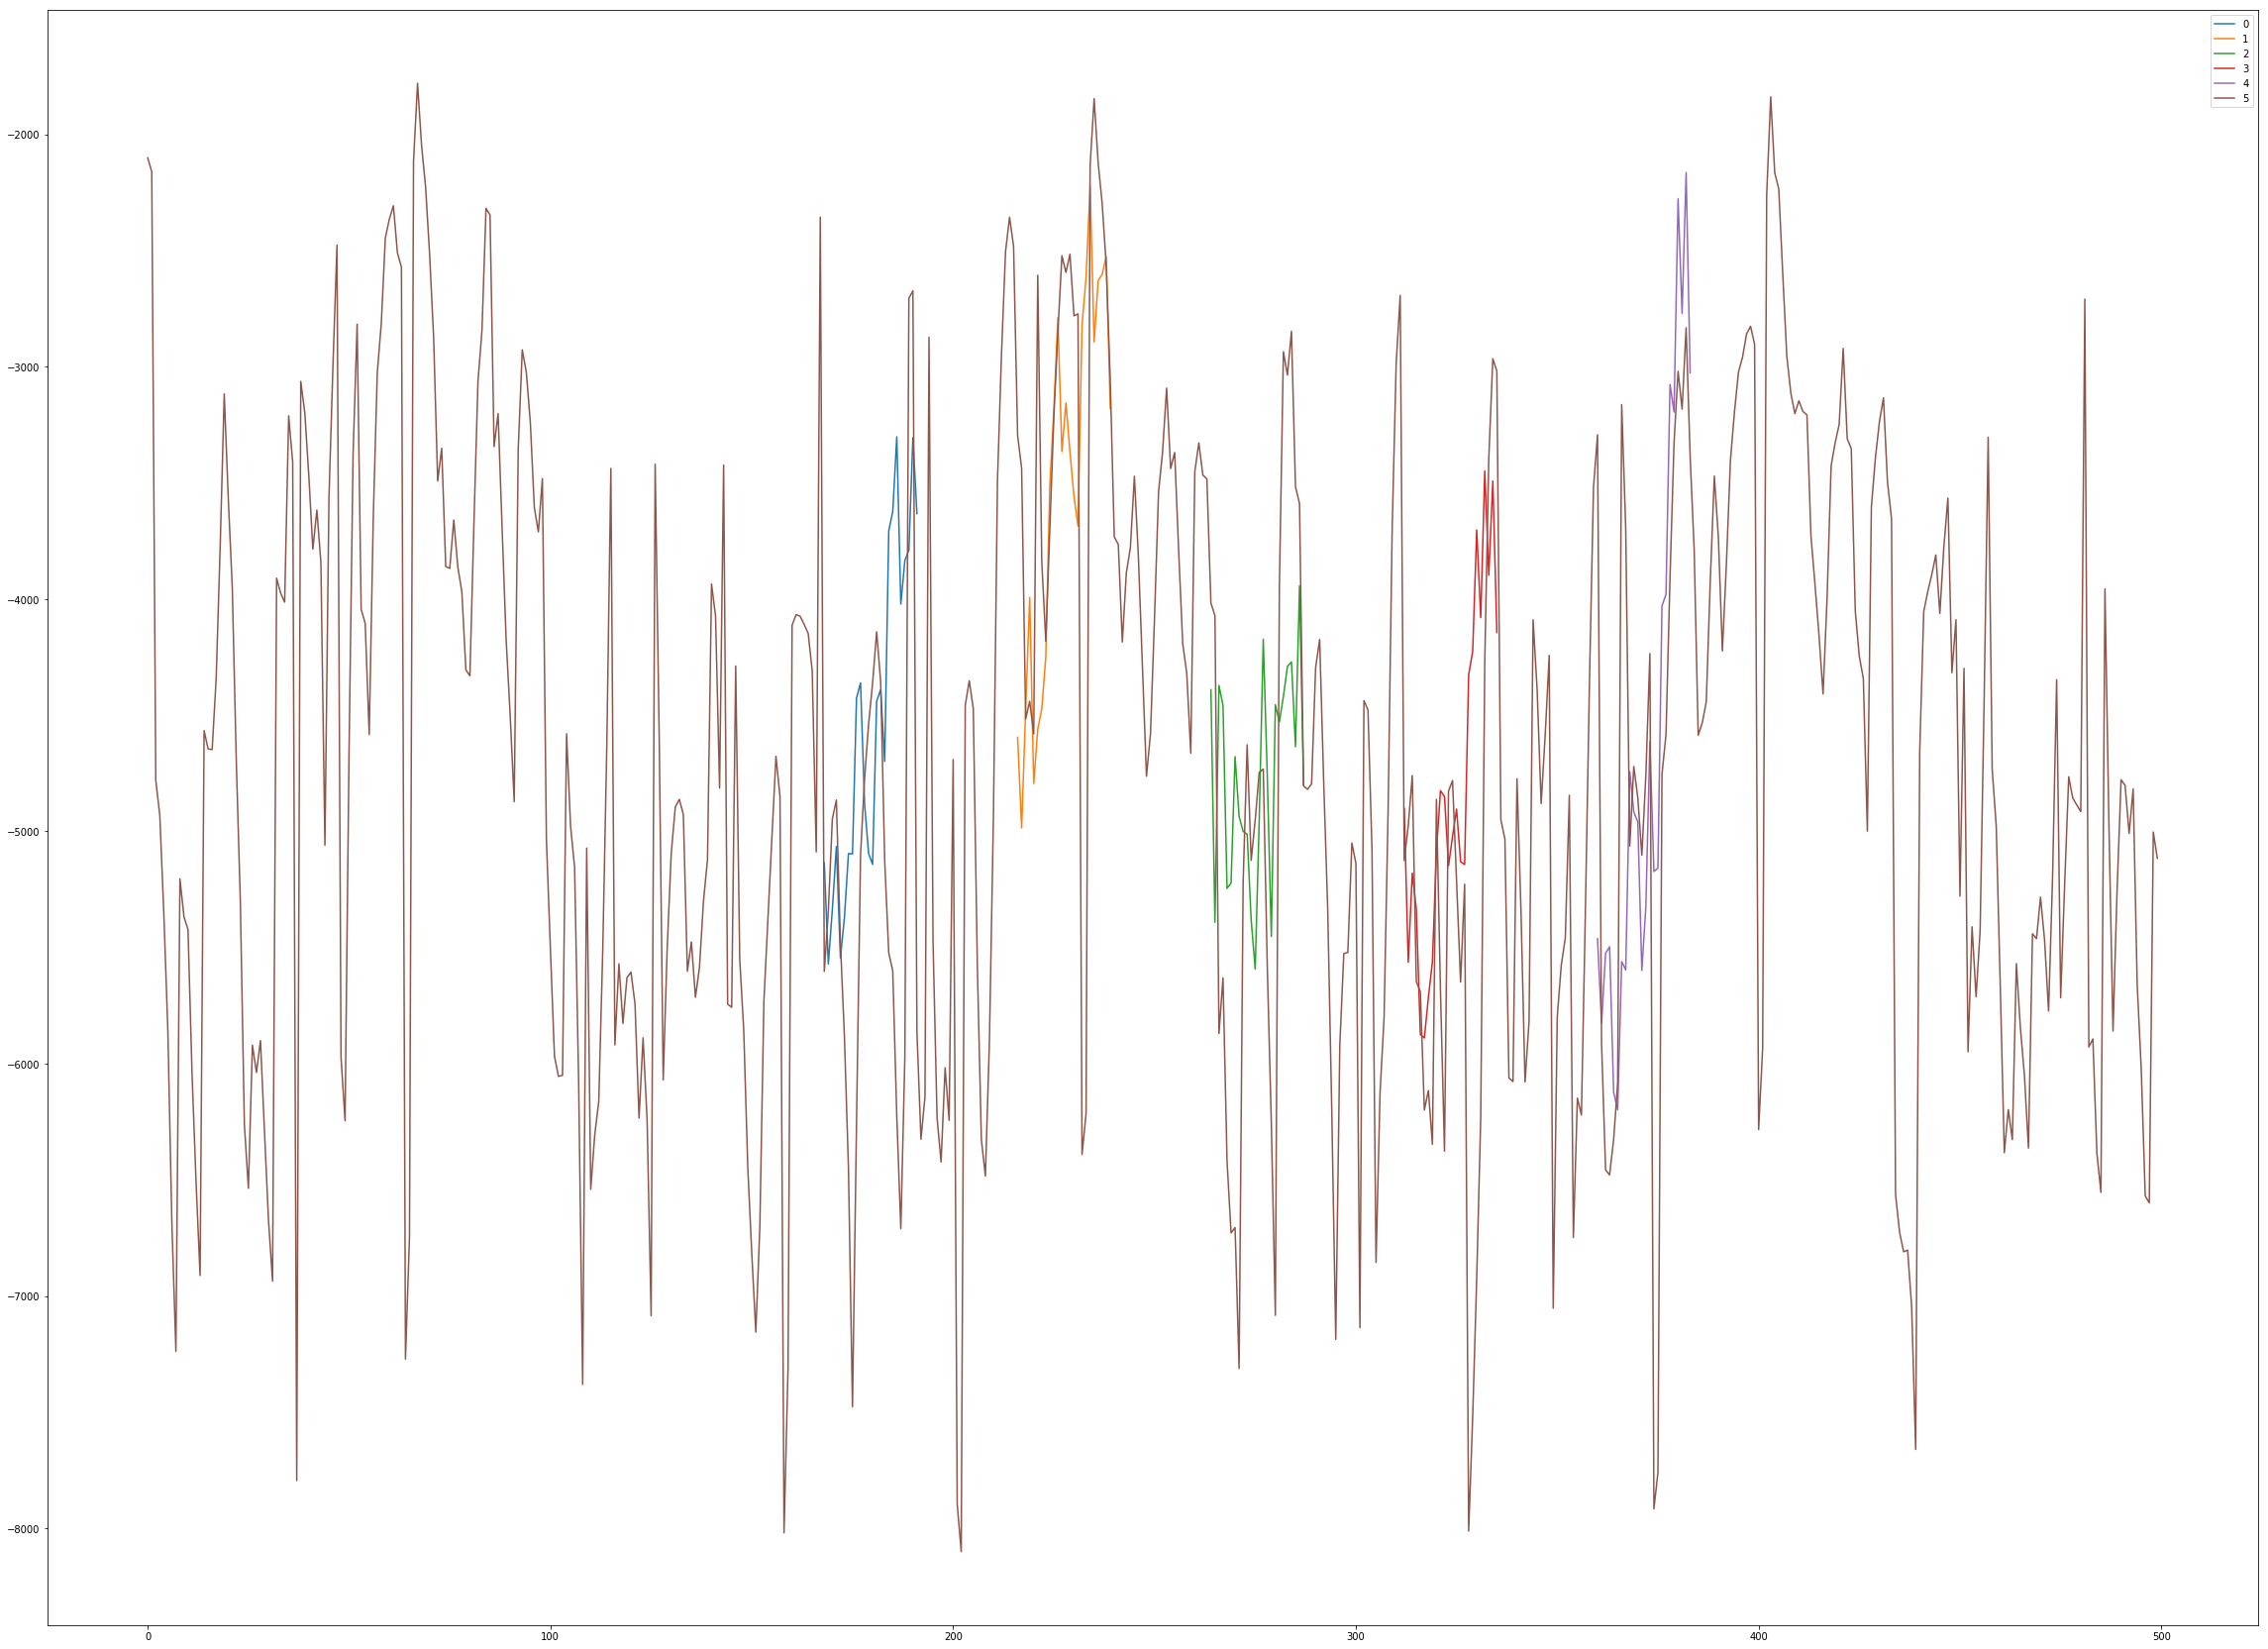

In [75]:
#learning on game A
f = game_files[4]
gen, base_data, scaler = get_gen_and_data(flatten=True, customer='EastsideOffices')
#plotting once before, to get the random performance
df_d = plot_for_model(m, flatten=True)
m.fit_generator(gen, epochs=15, callbacks=[tb_cb])
#predicting on game B
f = game_files[6]
gen, base_data, scaler = get_gen_and_data(flatten=True, customer='EastsideOffices')
df_d = plot_for_model(m, flatten=True)